In [1]:
from bs4 import BeautifulSoup as bs
import requests
from collections import OrderedDict
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import plotly as py
from plotly.offline import init_notebook_mode, iplot, plot
import plotly.graph_objs as go
from plotly.subplots import make_subplots

In [2]:
url = 'https://www.imdb.com/list/ls507232408/?sort=release_date,asc&st_dt=&mode=detail&page=1'
page_source = requests.get(url)
soup = bs(page_source.content, 'lxml')
movies = []
movie_characters = []
movie_lengths = OrderedDict()
movies_dont_want = ["¿Qué pasaría si...?",
					 "Marvel de un vistazo: El consultor",
					"El caso único de Marvel: Algo divertido ocurrió de camino al martillo de Thor",
					"Marvel extendido: Artículo 47",
					"Todos aclaman al rey"]
for movie in soup.find_all('div', class_='lister-item mode-detail'):
		# Fetching title of the movie
		movie_title = movie.find('div', class_='lister-item-content').h3.a.text
		if movie_title in movies_dont_want:
			continue
		# Fetching length of the movie
		movie_length = movie.find('div', class_='lister-item-content').find('span', class_='runtime').text
		movies.append(movie_title)
		movie_lengths[movie_title] = movie_length.split(' ')[0]
		# Fetching characters in the movie
		characters = movie.find('div', class_='list-description').p.text
		movie_characters.append(characters.split('\n'))
		


In [3]:
movies = []
movie_characters = []
movie_lengths = OrderedDict()
movies_dont_want = ["¿Qué pasaría si...?",
					 "Marvel de un vistazo: El consultor",
					"El caso único de Marvel: Algo divertido ocurrió de camino al martillo de Thor",
					"Marvel extendido: Artículo 47",
					"Todos aclaman al rey"]
for movie in soup.find_all('div', class_='lister-item mode-detail'):
		# Fetching title of the movie
		movie_title = movie.find('div', class_='lister-item-content').h3.a.text
		if movie_title in movies_dont_want:
			continue
		# Fetching length of the movie
		movie_length = movie.find('div', class_='lister-item-content').find('span', class_='runtime').text
		movies.append(movie_title)
		movie_lengths[movie_title] = movie_length.split(' ')[0]
		# Fetching characters in the movie
		characters = movie.find('div', class_='list-description').p.text
		movie_characters.append(characters.split('\n'))
data_dict = OrderedDict()
# Inputing data into the dictionary
for i in range(len(movies)):
	data_dict[movies[i]] = movie_characters[i]
data_dict['Spider-Man: Homecoming'][4]
data_dict['Loki'][0] = data_dict['Loki'][0].split('>')[1]+'>'
character_movie_time = {}
# Parsing through data scraped for each movie
for movie in data_dict.keys():
	# Parsing through each character in in the movie
	for item in data_dict[movie]:
		character = item.split('<')[0].strip()
		time = item.split('<')[1].split('>')[0].strip()
		# Adding time for each character to for each movie to the index dict
		if movie in character_movie_time.keys():
			character_movie_time[movie][character] = time
		else:
			character_movie_time[movie] = {character: time}
character_movie_time['Spider-Man: Homecoming']
char_id_index = pd.read_csv('characters.csv')
# Creating aa dict containing character IDs for each character
names = {old:new for (old, new) in zip(char_id_index['Character Name'], char_id_index['Character ID'])}
# Converting the data dict into a pandas data frame for easy handling
char_movie_matrix = pd.DataFrame(character_movie_time)
char_movie_matrix
char_movie_matrix['Spider-Man: Homecoming']
# Renaming characters with their character IDs
char_movie_matrix.rename(index=names, inplace=True)
char_movie_matrix
def combine_rows(matrix):
	"""Method that combines the duplicate rows that arose due to replacing character IDs"""
	# List of characters
	characters = list(set([character for character in matrix.index]))
	# Iterating over every character
	for character in characters:
		# Creating a mini data frame for each character
		df = matrix.loc[character]
		# If the character row is present just once, iterating over every column would be iterating over every movie
		if len(list(df.index)) != len(matrix.columns):
			# Iterating over every movie for each character
			for movie in matrix.columns:
				# Initializing update value to NaN
				value = np.nan
				li = []
				# Creating a list of values for each movie
				for i in range(len(df.index)):
					li.append(str(df.iloc[i][movie]))
				# Updating the right value
				for item in li:
					if str(item) != 'nan':
						value = item
				# Updating value to the location
				matrix.loc[character, movie] = value
	# If there are n duplicates, n rows would have been created with same values; deleting the duplicates
	matrix = matrix.drop_duplicates()
	return matrix
# Combine rows with same index
char_movie_matrix = combine_rows(char_movie_matrix)
char_movie_matrix
char_movie_matrix.index.tolist()
def convert_time_to_mins(matrix):
	"""Method that converts time of the format mm:ss or :ss or mm to minutes in float"""
	# Iterating over each character
	for character in matrix.index:
		# Iterating over each movie
		for movie in matrix.columns:
			# Current value of the cell in the matrix
			value = matrix.loc[character][movie]
			# Iterating over non NaN values only
			if str(value) != 'nan':
				# To convert strings of the format mm:ss
				if re.match(r'\d+:\d+', value):
					matrix.loc[character][movie] = float(value.split(':')[0]) + float(value.split(':')[1])/60
				# To convert strings of the format :ss
				elif re.match(r'^:\d+', value):
					matrix.loc[character][movie] = float(value.split(':')[1])/60
				# To convert strings of the format mm
				elif re.match(r'\b\d+\b(?!:)', value):
					matrix.loc[character][movie] = float(value)
				# Other formats assigned as NaN
				else:
					matrix.loc[character][movie] = np.nan
			# NaN values reassigned as NaN
			else:
				matrix.loc[character][movie] = np.nan
	return matrix
char_movie_matrix = convert_time_to_mins(char_movie_matrix)

char_movie_matrix['Total de tiempo en pantalla'] = char_movie_matrix.loc[:,:].sum(axis=1, skipna=True)
char_movie_matrix = char_movie_matrix.sort_values(by='Total de tiempo en pantalla', ascending=False)
char_movie_matrix = char_movie_matrix.fillna(0)
char_movie_matrix = char_movie_matrix[char_movie_matrix['Total de tiempo en pantalla'] != 0]
data = char_movie_matrix.head(20)
plt.figure(figsize=(15, 6))
data['Personajes'] = list(map(lambda x: '\n'.join(x.split(' ')),data.index))
sns.barplot(x='Personajes', y='Total de tiempo en pantalla', data=data);
apariciones_pj = OrderedDict()
for pj in char_movie_matrix.index:
    columnas_no_cero = char_movie_matrix.loc[pj, (char_movie_matrix.loc[pj] != 0) & (char_movie_matrix.loc[pj].apply(isinstance, args=(float,)))].index.tolist()
    apariciones_pj[pj]=columnas_no_cero[0:-1]


for i in apariciones_pj.keys():
    if re.match(r'.*Sara.*',i):
        print (i,apariciones_pj[i])
from itertools import islice
ordenado_por_longitud = OrderedDict(sorted(apariciones_pj.items(), key=lambda x: len(x[1]), reverse=True))

# Mostrar el resultado
for clave, valor in islice(ordenado_por_longitud.items(), 4):
    print(f'{clave}: {(valor)}')
claves = list(ordenado_por_longitud.keys())[:15]

longitudes = [len(ordenado_por_longitud[clave]) for clave in claves]
claves = list(map(lambda x: '\n'.join(x.split(' ')),claves))

# Crear el gráfico de barras
plt.figure(figsize=(15, 6))
plt.bar(claves, longitudes)

# Añadir etiquetas y título
plt.xlabel('Personajes')
plt.ylabel('nº de peliculas')
plt.title('nº total de peliculas en las que aparecen los personajes');
char_movie_matrix[char_movie_matrix['Spider-Man: Homecoming'] != 0]['Spider-Man: Homecoming'].sort_values(ascending=False)
def grafico_char_tiempo_pelicula (pelicula):
    data = pd.DataFrame(char_movie_matrix[char_movie_matrix[pelicula] != 0][pelicula].sort_values(ascending=False))
    plt.figure(figsize=(15, 6))
    data['Personajes'] = list(map(lambda x: '\n'.join(x.split(' ')),data.index))
    sns.barplot(x='Personajes', y=pelicula, data=data)

grafico_char_tiempo_pelicula ('Spider-Man: No Way Home')

def grafico_peliculas_del_char (char):
    peliculas = {}
    for peli in apariciones_pj[char]:
        peliculas[peli] = char_movie_matrix.loc[char][peli]
    plt.figure(figsize=(20, 6))
    pelis = list(map(lambda x: '\n'.join(x.split(' ')),list(peliculas.keys())))
    sns.barplot(x=pelis, y=list(peliculas.values()))
    plt.title(char)
    plt.xlabel('Peliculas')
    plt.ylabel('Tiempo en pantalla');

grafico_peliculas_del_char ('Valkyrie')

columna_tiempo_total_peliculas_char = []
for char in char_movie_matrix.index:
    tiempo_total_peliculas_char = 0
    for peli in apariciones_pj[char]:
        tiempo_total_peliculas_char += float(movie_lengths[peli])
    columna_tiempo_total_peliculas_char.append(tiempo_total_peliculas_char)

columna_porcentage_tiempo_pantalla = []
suma_tiempos = list(dict(char_movie_matrix['Total de tiempo en pantalla']).values())
for i in range(len(columna_tiempo_total_peliculas_char)):
    columna_porcentage_tiempo_pantalla.append((suma_tiempos[i]/columna_tiempo_total_peliculas_char[i])*100)
columna_porcentage_tiempo_pantalla
nueva_fila = pd.DataFrame([movie_lengths])
nueva_fila = convert_time_to_mins(nueva_fila)
nuevo_df = (char_movie_matrix.iloc[:, :-1].div(nueva_fila.iloc[0]))*100
nuevo_df
def grafico_pie_t_pantalla (pelicula):    
    df = char_movie_matrix[char_movie_matrix[pelicula] != 0]
    pie1 = df[pelicula]
    pie1_list = list(pie1.values)
    pie1_list = [round(each,2) for each in pie1_list]
    labels = df.index

    # Figure
    fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'pie'}]])

    fig.add_trace(
        go.Pie(
            labels=labels,
            values=pie1_list,
            textinfo='value',
            hoverinfo="label+value",
            hole=0.3,
        ),
        row=1, col=1
        
    )

    fig.update_layout(
        title="Tiempo en pantalla en " + pelicula + ' (' + movie_lengths[pelicula] +')',
        annotations=[
            {
                "font": {"size": 20},
                "showarrow": False,
                "text": pelicula,
                "x": 0.5,
                "y": 1.07,
            }
        ],
        height=700,  # Ajusta la altura del gráfico
        width=900,   # Ajusta el ancho del gráfico
    )

    fig.show()

grafico_pie_t_pantalla('Ojo de Halcón')

In [4]:
movies_dont_want = ["¿Qué pasaría si...?",
					 "Marvel de un vistazo: El consultor",
					"El caso único de Marvel: Algo divertido ocurrió de camino al martillo de Thor",
					"Marvel extendido: Artículo 47",
					"Todos aclaman al rey"]
for movie in soup.find_all('div', class_='lister-item mode-detail'):
		# Fetching title of the movie
		movie_title = movie.find('div', class_='lister-item-content').h3.a.text
		if movie_title in movies_dont_want:
			continue
		# Fetching length of the movie
		movie_length = movie.find('div', class_='lister-item-content').find('span', class_='runtime').text
		movies.append(movie_title)
		movie_lengths[movie_title] = movie_length.split(' ')[0]
		# Fetching characters in the movie
		characters = movie.find('div', class_='list-description').p.text
		movie_characters.append(characters.split('\n'))
data_dict = OrderedDict()
# Inputing data into the dictionary
for i in range(len(movies)):
	data_dict[movies[i]] = movie_characters[i]
data_dict['Spider-Man: Homecoming'][4]
data_dict['Loki'][0] = data_dict['Loki'][0].split('>')[1]+'>'
character_movie_time = {}
# Parsing through data scraped for each movie
for movie in data_dict.keys():
	# Parsing through each character in in the movie
	for item in data_dict[movie]:
		character = item.split('<')[0].strip()
		time = item.split('<')[1].split('>')[0].strip()
		# Adding time for each character to for each movie to the index dict
		if movie in character_movie_time.keys():
			character_movie_time[movie][character] = time
		else:
			character_movie_time[movie] = {character: time}
character_movie_time['Spider-Man: Homecoming']
char_id_index = pd.read_csv('characters.csv')
# Creating aa dict containing character IDs for each character
names = {old:new for (old, new) in zip(char_id_index['Character Name'], char_id_index['Character ID'])}
# Converting the data dict into a pandas data frame for easy handling
char_movie_matrix = pd.DataFrame(character_movie_time)
char_movie_matrix
char_movie_matrix['Spider-Man: Homecoming']
# Renaming characters with their character IDs
char_movie_matrix.rename(index=names, inplace=True)
char_movie_matrix
def combine_rows(matrix):
	"""Method that combines the duplicate rows that arose due to replacing character IDs"""
	# List of characters
	characters = list(set([character for character in matrix.index]))
	# Iterating over every character
	for character in characters:
		# Creating a mini data frame for each character
		df = matrix.loc[character]
		# If the character row is present just once, iterating over every column would be iterating over every movie
		if len(list(df.index)) != len(matrix.columns):
			# Iterating over every movie for each character
			for movie in matrix.columns:
				# Initializing update value to NaN
				value = np.nan
				li = []
				# Creating a list of values for each movie
				for i in range(len(df.index)):
					li.append(str(df.iloc[i][movie]))
				# Updating the right value
				for item in li:
					if str(item) != 'nan':
						value = item
				# Updating value to the location
				matrix.loc[character, movie] = value
	# If there are n duplicates, n rows would have been created with same values; deleting the duplicates
	matrix = matrix.drop_duplicates()
	return matrix
# Combine rows with same index
char_movie_matrix = combine_rows(char_movie_matrix)
char_movie_matrix
char_movie_matrix.index.tolist()
def convert_time_to_mins(matrix):
	"""Method that converts time of the format mm:ss or :ss or mm to minutes in float"""
	# Iterating over each character
	for character in matrix.index:
		# Iterating over each movie
		for movie in matrix.columns:
			# Current value of the cell in the matrix
			value = matrix.loc[character][movie]
			# Iterating over non NaN values only
			if str(value) != 'nan':
				# To convert strings of the format mm:ss
				if re.match(r'\d+:\d+', value):
					matrix.loc[character][movie] = float(value.split(':')[0]) + float(value.split(':')[1])/60
				# To convert strings of the format :ss
				elif re.match(r'^:\d+', value):
					matrix.loc[character][movie] = float(value.split(':')[1])/60
				# To convert strings of the format mm
				elif re.match(r'\b\d+\b(?!:)', value):
					matrix.loc[character][movie] = float(value)
				# Other formats assigned as NaN
				else:
					matrix.loc[character][movie] = np.nan
			# NaN values reassigned as NaN
			else:
				matrix.loc[character][movie] = np.nan
	return matrix
char_movie_matrix = convert_time_to_mins(char_movie_matrix)

char_movie_matrix['Total de tiempo en pantalla'] = char_movie_matrix.loc[:,:].sum(axis=1, skipna=True)
char_movie_matrix = char_movie_matrix.sort_values(by='Total de tiempo en pantalla', ascending=False)
char_movie_matrix = char_movie_matrix.fillna(0)
char_movie_matrix = char_movie_matrix[char_movie_matrix['Total de tiempo en pantalla'] != 0]
data = char_movie_matrix.head(20)
plt.figure(figsize=(15, 6))
data['Personajes'] = list(map(lambda x: '\n'.join(x.split(' ')),data.index))
sns.barplot(x='Personajes', y='Total de tiempo en pantalla', data=data);
apariciones_pj = OrderedDict()
for pj in char_movie_matrix.index:
    columnas_no_cero = char_movie_matrix.loc[pj, (char_movie_matrix.loc[pj] != 0) & (char_movie_matrix.loc[pj].apply(isinstance, args=(float,)))].index.tolist()
    apariciones_pj[pj]=columnas_no_cero[0:-1]


for i in apariciones_pj.keys():
    if re.match(r'.*Sara.*',i):
        print (i,apariciones_pj[i])
from itertools import islice
ordenado_por_longitud = OrderedDict(sorted(apariciones_pj.items(), key=lambda x: len(x[1]), reverse=True))

# Mostrar el resultado
for clave, valor in islice(ordenado_por_longitud.items(), 4):
    print(f'{clave}: {(valor)}')
claves = list(ordenado_por_longitud.keys())[:15]

longitudes = [len(ordenado_por_longitud[clave]) for clave in claves]
claves = list(map(lambda x: '\n'.join(x.split(' ')),claves))

# Crear el gráfico de barras
plt.figure(figsize=(15, 6))
plt.bar(claves, longitudes)

# Añadir etiquetas y título
plt.xlabel('Personajes')
plt.ylabel('nº de peliculas')
plt.title('nº total de peliculas en las que aparecen los personajes');
char_movie_matrix[char_movie_matrix['Spider-Man: Homecoming'] != 0]['Spider-Man: Homecoming'].sort_values(ascending=False)
def grafico_char_tiempo_pelicula (pelicula):
    data = pd.DataFrame(char_movie_matrix[char_movie_matrix[pelicula] != 0][pelicula].sort_values(ascending=False))
    plt.figure(figsize=(15, 6))
    data['Personajes'] = list(map(lambda x: '\n'.join(x.split(' ')),data.index))
    sns.barplot(x='Personajes', y=pelicula, data=data)

grafico_char_tiempo_pelicula ('Spider-Man: No Way Home')

def grafico_peliculas_del_char (char):
    peliculas = {}
    for peli in apariciones_pj[char]:
        peliculas[peli] = char_movie_matrix.loc[char][peli]
    plt.figure(figsize=(20, 6))
    pelis = list(map(lambda x: '\n'.join(x.split(' ')),list(peliculas.keys())))
    sns.barplot(x=pelis, y=list(peliculas.values()))
    plt.title(char)
    plt.xlabel('Peliculas')
    plt.ylabel('Tiempo en pantalla');

grafico_peliculas_del_char ('Valkyrie')

columna_tiempo_total_peliculas_char = []
for char in char_movie_matrix.index:
    tiempo_total_peliculas_char = 0
    for peli in apariciones_pj[char]:
        tiempo_total_peliculas_char += float(movie_lengths[peli])
    columna_tiempo_total_peliculas_char.append(tiempo_total_peliculas_char)

columna_porcentage_tiempo_pantalla = []
suma_tiempos = list(dict(char_movie_matrix['Total de tiempo en pantalla']).values())
for i in range(len(columna_tiempo_total_peliculas_char)):
    columna_porcentage_tiempo_pantalla.append((suma_tiempos[i]/columna_tiempo_total_peliculas_char[i])*100)
columna_porcentage_tiempo_pantalla
nueva_fila = pd.DataFrame([movie_lengths])
nueva_fila = convert_time_to_mins(nueva_fila)
nuevo_df = (char_movie_matrix.iloc[:, :-1].div(nueva_fila.iloc[0]))*100
nuevo_df
def grafico_pie_t_pantalla (pelicula):    
    df = char_movie_matrix[char_movie_matrix[pelicula] != 0]
    pie1 = df[pelicula]
    pie1_list = list(pie1.values)
    pie1_list = [round(each,2) for each in pie1_list]
    labels = df.index

    # Figure
    fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'pie'}]])

    fig.add_trace(
        go.Pie(
            labels=labels,
            values=pie1_list,
            textinfo='value',
            hoverinfo="label+value",
            hole=0.3,
        ),
        row=1, col=1
        
    )

    fig.update_layout(
        title="Tiempo en pantalla en " + pelicula + ' (' + movie_lengths[pelicula] +')',
        annotations=[
            {
                "font": {"size": 20},
                "showarrow": False,
                "text": pelicula,
                "x": 0.5,
                "y": 1.07,
            }
        ],
        height=700,  # Ajusta la altura del gráfico
        width=900,   # Ajusta el ancho del gráfico
    )

    fig.show()

grafico_pie_t_pantalla('Ojo de Halcón')

In [5]:
data_dict = OrderedDict()
# Inputing data into the dictionary
for i in range(len(movies)):
	data_dict[movies[i]] = movie_characters[i]
data_dict['Spider-Man: Homecoming'][4]
data_dict['Loki'][0] = data_dict['Loki'][0].split('>')[1]+'>'
character_movie_time = {}
# Parsing through data scraped for each movie
for movie in data_dict.keys():
	# Parsing through each character in in the movie
	for item in data_dict[movie]:
		character = item.split('<')[0].strip()
		time = item.split('<')[1].split('>')[0].strip()
		# Adding time for each character to for each movie to the index dict
		if movie in character_movie_time.keys():
			character_movie_time[movie][character] = time
		else:
			character_movie_time[movie] = {character: time}
character_movie_time['Spider-Man: Homecoming']
char_id_index = pd.read_csv('characters.csv')
# Creating aa dict containing character IDs for each character
names = {old:new for (old, new) in zip(char_id_index['Character Name'], char_id_index['Character ID'])}
# Converting the data dict into a pandas data frame for easy handling
char_movie_matrix = pd.DataFrame(character_movie_time)
char_movie_matrix
char_movie_matrix['Spider-Man: Homecoming']
# Renaming characters with their character IDs
char_movie_matrix.rename(index=names, inplace=True)
char_movie_matrix
def combine_rows(matrix):
	"""Method that combines the duplicate rows that arose due to replacing character IDs"""
	# List of characters
	characters = list(set([character for character in matrix.index]))
	# Iterating over every character
	for character in characters:
		# Creating a mini data frame for each character
		df = matrix.loc[character]
		# If the character row is present just once, iterating over every column would be iterating over every movie
		if len(list(df.index)) != len(matrix.columns):
			# Iterating over every movie for each character
			for movie in matrix.columns:
				# Initializing update value to NaN
				value = np.nan
				li = []
				# Creating a list of values for each movie
				for i in range(len(df.index)):
					li.append(str(df.iloc[i][movie]))
				# Updating the right value
				for item in li:
					if str(item) != 'nan':
						value = item
				# Updating value to the location
				matrix.loc[character, movie] = value
	# If there are n duplicates, n rows would have been created with same values; deleting the duplicates
	matrix = matrix.drop_duplicates()
	return matrix
# Combine rows with same index
char_movie_matrix = combine_rows(char_movie_matrix)
char_movie_matrix
char_movie_matrix.index.tolist()
def convert_time_to_mins(matrix):
	"""Method that converts time of the format mm:ss or :ss or mm to minutes in float"""
	# Iterating over each character
	for character in matrix.index:
		# Iterating over each movie
		for movie in matrix.columns:
			# Current value of the cell in the matrix
			value = matrix.loc[character][movie]
			# Iterating over non NaN values only
			if str(value) != 'nan':
				# To convert strings of the format mm:ss
				if re.match(r'\d+:\d+', value):
					matrix.loc[character][movie] = float(value.split(':')[0]) + float(value.split(':')[1])/60
				# To convert strings of the format :ss
				elif re.match(r'^:\d+', value):
					matrix.loc[character][movie] = float(value.split(':')[1])/60
				# To convert strings of the format mm
				elif re.match(r'\b\d+\b(?!:)', value):
					matrix.loc[character][movie] = float(value)
				# Other formats assigned as NaN
				else:
					matrix.loc[character][movie] = np.nan
			# NaN values reassigned as NaN
			else:
				matrix.loc[character][movie] = np.nan
	return matrix
char_movie_matrix = convert_time_to_mins(char_movie_matrix)

char_movie_matrix['Total de tiempo en pantalla'] = char_movie_matrix.loc[:,:].sum(axis=1, skipna=True)
char_movie_matrix = char_movie_matrix.sort_values(by='Total de tiempo en pantalla', ascending=False)
char_movie_matrix = char_movie_matrix.fillna(0)
char_movie_matrix = char_movie_matrix[char_movie_matrix['Total de tiempo en pantalla'] != 0]
data = char_movie_matrix.head(20)
plt.figure(figsize=(15, 6))
data['Personajes'] = list(map(lambda x: '\n'.join(x.split(' ')),data.index))
sns.barplot(x='Personajes', y='Total de tiempo en pantalla', data=data);
apariciones_pj = OrderedDict()
for pj in char_movie_matrix.index:
    columnas_no_cero = char_movie_matrix.loc[pj, (char_movie_matrix.loc[pj] != 0) & (char_movie_matrix.loc[pj].apply(isinstance, args=(float,)))].index.tolist()
    apariciones_pj[pj]=columnas_no_cero[0:-1]


for i in apariciones_pj.keys():
    if re.match(r'.*Sara.*',i):
        print (i,apariciones_pj[i])
from itertools import islice
ordenado_por_longitud = OrderedDict(sorted(apariciones_pj.items(), key=lambda x: len(x[1]), reverse=True))

# Mostrar el resultado
for clave, valor in islice(ordenado_por_longitud.items(), 4):
    print(f'{clave}: {(valor)}')
claves = list(ordenado_por_longitud.keys())[:15]

longitudes = [len(ordenado_por_longitud[clave]) for clave in claves]
claves = list(map(lambda x: '\n'.join(x.split(' ')),claves))

# Crear el gráfico de barras
plt.figure(figsize=(15, 6))
plt.bar(claves, longitudes)

# Añadir etiquetas y título
plt.xlabel('Personajes')
plt.ylabel('nº de peliculas')
plt.title('nº total de peliculas en las que aparecen los personajes');
char_movie_matrix[char_movie_matrix['Spider-Man: Homecoming'] != 0]['Spider-Man: Homecoming'].sort_values(ascending=False)
def grafico_char_tiempo_pelicula (pelicula):
    data = pd.DataFrame(char_movie_matrix[char_movie_matrix[pelicula] != 0][pelicula].sort_values(ascending=False))
    plt.figure(figsize=(15, 6))
    data['Personajes'] = list(map(lambda x: '\n'.join(x.split(' ')),data.index))
    sns.barplot(x='Personajes', y=pelicula, data=data)

grafico_char_tiempo_pelicula ('Spider-Man: No Way Home')

def grafico_peliculas_del_char (char):
    peliculas = {}
    for peli in apariciones_pj[char]:
        peliculas[peli] = char_movie_matrix.loc[char][peli]
    plt.figure(figsize=(20, 6))
    pelis = list(map(lambda x: '\n'.join(x.split(' ')),list(peliculas.keys())))
    sns.barplot(x=pelis, y=list(peliculas.values()))
    plt.title(char)
    plt.xlabel('Peliculas')
    plt.ylabel('Tiempo en pantalla');

grafico_peliculas_del_char ('Valkyrie')

columna_tiempo_total_peliculas_char = []
for char in char_movie_matrix.index:
    tiempo_total_peliculas_char = 0
    for peli in apariciones_pj[char]:
        tiempo_total_peliculas_char += float(movie_lengths[peli])
    columna_tiempo_total_peliculas_char.append(tiempo_total_peliculas_char)

columna_porcentage_tiempo_pantalla = []
suma_tiempos = list(dict(char_movie_matrix['Total de tiempo en pantalla']).values())
for i in range(len(columna_tiempo_total_peliculas_char)):
    columna_porcentage_tiempo_pantalla.append((suma_tiempos[i]/columna_tiempo_total_peliculas_char[i])*100)
columna_porcentage_tiempo_pantalla
nueva_fila = pd.DataFrame([movie_lengths])
nueva_fila = convert_time_to_mins(nueva_fila)
nuevo_df = (char_movie_matrix.iloc[:, :-1].div(nueva_fila.iloc[0]))*100
nuevo_df
def grafico_pie_t_pantalla (pelicula):    
    df = char_movie_matrix[char_movie_matrix[pelicula] != 0]
    pie1 = df[pelicula]
    pie1_list = list(pie1.values)
    pie1_list = [round(each,2) for each in pie1_list]
    labels = df.index

    # Figure
    fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'pie'}]])

    fig.add_trace(
        go.Pie(
            labels=labels,
            values=pie1_list,
            textinfo='value',
            hoverinfo="label+value",
            hole=0.3,
        ),
        row=1, col=1
        
    )

    fig.update_layout(
        title="Tiempo en pantalla en " + pelicula + ' (' + movie_lengths[pelicula] +')',
        annotations=[
            {
                "font": {"size": 20},
                "showarrow": False,
                "text": pelicula,
                "x": 0.5,
                "y": 1.07,
            }
        ],
        height=700,  # Ajusta la altura del gráfico
        width=900,   # Ajusta el ancho del gráfico
    )

    fig.show()

grafico_pie_t_pantalla('Ojo de Halcón')

In [6]:
data_dict['Spider-Man: Homecoming'][4]
data_dict['Loki'][0] = data_dict['Loki'][0].split('>')[1]+'>'
character_movie_time = {}
# Parsing through data scraped for each movie
for movie in data_dict.keys():
	# Parsing through each character in in the movie
	for item in data_dict[movie]:
		character = item.split('<')[0].strip()
		time = item.split('<')[1].split('>')[0].strip()
		# Adding time for each character to for each movie to the index dict
		if movie in character_movie_time.keys():
			character_movie_time[movie][character] = time
		else:
			character_movie_time[movie] = {character: time}
character_movie_time['Spider-Man: Homecoming']
char_id_index = pd.read_csv('characters.csv')
# Creating aa dict containing character IDs for each character
names = {old:new for (old, new) in zip(char_id_index['Character Name'], char_id_index['Character ID'])}
# Converting the data dict into a pandas data frame for easy handling
char_movie_matrix = pd.DataFrame(character_movie_time)
char_movie_matrix
char_movie_matrix['Spider-Man: Homecoming']
# Renaming characters with their character IDs
char_movie_matrix.rename(index=names, inplace=True)
char_movie_matrix
def combine_rows(matrix):
	"""Method that combines the duplicate rows that arose due to replacing character IDs"""
	# List of characters
	characters = list(set([character for character in matrix.index]))
	# Iterating over every character
	for character in characters:
		# Creating a mini data frame for each character
		df = matrix.loc[character]
		# If the character row is present just once, iterating over every column would be iterating over every movie
		if len(list(df.index)) != len(matrix.columns):
			# Iterating over every movie for each character
			for movie in matrix.columns:
				# Initializing update value to NaN
				value = np.nan
				li = []
				# Creating a list of values for each movie
				for i in range(len(df.index)):
					li.append(str(df.iloc[i][movie]))
				# Updating the right value
				for item in li:
					if str(item) != 'nan':
						value = item
				# Updating value to the location
				matrix.loc[character, movie] = value
	# If there are n duplicates, n rows would have been created with same values; deleting the duplicates
	matrix = matrix.drop_duplicates()
	return matrix
# Combine rows with same index
char_movie_matrix = combine_rows(char_movie_matrix)
char_movie_matrix
char_movie_matrix.index.tolist()
def convert_time_to_mins(matrix):
	"""Method that converts time of the format mm:ss or :ss or mm to minutes in float"""
	# Iterating over each character
	for character in matrix.index:
		# Iterating over each movie
		for movie in matrix.columns:
			# Current value of the cell in the matrix
			value = matrix.loc[character][movie]
			# Iterating over non NaN values only
			if str(value) != 'nan':
				# To convert strings of the format mm:ss
				if re.match(r'\d+:\d+', value):
					matrix.loc[character][movie] = float(value.split(':')[0]) + float(value.split(':')[1])/60
				# To convert strings of the format :ss
				elif re.match(r'^:\d+', value):
					matrix.loc[character][movie] = float(value.split(':')[1])/60
				# To convert strings of the format mm
				elif re.match(r'\b\d+\b(?!:)', value):
					matrix.loc[character][movie] = float(value)
				# Other formats assigned as NaN
				else:
					matrix.loc[character][movie] = np.nan
			# NaN values reassigned as NaN
			else:
				matrix.loc[character][movie] = np.nan
	return matrix
char_movie_matrix = convert_time_to_mins(char_movie_matrix)

char_movie_matrix['Total de tiempo en pantalla'] = char_movie_matrix.loc[:,:].sum(axis=1, skipna=True)
char_movie_matrix = char_movie_matrix.sort_values(by='Total de tiempo en pantalla', ascending=False)
char_movie_matrix = char_movie_matrix.fillna(0)
char_movie_matrix = char_movie_matrix[char_movie_matrix['Total de tiempo en pantalla'] != 0]
data = char_movie_matrix.head(20)
plt.figure(figsize=(15, 6))
data['Personajes'] = list(map(lambda x: '\n'.join(x.split(' ')),data.index))
sns.barplot(x='Personajes', y='Total de tiempo en pantalla', data=data);
apariciones_pj = OrderedDict()
for pj in char_movie_matrix.index:
    columnas_no_cero = char_movie_matrix.loc[pj, (char_movie_matrix.loc[pj] != 0) & (char_movie_matrix.loc[pj].apply(isinstance, args=(float,)))].index.tolist()
    apariciones_pj[pj]=columnas_no_cero[0:-1]


for i in apariciones_pj.keys():
    if re.match(r'.*Sara.*',i):
        print (i,apariciones_pj[i])
from itertools import islice
ordenado_por_longitud = OrderedDict(sorted(apariciones_pj.items(), key=lambda x: len(x[1]), reverse=True))

# Mostrar el resultado
for clave, valor in islice(ordenado_por_longitud.items(), 4):
    print(f'{clave}: {(valor)}')
claves = list(ordenado_por_longitud.keys())[:15]

longitudes = [len(ordenado_por_longitud[clave]) for clave in claves]
claves = list(map(lambda x: '\n'.join(x.split(' ')),claves))

# Crear el gráfico de barras
plt.figure(figsize=(15, 6))
plt.bar(claves, longitudes)

# Añadir etiquetas y título
plt.xlabel('Personajes')
plt.ylabel('nº de peliculas')
plt.title('nº total de peliculas en las que aparecen los personajes');
char_movie_matrix[char_movie_matrix['Spider-Man: Homecoming'] != 0]['Spider-Man: Homecoming'].sort_values(ascending=False)
def grafico_char_tiempo_pelicula (pelicula):
    data = pd.DataFrame(char_movie_matrix[char_movie_matrix[pelicula] != 0][pelicula].sort_values(ascending=False))
    plt.figure(figsize=(15, 6))
    data['Personajes'] = list(map(lambda x: '\n'.join(x.split(' ')),data.index))
    sns.barplot(x='Personajes', y=pelicula, data=data)

grafico_char_tiempo_pelicula ('Spider-Man: No Way Home')

def grafico_peliculas_del_char (char):
    peliculas = {}
    for peli in apariciones_pj[char]:
        peliculas[peli] = char_movie_matrix.loc[char][peli]
    plt.figure(figsize=(20, 6))
    pelis = list(map(lambda x: '\n'.join(x.split(' ')),list(peliculas.keys())))
    sns.barplot(x=pelis, y=list(peliculas.values()))
    plt.title(char)
    plt.xlabel('Peliculas')
    plt.ylabel('Tiempo en pantalla');

grafico_peliculas_del_char ('Valkyrie')

columna_tiempo_total_peliculas_char = []
for char in char_movie_matrix.index:
    tiempo_total_peliculas_char = 0
    for peli in apariciones_pj[char]:
        tiempo_total_peliculas_char += float(movie_lengths[peli])
    columna_tiempo_total_peliculas_char.append(tiempo_total_peliculas_char)

columna_porcentage_tiempo_pantalla = []
suma_tiempos = list(dict(char_movie_matrix['Total de tiempo en pantalla']).values())
for i in range(len(columna_tiempo_total_peliculas_char)):
    columna_porcentage_tiempo_pantalla.append((suma_tiempos[i]/columna_tiempo_total_peliculas_char[i])*100)
columna_porcentage_tiempo_pantalla
nueva_fila = pd.DataFrame([movie_lengths])
nueva_fila = convert_time_to_mins(nueva_fila)
nuevo_df = (char_movie_matrix.iloc[:, :-1].div(nueva_fila.iloc[0]))*100
nuevo_df
def grafico_pie_t_pantalla (pelicula):    
    df = char_movie_matrix[char_movie_matrix[pelicula] != 0]
    pie1 = df[pelicula]
    pie1_list = list(pie1.values)
    pie1_list = [round(each,2) for each in pie1_list]
    labels = df.index

    # Figure
    fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'pie'}]])

    fig.add_trace(
        go.Pie(
            labels=labels,
            values=pie1_list,
            textinfo='value',
            hoverinfo="label+value",
            hole=0.3,
        ),
        row=1, col=1
        
    )

    fig.update_layout(
        title="Tiempo en pantalla en " + pelicula + ' (' + movie_lengths[pelicula] +')',
        annotations=[
            {
                "font": {"size": 20},
                "showarrow": False,
                "text": pelicula,
                "x": 0.5,
                "y": 1.07,
            }
        ],
        height=700,  # Ajusta la altura del gráfico
        width=900,   # Ajusta el ancho del gráfico
    )

    fig.show()

grafico_pie_t_pantalla('Ojo de Halcón')

'Tony Stark / Iron Man <8>'

In [7]:
data_dict['Loki'][0] = data_dict['Loki'][0].split('>')[1]+'>'
character_movie_time = {}
# Parsing through data scraped for each movie
for movie in data_dict.keys():
	# Parsing through each character in in the movie
	for item in data_dict[movie]:
		character = item.split('<')[0].strip()
		time = item.split('<')[1].split('>')[0].strip()
		# Adding time for each character to for each movie to the index dict
		if movie in character_movie_time.keys():
			character_movie_time[movie][character] = time
		else:
			character_movie_time[movie] = {character: time}
character_movie_time['Spider-Man: Homecoming']
char_id_index = pd.read_csv('characters.csv')
# Creating aa dict containing character IDs for each character
names = {old:new for (old, new) in zip(char_id_index['Character Name'], char_id_index['Character ID'])}
# Converting the data dict into a pandas data frame for easy handling
char_movie_matrix = pd.DataFrame(character_movie_time)
char_movie_matrix
char_movie_matrix['Spider-Man: Homecoming']
# Renaming characters with their character IDs
char_movie_matrix.rename(index=names, inplace=True)
char_movie_matrix
def combine_rows(matrix):
	"""Method that combines the duplicate rows that arose due to replacing character IDs"""
	# List of characters
	characters = list(set([character for character in matrix.index]))
	# Iterating over every character
	for character in characters:
		# Creating a mini data frame for each character
		df = matrix.loc[character]
		# If the character row is present just once, iterating over every column would be iterating over every movie
		if len(list(df.index)) != len(matrix.columns):
			# Iterating over every movie for each character
			for movie in matrix.columns:
				# Initializing update value to NaN
				value = np.nan
				li = []
				# Creating a list of values for each movie
				for i in range(len(df.index)):
					li.append(str(df.iloc[i][movie]))
				# Updating the right value
				for item in li:
					if str(item) != 'nan':
						value = item
				# Updating value to the location
				matrix.loc[character, movie] = value
	# If there are n duplicates, n rows would have been created with same values; deleting the duplicates
	matrix = matrix.drop_duplicates()
	return matrix
# Combine rows with same index
char_movie_matrix = combine_rows(char_movie_matrix)
char_movie_matrix
char_movie_matrix.index.tolist()
def convert_time_to_mins(matrix):
	"""Method that converts time of the format mm:ss or :ss or mm to minutes in float"""
	# Iterating over each character
	for character in matrix.index:
		# Iterating over each movie
		for movie in matrix.columns:
			# Current value of the cell in the matrix
			value = matrix.loc[character][movie]
			# Iterating over non NaN values only
			if str(value) != 'nan':
				# To convert strings of the format mm:ss
				if re.match(r'\d+:\d+', value):
					matrix.loc[character][movie] = float(value.split(':')[0]) + float(value.split(':')[1])/60
				# To convert strings of the format :ss
				elif re.match(r'^:\d+', value):
					matrix.loc[character][movie] = float(value.split(':')[1])/60
				# To convert strings of the format mm
				elif re.match(r'\b\d+\b(?!:)', value):
					matrix.loc[character][movie] = float(value)
				# Other formats assigned as NaN
				else:
					matrix.loc[character][movie] = np.nan
			# NaN values reassigned as NaN
			else:
				matrix.loc[character][movie] = np.nan
	return matrix
char_movie_matrix = convert_time_to_mins(char_movie_matrix)

char_movie_matrix['Total de tiempo en pantalla'] = char_movie_matrix.loc[:,:].sum(axis=1, skipna=True)
char_movie_matrix = char_movie_matrix.sort_values(by='Total de tiempo en pantalla', ascending=False)
char_movie_matrix = char_movie_matrix.fillna(0)
char_movie_matrix = char_movie_matrix[char_movie_matrix['Total de tiempo en pantalla'] != 0]
data = char_movie_matrix.head(20)
plt.figure(figsize=(15, 6))
data['Personajes'] = list(map(lambda x: '\n'.join(x.split(' ')),data.index))
sns.barplot(x='Personajes', y='Total de tiempo en pantalla', data=data);
apariciones_pj = OrderedDict()
for pj in char_movie_matrix.index:
    columnas_no_cero = char_movie_matrix.loc[pj, (char_movie_matrix.loc[pj] != 0) & (char_movie_matrix.loc[pj].apply(isinstance, args=(float,)))].index.tolist()
    apariciones_pj[pj]=columnas_no_cero[0:-1]


for i in apariciones_pj.keys():
    if re.match(r'.*Sara.*',i):
        print (i,apariciones_pj[i])
from itertools import islice
ordenado_por_longitud = OrderedDict(sorted(apariciones_pj.items(), key=lambda x: len(x[1]), reverse=True))

# Mostrar el resultado
for clave, valor in islice(ordenado_por_longitud.items(), 4):
    print(f'{clave}: {(valor)}')
claves = list(ordenado_por_longitud.keys())[:15]

longitudes = [len(ordenado_por_longitud[clave]) for clave in claves]
claves = list(map(lambda x: '\n'.join(x.split(' ')),claves))

# Crear el gráfico de barras
plt.figure(figsize=(15, 6))
plt.bar(claves, longitudes)

# Añadir etiquetas y título
plt.xlabel('Personajes')
plt.ylabel('nº de peliculas')
plt.title('nº total de peliculas en las que aparecen los personajes');
char_movie_matrix[char_movie_matrix['Spider-Man: Homecoming'] != 0]['Spider-Man: Homecoming'].sort_values(ascending=False)
def grafico_char_tiempo_pelicula (pelicula):
    data = pd.DataFrame(char_movie_matrix[char_movie_matrix[pelicula] != 0][pelicula].sort_values(ascending=False))
    plt.figure(figsize=(15, 6))
    data['Personajes'] = list(map(lambda x: '\n'.join(x.split(' ')),data.index))
    sns.barplot(x='Personajes', y=pelicula, data=data)

grafico_char_tiempo_pelicula ('Spider-Man: No Way Home')

def grafico_peliculas_del_char (char):
    peliculas = {}
    for peli in apariciones_pj[char]:
        peliculas[peli] = char_movie_matrix.loc[char][peli]
    plt.figure(figsize=(20, 6))
    pelis = list(map(lambda x: '\n'.join(x.split(' ')),list(peliculas.keys())))
    sns.barplot(x=pelis, y=list(peliculas.values()))
    plt.title(char)
    plt.xlabel('Peliculas')
    plt.ylabel('Tiempo en pantalla');

grafico_peliculas_del_char ('Valkyrie')

columna_tiempo_total_peliculas_char = []
for char in char_movie_matrix.index:
    tiempo_total_peliculas_char = 0
    for peli in apariciones_pj[char]:
        tiempo_total_peliculas_char += float(movie_lengths[peli])
    columna_tiempo_total_peliculas_char.append(tiempo_total_peliculas_char)

columna_porcentage_tiempo_pantalla = []
suma_tiempos = list(dict(char_movie_matrix['Total de tiempo en pantalla']).values())
for i in range(len(columna_tiempo_total_peliculas_char)):
    columna_porcentage_tiempo_pantalla.append((suma_tiempos[i]/columna_tiempo_total_peliculas_char[i])*100)
columna_porcentage_tiempo_pantalla
nueva_fila = pd.DataFrame([movie_lengths])
nueva_fila = convert_time_to_mins(nueva_fila)
nuevo_df = (char_movie_matrix.iloc[:, :-1].div(nueva_fila.iloc[0]))*100
nuevo_df
def grafico_pie_t_pantalla (pelicula):    
    df = char_movie_matrix[char_movie_matrix[pelicula] != 0]
    pie1 = df[pelicula]
    pie1_list = list(pie1.values)
    pie1_list = [round(each,2) for each in pie1_list]
    labels = df.index

    # Figure
    fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'pie'}]])

    fig.add_trace(
        go.Pie(
            labels=labels,
            values=pie1_list,
            textinfo='value',
            hoverinfo="label+value",
            hole=0.3,
        ),
        row=1, col=1
        
    )

    fig.update_layout(
        title="Tiempo en pantalla en " + pelicula + ' (' + movie_lengths[pelicula] +')',
        annotations=[
            {
                "font": {"size": 20},
                "showarrow": False,
                "text": pelicula,
                "x": 0.5,
                "y": 1.07,
            }
        ],
        height=700,  # Ajusta la altura del gráfico
        width=900,   # Ajusta el ancho del gráfico
    )

    fig.show()

grafico_pie_t_pantalla('Ojo de Halcón')

In [8]:
character_movie_time = {}
# Parsing through data scraped for each movie
for movie in data_dict.keys():
	# Parsing through each character in in the movie
	for item in data_dict[movie]:
		character = item.split('<')[0].strip()
		time = item.split('<')[1].split('>')[0].strip()
		# Adding time for each character to for each movie to the index dict
		if movie in character_movie_time.keys():
			character_movie_time[movie][character] = time
		else:
			character_movie_time[movie] = {character: time}
character_movie_time['Spider-Man: Homecoming']
char_id_index = pd.read_csv('characters.csv')
# Creating aa dict containing character IDs for each character
names = {old:new for (old, new) in zip(char_id_index['Character Name'], char_id_index['Character ID'])}
# Converting the data dict into a pandas data frame for easy handling
char_movie_matrix = pd.DataFrame(character_movie_time)
char_movie_matrix
char_movie_matrix['Spider-Man: Homecoming']
# Renaming characters with their character IDs
char_movie_matrix.rename(index=names, inplace=True)
char_movie_matrix
def combine_rows(matrix):
	"""Method that combines the duplicate rows that arose due to replacing character IDs"""
	# List of characters
	characters = list(set([character for character in matrix.index]))
	# Iterating over every character
	for character in characters:
		# Creating a mini data frame for each character
		df = matrix.loc[character]
		# If the character row is present just once, iterating over every column would be iterating over every movie
		if len(list(df.index)) != len(matrix.columns):
			# Iterating over every movie for each character
			for movie in matrix.columns:
				# Initializing update value to NaN
				value = np.nan
				li = []
				# Creating a list of values for each movie
				for i in range(len(df.index)):
					li.append(str(df.iloc[i][movie]))
				# Updating the right value
				for item in li:
					if str(item) != 'nan':
						value = item
				# Updating value to the location
				matrix.loc[character, movie] = value
	# If there are n duplicates, n rows would have been created with same values; deleting the duplicates
	matrix = matrix.drop_duplicates()
	return matrix
# Combine rows with same index
char_movie_matrix = combine_rows(char_movie_matrix)
char_movie_matrix
char_movie_matrix.index.tolist()
def convert_time_to_mins(matrix):
	"""Method that converts time of the format mm:ss or :ss or mm to minutes in float"""
	# Iterating over each character
	for character in matrix.index:
		# Iterating over each movie
		for movie in matrix.columns:
			# Current value of the cell in the matrix
			value = matrix.loc[character][movie]
			# Iterating over non NaN values only
			if str(value) != 'nan':
				# To convert strings of the format mm:ss
				if re.match(r'\d+:\d+', value):
					matrix.loc[character][movie] = float(value.split(':')[0]) + float(value.split(':')[1])/60
				# To convert strings of the format :ss
				elif re.match(r'^:\d+', value):
					matrix.loc[character][movie] = float(value.split(':')[1])/60
				# To convert strings of the format mm
				elif re.match(r'\b\d+\b(?!:)', value):
					matrix.loc[character][movie] = float(value)
				# Other formats assigned as NaN
				else:
					matrix.loc[character][movie] = np.nan
			# NaN values reassigned as NaN
			else:
				matrix.loc[character][movie] = np.nan
	return matrix
char_movie_matrix = convert_time_to_mins(char_movie_matrix)

char_movie_matrix['Total de tiempo en pantalla'] = char_movie_matrix.loc[:,:].sum(axis=1, skipna=True)
char_movie_matrix = char_movie_matrix.sort_values(by='Total de tiempo en pantalla', ascending=False)
char_movie_matrix = char_movie_matrix.fillna(0)
char_movie_matrix = char_movie_matrix[char_movie_matrix['Total de tiempo en pantalla'] != 0]
data = char_movie_matrix.head(20)
plt.figure(figsize=(15, 6))
data['Personajes'] = list(map(lambda x: '\n'.join(x.split(' ')),data.index))
sns.barplot(x='Personajes', y='Total de tiempo en pantalla', data=data);
apariciones_pj = OrderedDict()
for pj in char_movie_matrix.index:
    columnas_no_cero = char_movie_matrix.loc[pj, (char_movie_matrix.loc[pj] != 0) & (char_movie_matrix.loc[pj].apply(isinstance, args=(float,)))].index.tolist()
    apariciones_pj[pj]=columnas_no_cero[0:-1]


for i in apariciones_pj.keys():
    if re.match(r'.*Sara.*',i):
        print (i,apariciones_pj[i])
from itertools import islice
ordenado_por_longitud = OrderedDict(sorted(apariciones_pj.items(), key=lambda x: len(x[1]), reverse=True))

# Mostrar el resultado
for clave, valor in islice(ordenado_por_longitud.items(), 4):
    print(f'{clave}: {(valor)}')
claves = list(ordenado_por_longitud.keys())[:15]

longitudes = [len(ordenado_por_longitud[clave]) for clave in claves]
claves = list(map(lambda x: '\n'.join(x.split(' ')),claves))

# Crear el gráfico de barras
plt.figure(figsize=(15, 6))
plt.bar(claves, longitudes)

# Añadir etiquetas y título
plt.xlabel('Personajes')
plt.ylabel('nº de peliculas')
plt.title('nº total de peliculas en las que aparecen los personajes');
char_movie_matrix[char_movie_matrix['Spider-Man: Homecoming'] != 0]['Spider-Man: Homecoming'].sort_values(ascending=False)
def grafico_char_tiempo_pelicula (pelicula):
    data = pd.DataFrame(char_movie_matrix[char_movie_matrix[pelicula] != 0][pelicula].sort_values(ascending=False))
    plt.figure(figsize=(15, 6))
    data['Personajes'] = list(map(lambda x: '\n'.join(x.split(' ')),data.index))
    sns.barplot(x='Personajes', y=pelicula, data=data)

grafico_char_tiempo_pelicula ('Spider-Man: No Way Home')

def grafico_peliculas_del_char (char):
    peliculas = {}
    for peli in apariciones_pj[char]:
        peliculas[peli] = char_movie_matrix.loc[char][peli]
    plt.figure(figsize=(20, 6))
    pelis = list(map(lambda x: '\n'.join(x.split(' ')),list(peliculas.keys())))
    sns.barplot(x=pelis, y=list(peliculas.values()))
    plt.title(char)
    plt.xlabel('Peliculas')
    plt.ylabel('Tiempo en pantalla');

grafico_peliculas_del_char ('Valkyrie')

columna_tiempo_total_peliculas_char = []
for char in char_movie_matrix.index:
    tiempo_total_peliculas_char = 0
    for peli in apariciones_pj[char]:
        tiempo_total_peliculas_char += float(movie_lengths[peli])
    columna_tiempo_total_peliculas_char.append(tiempo_total_peliculas_char)

columna_porcentage_tiempo_pantalla = []
suma_tiempos = list(dict(char_movie_matrix['Total de tiempo en pantalla']).values())
for i in range(len(columna_tiempo_total_peliculas_char)):
    columna_porcentage_tiempo_pantalla.append((suma_tiempos[i]/columna_tiempo_total_peliculas_char[i])*100)
columna_porcentage_tiempo_pantalla
nueva_fila = pd.DataFrame([movie_lengths])
nueva_fila = convert_time_to_mins(nueva_fila)
nuevo_df = (char_movie_matrix.iloc[:, :-1].div(nueva_fila.iloc[0]))*100
nuevo_df
def grafico_pie_t_pantalla (pelicula):    
    df = char_movie_matrix[char_movie_matrix[pelicula] != 0]
    pie1 = df[pelicula]
    pie1_list = list(pie1.values)
    pie1_list = [round(each,2) for each in pie1_list]
    labels = df.index

    # Figure
    fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'pie'}]])

    fig.add_trace(
        go.Pie(
            labels=labels,
            values=pie1_list,
            textinfo='value',
            hoverinfo="label+value",
            hole=0.3,
        ),
        row=1, col=1
        
    )

    fig.update_layout(
        title="Tiempo en pantalla en " + pelicula + ' (' + movie_lengths[pelicula] +')',
        annotations=[
            {
                "font": {"size": 20},
                "showarrow": False,
                "text": pelicula,
                "x": 0.5,
                "y": 1.07,
            }
        ],
        height=700,  # Ajusta la altura del gráfico
        width=900,   # Ajusta el ancho del gráfico
    )

    fig.show()

grafico_pie_t_pantalla('Ojo de Halcón')

In [9]:
character_movie_time['Spider-Man: Homecoming']
char_id_index = pd.read_csv('characters.csv')
# Creating aa dict containing character IDs for each character
names = {old:new for (old, new) in zip(char_id_index['Character Name'], char_id_index['Character ID'])}
# Converting the data dict into a pandas data frame for easy handling
char_movie_matrix = pd.DataFrame(character_movie_time)
char_movie_matrix
char_movie_matrix['Spider-Man: Homecoming']
# Renaming characters with their character IDs
char_movie_matrix.rename(index=names, inplace=True)
char_movie_matrix
def combine_rows(matrix):
	"""Method that combines the duplicate rows that arose due to replacing character IDs"""
	# List of characters
	characters = list(set([character for character in matrix.index]))
	# Iterating over every character
	for character in characters:
		# Creating a mini data frame for each character
		df = matrix.loc[character]
		# If the character row is present just once, iterating over every column would be iterating over every movie
		if len(list(df.index)) != len(matrix.columns):
			# Iterating over every movie for each character
			for movie in matrix.columns:
				# Initializing update value to NaN
				value = np.nan
				li = []
				# Creating a list of values for each movie
				for i in range(len(df.index)):
					li.append(str(df.iloc[i][movie]))
				# Updating the right value
				for item in li:
					if str(item) != 'nan':
						value = item
				# Updating value to the location
				matrix.loc[character, movie] = value
	# If there are n duplicates, n rows would have been created with same values; deleting the duplicates
	matrix = matrix.drop_duplicates()
	return matrix
# Combine rows with same index
char_movie_matrix = combine_rows(char_movie_matrix)
char_movie_matrix
char_movie_matrix.index.tolist()
def convert_time_to_mins(matrix):
	"""Method that converts time of the format mm:ss or :ss or mm to minutes in float"""
	# Iterating over each character
	for character in matrix.index:
		# Iterating over each movie
		for movie in matrix.columns:
			# Current value of the cell in the matrix
			value = matrix.loc[character][movie]
			# Iterating over non NaN values only
			if str(value) != 'nan':
				# To convert strings of the format mm:ss
				if re.match(r'\d+:\d+', value):
					matrix.loc[character][movie] = float(value.split(':')[0]) + float(value.split(':')[1])/60
				# To convert strings of the format :ss
				elif re.match(r'^:\d+', value):
					matrix.loc[character][movie] = float(value.split(':')[1])/60
				# To convert strings of the format mm
				elif re.match(r'\b\d+\b(?!:)', value):
					matrix.loc[character][movie] = float(value)
				# Other formats assigned as NaN
				else:
					matrix.loc[character][movie] = np.nan
			# NaN values reassigned as NaN
			else:
				matrix.loc[character][movie] = np.nan
	return matrix
char_movie_matrix = convert_time_to_mins(char_movie_matrix)

char_movie_matrix['Total de tiempo en pantalla'] = char_movie_matrix.loc[:,:].sum(axis=1, skipna=True)
char_movie_matrix = char_movie_matrix.sort_values(by='Total de tiempo en pantalla', ascending=False)
char_movie_matrix = char_movie_matrix.fillna(0)
char_movie_matrix = char_movie_matrix[char_movie_matrix['Total de tiempo en pantalla'] != 0]
data = char_movie_matrix.head(20)
plt.figure(figsize=(15, 6))
data['Personajes'] = list(map(lambda x: '\n'.join(x.split(' ')),data.index))
sns.barplot(x='Personajes', y='Total de tiempo en pantalla', data=data);
apariciones_pj = OrderedDict()
for pj in char_movie_matrix.index:
    columnas_no_cero = char_movie_matrix.loc[pj, (char_movie_matrix.loc[pj] != 0) & (char_movie_matrix.loc[pj].apply(isinstance, args=(float,)))].index.tolist()
    apariciones_pj[pj]=columnas_no_cero[0:-1]


for i in apariciones_pj.keys():
    if re.match(r'.*Sara.*',i):
        print (i,apariciones_pj[i])
from itertools import islice
ordenado_por_longitud = OrderedDict(sorted(apariciones_pj.items(), key=lambda x: len(x[1]), reverse=True))

# Mostrar el resultado
for clave, valor in islice(ordenado_por_longitud.items(), 4):
    print(f'{clave}: {(valor)}')
claves = list(ordenado_por_longitud.keys())[:15]

longitudes = [len(ordenado_por_longitud[clave]) for clave in claves]
claves = list(map(lambda x: '\n'.join(x.split(' ')),claves))

# Crear el gráfico de barras
plt.figure(figsize=(15, 6))
plt.bar(claves, longitudes)

# Añadir etiquetas y título
plt.xlabel('Personajes')
plt.ylabel('nº de peliculas')
plt.title('nº total de peliculas en las que aparecen los personajes');
char_movie_matrix[char_movie_matrix['Spider-Man: Homecoming'] != 0]['Spider-Man: Homecoming'].sort_values(ascending=False)
def grafico_char_tiempo_pelicula (pelicula):
    data = pd.DataFrame(char_movie_matrix[char_movie_matrix[pelicula] != 0][pelicula].sort_values(ascending=False))
    plt.figure(figsize=(15, 6))
    data['Personajes'] = list(map(lambda x: '\n'.join(x.split(' ')),data.index))
    sns.barplot(x='Personajes', y=pelicula, data=data)

grafico_char_tiempo_pelicula ('Spider-Man: No Way Home')

def grafico_peliculas_del_char (char):
    peliculas = {}
    for peli in apariciones_pj[char]:
        peliculas[peli] = char_movie_matrix.loc[char][peli]
    plt.figure(figsize=(20, 6))
    pelis = list(map(lambda x: '\n'.join(x.split(' ')),list(peliculas.keys())))
    sns.barplot(x=pelis, y=list(peliculas.values()))
    plt.title(char)
    plt.xlabel('Peliculas')
    plt.ylabel('Tiempo en pantalla');

grafico_peliculas_del_char ('Valkyrie')

columna_tiempo_total_peliculas_char = []
for char in char_movie_matrix.index:
    tiempo_total_peliculas_char = 0
    for peli in apariciones_pj[char]:
        tiempo_total_peliculas_char += float(movie_lengths[peli])
    columna_tiempo_total_peliculas_char.append(tiempo_total_peliculas_char)

columna_porcentage_tiempo_pantalla = []
suma_tiempos = list(dict(char_movie_matrix['Total de tiempo en pantalla']).values())
for i in range(len(columna_tiempo_total_peliculas_char)):
    columna_porcentage_tiempo_pantalla.append((suma_tiempos[i]/columna_tiempo_total_peliculas_char[i])*100)
columna_porcentage_tiempo_pantalla
nueva_fila = pd.DataFrame([movie_lengths])
nueva_fila = convert_time_to_mins(nueva_fila)
nuevo_df = (char_movie_matrix.iloc[:, :-1].div(nueva_fila.iloc[0]))*100
nuevo_df
def grafico_pie_t_pantalla (pelicula):    
    df = char_movie_matrix[char_movie_matrix[pelicula] != 0]
    pie1 = df[pelicula]
    pie1_list = list(pie1.values)
    pie1_list = [round(each,2) for each in pie1_list]
    labels = df.index

    # Figure
    fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'pie'}]])

    fig.add_trace(
        go.Pie(
            labels=labels,
            values=pie1_list,
            textinfo='value',
            hoverinfo="label+value",
            hole=0.3,
        ),
        row=1, col=1
        
    )

    fig.update_layout(
        title="Tiempo en pantalla en " + pelicula + ' (' + movie_lengths[pelicula] +')',
        annotations=[
            {
                "font": {"size": 20},
                "showarrow": False,
                "text": pelicula,
                "x": 0.5,
                "y": 1.07,
            }
        ],
        height=700,  # Ajusta la altura del gráfico
        width=900,   # Ajusta el ancho del gráfico
    )

    fig.show()

grafico_pie_t_pantalla('Ojo de Halcón')

{'Peter Parker / Spider-Man': '76:15',
 'Adrian Toomes / Vulture': '19',
 'Ned Leeds': '13:45',
 'Liz Toomes': '9:45',
 'Tony Stark / Iron Man': '8',
 'Harold "Happy" Hogan': '6',
 'Herman Schultz / The Shocker': '4:30',
 'May Parker': '4',
 'Phineas Mason / Tinkerer': '3:45',
 'Michelle Jones': '2:45',
 'Aaron Davis': '2:30',
 'Jackson Brice / The Shocker': '2:30',
 'Flash Thompson': '2:15',
 'Roger Harrington': '2',
 'Mac Gargan': '1:15',
 'Betty Brant': '1:15',
 'Ann Marie Hoag': '1',
 'Steve Rogers / Captain America': '1',
 'Jason Ionello': '1',
 'Pepper Potts': ':45',
 'Karen': 'v'}

In [10]:
char_id_index = pd.read_csv('characters.csv')
# Creating aa dict containing character IDs for each character
names = {old:new for (old, new) in zip(char_id_index['Character Name'], char_id_index['Character ID'])}
# Converting the data dict into a pandas data frame for easy handling
char_movie_matrix = pd.DataFrame(character_movie_time)
char_movie_matrix
char_movie_matrix['Spider-Man: Homecoming']
# Renaming characters with their character IDs
char_movie_matrix.rename(index=names, inplace=True)
char_movie_matrix
def combine_rows(matrix):
	"""Method that combines the duplicate rows that arose due to replacing character IDs"""
	# List of characters
	characters = list(set([character for character in matrix.index]))
	# Iterating over every character
	for character in characters:
		# Creating a mini data frame for each character
		df = matrix.loc[character]
		# If the character row is present just once, iterating over every column would be iterating over every movie
		if len(list(df.index)) != len(matrix.columns):
			# Iterating over every movie for each character
			for movie in matrix.columns:
				# Initializing update value to NaN
				value = np.nan
				li = []
				# Creating a list of values for each movie
				for i in range(len(df.index)):
					li.append(str(df.iloc[i][movie]))
				# Updating the right value
				for item in li:
					if str(item) != 'nan':
						value = item
				# Updating value to the location
				matrix.loc[character, movie] = value
	# If there are n duplicates, n rows would have been created with same values; deleting the duplicates
	matrix = matrix.drop_duplicates()
	return matrix
# Combine rows with same index
char_movie_matrix = combine_rows(char_movie_matrix)
char_movie_matrix
char_movie_matrix.index.tolist()
def convert_time_to_mins(matrix):
	"""Method that converts time of the format mm:ss or :ss or mm to minutes in float"""
	# Iterating over each character
	for character in matrix.index:
		# Iterating over each movie
		for movie in matrix.columns:
			# Current value of the cell in the matrix
			value = matrix.loc[character][movie]
			# Iterating over non NaN values only
			if str(value) != 'nan':
				# To convert strings of the format mm:ss
				if re.match(r'\d+:\d+', value):
					matrix.loc[character][movie] = float(value.split(':')[0]) + float(value.split(':')[1])/60
				# To convert strings of the format :ss
				elif re.match(r'^:\d+', value):
					matrix.loc[character][movie] = float(value.split(':')[1])/60
				# To convert strings of the format mm
				elif re.match(r'\b\d+\b(?!:)', value):
					matrix.loc[character][movie] = float(value)
				# Other formats assigned as NaN
				else:
					matrix.loc[character][movie] = np.nan
			# NaN values reassigned as NaN
			else:
				matrix.loc[character][movie] = np.nan
	return matrix
char_movie_matrix = convert_time_to_mins(char_movie_matrix)

char_movie_matrix['Total de tiempo en pantalla'] = char_movie_matrix.loc[:,:].sum(axis=1, skipna=True)
char_movie_matrix = char_movie_matrix.sort_values(by='Total de tiempo en pantalla', ascending=False)
char_movie_matrix = char_movie_matrix.fillna(0)
char_movie_matrix = char_movie_matrix[char_movie_matrix['Total de tiempo en pantalla'] != 0]
data = char_movie_matrix.head(20)
plt.figure(figsize=(15, 6))
data['Personajes'] = list(map(lambda x: '\n'.join(x.split(' ')),data.index))
sns.barplot(x='Personajes', y='Total de tiempo en pantalla', data=data);
apariciones_pj = OrderedDict()
for pj in char_movie_matrix.index:
    columnas_no_cero = char_movie_matrix.loc[pj, (char_movie_matrix.loc[pj] != 0) & (char_movie_matrix.loc[pj].apply(isinstance, args=(float,)))].index.tolist()
    apariciones_pj[pj]=columnas_no_cero[0:-1]


for i in apariciones_pj.keys():
    if re.match(r'.*Sara.*',i):
        print (i,apariciones_pj[i])
from itertools import islice
ordenado_por_longitud = OrderedDict(sorted(apariciones_pj.items(), key=lambda x: len(x[1]), reverse=True))

# Mostrar el resultado
for clave, valor in islice(ordenado_por_longitud.items(), 4):
    print(f'{clave}: {(valor)}')
claves = list(ordenado_por_longitud.keys())[:15]

longitudes = [len(ordenado_por_longitud[clave]) for clave in claves]
claves = list(map(lambda x: '\n'.join(x.split(' ')),claves))

# Crear el gráfico de barras
plt.figure(figsize=(15, 6))
plt.bar(claves, longitudes)

# Añadir etiquetas y título
plt.xlabel('Personajes')
plt.ylabel('nº de peliculas')
plt.title('nº total de peliculas en las que aparecen los personajes');
char_movie_matrix[char_movie_matrix['Spider-Man: Homecoming'] != 0]['Spider-Man: Homecoming'].sort_values(ascending=False)
def grafico_char_tiempo_pelicula (pelicula):
    data = pd.DataFrame(char_movie_matrix[char_movie_matrix[pelicula] != 0][pelicula].sort_values(ascending=False))
    plt.figure(figsize=(15, 6))
    data['Personajes'] = list(map(lambda x: '\n'.join(x.split(' ')),data.index))
    sns.barplot(x='Personajes', y=pelicula, data=data)

grafico_char_tiempo_pelicula ('Spider-Man: No Way Home')

def grafico_peliculas_del_char (char):
    peliculas = {}
    for peli in apariciones_pj[char]:
        peliculas[peli] = char_movie_matrix.loc[char][peli]
    plt.figure(figsize=(20, 6))
    pelis = list(map(lambda x: '\n'.join(x.split(' ')),list(peliculas.keys())))
    sns.barplot(x=pelis, y=list(peliculas.values()))
    plt.title(char)
    plt.xlabel('Peliculas')
    plt.ylabel('Tiempo en pantalla');

grafico_peliculas_del_char ('Valkyrie')

columna_tiempo_total_peliculas_char = []
for char in char_movie_matrix.index:
    tiempo_total_peliculas_char = 0
    for peli in apariciones_pj[char]:
        tiempo_total_peliculas_char += float(movie_lengths[peli])
    columna_tiempo_total_peliculas_char.append(tiempo_total_peliculas_char)

columna_porcentage_tiempo_pantalla = []
suma_tiempos = list(dict(char_movie_matrix['Total de tiempo en pantalla']).values())
for i in range(len(columna_tiempo_total_peliculas_char)):
    columna_porcentage_tiempo_pantalla.append((suma_tiempos[i]/columna_tiempo_total_peliculas_char[i])*100)
columna_porcentage_tiempo_pantalla
nueva_fila = pd.DataFrame([movie_lengths])
nueva_fila = convert_time_to_mins(nueva_fila)
nuevo_df = (char_movie_matrix.iloc[:, :-1].div(nueva_fila.iloc[0]))*100
nuevo_df
def grafico_pie_t_pantalla (pelicula):    
    df = char_movie_matrix[char_movie_matrix[pelicula] != 0]
    pie1 = df[pelicula]
    pie1_list = list(pie1.values)
    pie1_list = [round(each,2) for each in pie1_list]
    labels = df.index

    # Figure
    fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'pie'}]])

    fig.add_trace(
        go.Pie(
            labels=labels,
            values=pie1_list,
            textinfo='value',
            hoverinfo="label+value",
            hole=0.3,
        ),
        row=1, col=1
        
    )

    fig.update_layout(
        title="Tiempo en pantalla en " + pelicula + ' (' + movie_lengths[pelicula] +')',
        annotations=[
            {
                "font": {"size": 20},
                "showarrow": False,
                "text": pelicula,
                "x": 0.5,
                "y": 1.07,
            }
        ],
        height=700,  # Ajusta la altura del gráfico
        width=900,   # Ajusta el ancho del gráfico
    )

    fig.show()

grafico_pie_t_pantalla('Ojo de Halcón')

Iron Man El increíble Hulk Iron Man 2 Thor  \
Tony Stark / Iron Man             77:15               :30      61:15  NaN   
Pepper Potts                      23:15               NaN      17:30  NaN   
Obadiah Stane / Iron Monger          22               NaN        NaN  NaN   
Professor Ho Yinsen               10:45               NaN        NaN  NaN   
Lt. Col. James "Rhodey" Rhodes     8:15               NaN        NaN  NaN   
...                                 ...               ...        ...  ...   
Mining Tribe Elder                  NaN               NaN        NaN  NaN   
U.S. Secretary of State             NaN               NaN        NaN  NaN   
Kevin Bacon                         NaN               NaN        NaN  NaN   
Bzermiktoklok                       NaN               NaN        NaN  NaN   
Cosmo the Space Dog                 NaN               NaN        NaN  NaN   

                               Capitán América: El primer vengador  \
Tony Stark / Iron Man                                          NaN   
Pepper Potts                                                   NaN   
Obadiah Stane / Iron Monger                                    NaN   
Professor Ho Yinsen                                            NaN   
Lt. Col. James "Rhodey" Rhodes                                 NaN   
...                                                            ...   
Mining Tribe Elder                                             NaN   
U.S. Secretary of State                                        NaN   
Kevin Bacon                                                    NaN   
Bzermiktoklok                                                  NaN   
Cosmo the Space Dog                                            NaN   

                               Los Vengadores Iron Man 3  \
Tony Stark / Iron Man                   31:45      62:15   
Pepper Potts                             4:30         18   
Obadiah Stane / Iron Monger               NaN        NaN   
Professor Ho Yinsen                       NaN        :15   
Lt. Col. James "Rhodey" Rhodes            NaN        NaN   
...                                       ...        ...   
Mining Tribe Elder                        NaN        NaN   
U.S. Secretary of State                   NaN        NaN   
Kevin Bacon                               NaN        NaN   
Bzermiktoklok                             NaN        NaN   
Cosmo the Space Dog                       NaN        NaN   

                               Marvel One-Shot: Agente Carter  \
Tony Stark / Iron Man                                     NaN   
Pepper Potts                                              NaN   
Obadiah Stane / Iron Monger                               NaN   
Professor Ho Yinsen                                       NaN   
Lt. Col. James "Rhodey" Rhodes                            NaN   
...                                                       ...   
Mining Tribe Elder                                        NaN   
U.S. Secretary of State                                   NaN   
Kevin Bacon                                               NaN   
Bzermiktoklok                                             NaN   
Cosmo the Space Dog                                       NaN   

                               Thor: El mundo oscuro  \
Tony Stark / Iron Man                            NaN   
Pepper Potts                                     NaN   
Obadiah Stane / Iron Monger                      NaN   
Professor Ho Yinsen                              NaN   
Lt. Col. James "Rhodey" Rhodes                   NaN   
...                                              ...   
Mining Tribe Elder                               NaN   
U.S. Secretary of State                          NaN   
Kevin Bacon                                      NaN   
Bzermiktoklok                                    NaN   
Cosmo the Space Dog                              NaN   

                               Capitán América: El Soldado de Invierno  ...  \
Tony Stark 

In [11]:
char_movie_matrix['Spider-Man: Homecoming']
# Renaming characters with their character IDs
char_movie_matrix.rename(index=names, inplace=True)
char_movie_matrix
def combine_rows(matrix):
	"""Method that combines the duplicate rows that arose due to replacing character IDs"""
	# List of characters
	characters = list(set([character for character in matrix.index]))
	# Iterating over every character
	for character in characters:
		# Creating a mini data frame for each character
		df = matrix.loc[character]
		# If the character row is present just once, iterating over every column would be iterating over every movie
		if len(list(df.index)) != len(matrix.columns):
			# Iterating over every movie for each character
			for movie in matrix.columns:
				# Initializing update value to NaN
				value = np.nan
				li = []
				# Creating a list of values for each movie
				for i in range(len(df.index)):
					li.append(str(df.iloc[i][movie]))
				# Updating the right value
				for item in li:
					if str(item) != 'nan':
						value = item
				# Updating value to the location
				matrix.loc[character, movie] = value
	# If there are n duplicates, n rows would have been created with same values; deleting the duplicates
	matrix = matrix.drop_duplicates()
	return matrix
# Combine rows with same index
char_movie_matrix = combine_rows(char_movie_matrix)
char_movie_matrix
char_movie_matrix.index.tolist()
def convert_time_to_mins(matrix):
	"""Method that converts time of the format mm:ss or :ss or mm to minutes in float"""
	# Iterating over each character
	for character in matrix.index:
		# Iterating over each movie
		for movie in matrix.columns:
			# Current value of the cell in the matrix
			value = matrix.loc[character][movie]
			# Iterating over non NaN values only
			if str(value) != 'nan':
				# To convert strings of the format mm:ss
				if re.match(r'\d+:\d+', value):
					matrix.loc[character][movie] = float(value.split(':')[0]) + float(value.split(':')[1])/60
				# To convert strings of the format :ss
				elif re.match(r'^:\d+', value):
					matrix.loc[character][movie] = float(value.split(':')[1])/60
				# To convert strings of the format mm
				elif re.match(r'\b\d+\b(?!:)', value):
					matrix.loc[character][movie] = float(value)
				# Other formats assigned as NaN
				else:
					matrix.loc[character][movie] = np.nan
			# NaN values reassigned as NaN
			else:
				matrix.loc[character][movie] = np.nan
	return matrix
char_movie_matrix = convert_time_to_mins(char_movie_matrix)

char_movie_matrix['Total de tiempo en pantalla'] = char_movie_matrix.loc[:,:].sum(axis=1, skipna=True)
char_movie_matrix = char_movie_matrix.sort_values(by='Total de tiempo en pantalla', ascending=False)
char_movie_matrix = char_movie_matrix.fillna(0)
char_movie_matrix = char_movie_matrix[char_movie_matrix['Total de tiempo en pantalla'] != 0]
data = char_movie_matrix.head(20)
plt.figure(figsize=(15, 6))
data['Personajes'] = list(map(lambda x: '\n'.join(x.split(' ')),data.index))
sns.barplot(x='Personajes', y='Total de tiempo en pantalla', data=data);
apariciones_pj = OrderedDict()
for pj in char_movie_matrix.index:
    columnas_no_cero = char_movie_matrix.loc[pj, (char_movie_matrix.loc[pj] != 0) & (char_movie_matrix.loc[pj].apply(isinstance, args=(float,)))].index.tolist()
    apariciones_pj[pj]=columnas_no_cero[0:-1]


for i in apariciones_pj.keys():
    if re.match(r'.*Sara.*',i):
        print (i,apariciones_pj[i])
from itertools import islice
ordenado_por_longitud = OrderedDict(sorted(apariciones_pj.items(), key=lambda x: len(x[1]), reverse=True))

# Mostrar el resultado
for clave, valor in islice(ordenado_por_longitud.items(), 4):
    print(f'{clave}: {(valor)}')
claves = list(ordenado_por_longitud.keys())[:15]

longitudes = [len(ordenado_por_longitud[clave]) for clave in claves]
claves = list(map(lambda x: '\n'.join(x.split(' ')),claves))

# Crear el gráfico de barras
plt.figure(figsize=(15, 6))
plt.bar(claves, longitudes)

# Añadir etiquetas y título
plt.xlabel('Personajes')
plt.ylabel('nº de peliculas')
plt.title('nº total de peliculas en las que aparecen los personajes');
char_movie_matrix[char_movie_matrix['Spider-Man: Homecoming'] != 0]['Spider-Man: Homecoming'].sort_values(ascending=False)
def grafico_char_tiempo_pelicula (pelicula):
    data = pd.DataFrame(char_movie_matrix[char_movie_matrix[pelicula] != 0][pelicula].sort_values(ascending=False))
    plt.figure(figsize=(15, 6))
    data['Personajes'] = list(map(lambda x: '\n'.join(x.split(' ')),data.index))
    sns.barplot(x='Personajes', y=pelicula, data=data)

grafico_char_tiempo_pelicula ('Spider-Man: No Way Home')

def grafico_peliculas_del_char (char):
    peliculas = {}
    for peli in apariciones_pj[char]:
        peliculas[peli] = char_movie_matrix.loc[char][peli]
    plt.figure(figsize=(20, 6))
    pelis = list(map(lambda x: '\n'.join(x.split(' ')),list(peliculas.keys())))
    sns.barplot(x=pelis, y=list(peliculas.values()))
    plt.title(char)
    plt.xlabel('Peliculas')
    plt.ylabel('Tiempo en pantalla');

grafico_peliculas_del_char ('Valkyrie')

columna_tiempo_total_peliculas_char = []
for char in char_movie_matrix.index:
    tiempo_total_peliculas_char = 0
    for peli in apariciones_pj[char]:
        tiempo_total_peliculas_char += float(movie_lengths[peli])
    columna_tiempo_total_peliculas_char.append(tiempo_total_peliculas_char)

columna_porcentage_tiempo_pantalla = []
suma_tiempos = list(dict(char_movie_matrix['Total de tiempo en pantalla']).values())
for i in range(len(columna_tiempo_total_peliculas_char)):
    columna_porcentage_tiempo_pantalla.append((suma_tiempos[i]/columna_tiempo_total_peliculas_char[i])*100)
columna_porcentage_tiempo_pantalla
nueva_fila = pd.DataFrame([movie_lengths])
nueva_fila = convert_time_to_mins(nueva_fila)
nuevo_df = (char_movie_matrix.iloc[:, :-1].div(nueva_fila.iloc[0]))*100
nuevo_df
def grafico_pie_t_pantalla (pelicula):    
    df = char_movie_matrix[char_movie_matrix[pelicula] != 0]
    pie1 = df[pelicula]
    pie1_list = list(pie1.values)
    pie1_list = [round(each,2) for each in pie1_list]
    labels = df.index

    # Figure
    fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'pie'}]])

    fig.add_trace(
        go.Pie(
            labels=labels,
            values=pie1_list,
            textinfo='value',
            hoverinfo="label+value",
            hole=0.3,
        ),
        row=1, col=1
        
    )

    fig.update_layout(
        title="Tiempo en pantalla en " + pelicula + ' (' + movie_lengths[pelicula] +')',
        annotations=[
            {
                "font": {"size": 20},
                "showarrow": False,
                "text": pelicula,
                "x": 0.5,
                "y": 1.07,
            }
        ],
        height=700,  # Ajusta la altura del gráfico
        width=900,   # Ajusta el ancho del gráfico
    )

    fig.show()

grafico_pie_t_pantalla('Ojo de Halcón')

Tony Stark / Iron Man               8
Pepper Potts                      :45
Obadiah Stane / Iron Monger       NaN
Professor Ho Yinsen               NaN
Lt. Col. James "Rhodey" Rhodes    NaN
                                 ... 
Mining Tribe Elder                NaN
U.S. Secretary of State           NaN
Kevin Bacon                       NaN
Bzermiktoklok                     NaN
Cosmo the Space Dog               NaN
Name: Spider-Man: Homecoming, Length: 504, dtype: object

In [12]:
# Renaming characters with their character IDs
char_movie_matrix.rename(index=names, inplace=True)
char_movie_matrix
def combine_rows(matrix):
	"""Method that combines the duplicate rows that arose due to replacing character IDs"""
	# List of characters
	characters = list(set([character for character in matrix.index]))
	# Iterating over every character
	for character in characters:
		# Creating a mini data frame for each character
		df = matrix.loc[character]
		# If the character row is present just once, iterating over every column would be iterating over every movie
		if len(list(df.index)) != len(matrix.columns):
			# Iterating over every movie for each character
			for movie in matrix.columns:
				# Initializing update value to NaN
				value = np.nan
				li = []
				# Creating a list of values for each movie
				for i in range(len(df.index)):
					li.append(str(df.iloc[i][movie]))
				# Updating the right value
				for item in li:
					if str(item) != 'nan':
						value = item
				# Updating value to the location
				matrix.loc[character, movie] = value
	# If there are n duplicates, n rows would have been created with same values; deleting the duplicates
	matrix = matrix.drop_duplicates()
	return matrix
# Combine rows with same index
char_movie_matrix = combine_rows(char_movie_matrix)
char_movie_matrix
char_movie_matrix.index.tolist()
def convert_time_to_mins(matrix):
	"""Method that converts time of the format mm:ss or :ss or mm to minutes in float"""
	# Iterating over each character
	for character in matrix.index:
		# Iterating over each movie
		for movie in matrix.columns:
			# Current value of the cell in the matrix
			value = matrix.loc[character][movie]
			# Iterating over non NaN values only
			if str(value) != 'nan':
				# To convert strings of the format mm:ss
				if re.match(r'\d+:\d+', value):
					matrix.loc[character][movie] = float(value.split(':')[0]) + float(value.split(':')[1])/60
				# To convert strings of the format :ss
				elif re.match(r'^:\d+', value):
					matrix.loc[character][movie] = float(value.split(':')[1])/60
				# To convert strings of the format mm
				elif re.match(r'\b\d+\b(?!:)', value):
					matrix.loc[character][movie] = float(value)
				# Other formats assigned as NaN
				else:
					matrix.loc[character][movie] = np.nan
			# NaN values reassigned as NaN
			else:
				matrix.loc[character][movie] = np.nan
	return matrix
char_movie_matrix = convert_time_to_mins(char_movie_matrix)

char_movie_matrix['Total de tiempo en pantalla'] = char_movie_matrix.loc[:,:].sum(axis=1, skipna=True)
char_movie_matrix = char_movie_matrix.sort_values(by='Total de tiempo en pantalla', ascending=False)
char_movie_matrix = char_movie_matrix.fillna(0)
char_movie_matrix = char_movie_matrix[char_movie_matrix['Total de tiempo en pantalla'] != 0]
data = char_movie_matrix.head(20)
plt.figure(figsize=(15, 6))
data['Personajes'] = list(map(lambda x: '\n'.join(x.split(' ')),data.index))
sns.barplot(x='Personajes', y='Total de tiempo en pantalla', data=data);
apariciones_pj = OrderedDict()
for pj in char_movie_matrix.index:
    columnas_no_cero = char_movie_matrix.loc[pj, (char_movie_matrix.loc[pj] != 0) & (char_movie_matrix.loc[pj].apply(isinstance, args=(float,)))].index.tolist()
    apariciones_pj[pj]=columnas_no_cero[0:-1]


for i in apariciones_pj.keys():
    if re.match(r'.*Sara.*',i):
        print (i,apariciones_pj[i])
from itertools import islice
ordenado_por_longitud = OrderedDict(sorted(apariciones_pj.items(), key=lambda x: len(x[1]), reverse=True))

# Mostrar el resultado
for clave, valor in islice(ordenado_por_longitud.items(), 4):
    print(f'{clave}: {(valor)}')
claves = list(ordenado_por_longitud.keys())[:15]

longitudes = [len(ordenado_por_longitud[clave]) for clave in claves]
claves = list(map(lambda x: '\n'.join(x.split(' ')),claves))

# Crear el gráfico de barras
plt.figure(figsize=(15, 6))
plt.bar(claves, longitudes)

# Añadir etiquetas y título
plt.xlabel('Personajes')
plt.ylabel('nº de peliculas')
plt.title('nº total de peliculas en las que aparecen los personajes');
char_movie_matrix[char_movie_matrix['Spider-Man: Homecoming'] != 0]['Spider-Man: Homecoming'].sort_values(ascending=False)
def grafico_char_tiempo_pelicula (pelicula):
    data = pd.DataFrame(char_movie_matrix[char_movie_matrix[pelicula] != 0][pelicula].sort_values(ascending=False))
    plt.figure(figsize=(15, 6))
    data['Personajes'] = list(map(lambda x: '\n'.join(x.split(' ')),data.index))
    sns.barplot(x='Personajes', y=pelicula, data=data)

grafico_char_tiempo_pelicula ('Spider-Man: No Way Home')

def grafico_peliculas_del_char (char):
    peliculas = {}
    for peli in apariciones_pj[char]:
        peliculas[peli] = char_movie_matrix.loc[char][peli]
    plt.figure(figsize=(20, 6))
    pelis = list(map(lambda x: '\n'.join(x.split(' ')),list(peliculas.keys())))
    sns.barplot(x=pelis, y=list(peliculas.values()))
    plt.title(char)
    plt.xlabel('Peliculas')
    plt.ylabel('Tiempo en pantalla');

grafico_peliculas_del_char ('Valkyrie')

columna_tiempo_total_peliculas_char = []
for char in char_movie_matrix.index:
    tiempo_total_peliculas_char = 0
    for peli in apariciones_pj[char]:
        tiempo_total_peliculas_char += float(movie_lengths[peli])
    columna_tiempo_total_peliculas_char.append(tiempo_total_peliculas_char)

columna_porcentage_tiempo_pantalla = []
suma_tiempos = list(dict(char_movie_matrix['Total de tiempo en pantalla']).values())
for i in range(len(columna_tiempo_total_peliculas_char)):
    columna_porcentage_tiempo_pantalla.append((suma_tiempos[i]/columna_tiempo_total_peliculas_char[i])*100)
columna_porcentage_tiempo_pantalla
nueva_fila = pd.DataFrame([movie_lengths])
nueva_fila = convert_time_to_mins(nueva_fila)
nuevo_df = (char_movie_matrix.iloc[:, :-1].div(nueva_fila.iloc[0]))*100
nuevo_df
def grafico_pie_t_pantalla (pelicula):    
    df = char_movie_matrix[char_movie_matrix[pelicula] != 0]
    pie1 = df[pelicula]
    pie1_list = list(pie1.values)
    pie1_list = [round(each,2) for each in pie1_list]
    labels = df.index

    # Figure
    fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'pie'}]])

    fig.add_trace(
        go.Pie(
            labels=labels,
            values=pie1_list,
            textinfo='value',
            hoverinfo="label+value",
            hole=0.3,
        ),
        row=1, col=1
        
    )

    fig.update_layout(
        title="Tiempo en pantalla en " + pelicula + ' (' + movie_lengths[pelicula] +')',
        annotations=[
            {
                "font": {"size": 20},
                "showarrow": False,
                "text": pelicula,
                "x": 0.5,
                "y": 1.07,
            }
        ],
        height=700,  # Ajusta la altura del gráfico
        width=900,   # Ajusta el ancho del gráfico
    )

    fig.show()

grafico_pie_t_pantalla('Ojo de Halcón')

Iron Man El increíble Hulk Iron Man 2 Thor  \
Tony Stark / Iron Man         77:15               :30      61:15  NaN   
Pepper Potts                  23:15               NaN      17:30  NaN   
Obadiah Stane                    22               NaN        NaN  NaN   
Professor Ho Yinsen           10:45               NaN        NaN  NaN   
James Rhodes / War Machine     8:15               NaN        NaN  NaN   
...                             ...               ...        ...  ...   
Mining Tribe Elder              NaN               NaN        NaN  NaN   
U.S. Secretary of State         NaN               NaN        NaN  NaN   
Kevin Bacon                     NaN               NaN        NaN  NaN   
Bzermiktoklok                   NaN               NaN        NaN  NaN   
Cosmo the Space Dog             NaN               NaN        NaN  NaN   

                           Capitán América: El primer vengador Los Vengadores  \
Tony Stark / Iron Man                                      NaN          31:45   
Pepper Potts                                               NaN           4:30   
Obadiah Stane                                              NaN            NaN   
Professor Ho Yinsen                                        NaN            NaN   
James Rhodes / War Machine                                 NaN            NaN   
...                                                        ...            ...   
Mining Tribe Elder                                         NaN            NaN   
U.S. Secretary of State                                    NaN            NaN   
Kevin Bacon                                                NaN            NaN   
Bzermiktoklok                                              NaN            NaN   
Cosmo the Space Dog                                        NaN            NaN   

                           Iron Man 3 Marvel One-Shot: Agente Carter  \
Tony Stark / Iron Man           62:15                            NaN   
Pepper Potts                       18                            NaN   
Obadiah Stane                     NaN                            NaN   
Professor Ho Yinsen               :15                            NaN   
James Rhodes / War Machine        NaN                            NaN   
...                               ...                            ...   
Mining Tribe Elder                NaN                            NaN   
U.S. Secretary of State           NaN                            NaN   
Kevin Bacon                       NaN                            NaN   
Bzermiktoklok                     NaN                            NaN   
Cosmo the Space Dog               NaN                            NaN   

                           Thor: El mundo oscuro  \
Tony Stark / Iron Man                        NaN   
Pepper Potts                                 NaN   
Obadiah Stane                                NaN   
Professor Ho Yinsen                          NaN   
James Rhodes / War Machine                   NaN   
...                                          ...   
Mining Tribe Elder                           NaN   
U.S. Secretary of State                      NaN   
Kevin Bacon                                  NaN   
Bzermiktoklok                                NaN   
Cosmo the Space Dog                          NaN   

                           Capitán América: El Soldado de Invierno  ...  \
Tony Stark / Iron Man                                          NaN  ...   
Pepper Potts                                                   NaN  ...   
Obadiah Stane                                                  NaN  ...   
Professor Ho Yinsen                                            NaN  ...   
James Rhodes / War Machine                                     NaN  ...   
...                                                            ...  ...   
Mining Tribe Elder                                             NaN  ...   
U.S. Secretary of State                                        NaN  ...   
Kevin Bacon 

In [13]:
def combine_rows(matrix):
	"""Method that combines the duplicate rows that arose due to replacing character IDs"""
	# List of characters
	characters = list(set([character for character in matrix.index]))
	# Iterating over every character
	for character in characters:
		# Creating a mini data frame for each character
		df = matrix.loc[character]
		# If the character row is present just once, iterating over every column would be iterating over every movie
		if len(list(df.index)) != len(matrix.columns):
			# Iterating over every movie for each character
			for movie in matrix.columns:
				# Initializing update value to NaN
				value = np.nan
				li = []
				# Creating a list of values for each movie
				for i in range(len(df.index)):
					li.append(str(df.iloc[i][movie]))
				# Updating the right value
				for item in li:
					if str(item) != 'nan':
						value = item
				# Updating value to the location
				matrix.loc[character, movie] = value
	# If there are n duplicates, n rows would have been created with same values; deleting the duplicates
	matrix = matrix.drop_duplicates()
	return matrix
# Combine rows with same index
char_movie_matrix = combine_rows(char_movie_matrix)
char_movie_matrix
char_movie_matrix.index.tolist()
def convert_time_to_mins(matrix):
	"""Method that converts time of the format mm:ss or :ss or mm to minutes in float"""
	# Iterating over each character
	for character in matrix.index:
		# Iterating over each movie
		for movie in matrix.columns:
			# Current value of the cell in the matrix
			value = matrix.loc[character][movie]
			# Iterating over non NaN values only
			if str(value) != 'nan':
				# To convert strings of the format mm:ss
				if re.match(r'\d+:\d+', value):
					matrix.loc[character][movie] = float(value.split(':')[0]) + float(value.split(':')[1])/60
				# To convert strings of the format :ss
				elif re.match(r'^:\d+', value):
					matrix.loc[character][movie] = float(value.split(':')[1])/60
				# To convert strings of the format mm
				elif re.match(r'\b\d+\b(?!:)', value):
					matrix.loc[character][movie] = float(value)
				# Other formats assigned as NaN
				else:
					matrix.loc[character][movie] = np.nan
			# NaN values reassigned as NaN
			else:
				matrix.loc[character][movie] = np.nan
	return matrix
char_movie_matrix = convert_time_to_mins(char_movie_matrix)

char_movie_matrix['Total de tiempo en pantalla'] = char_movie_matrix.loc[:,:].sum(axis=1, skipna=True)
char_movie_matrix = char_movie_matrix.sort_values(by='Total de tiempo en pantalla', ascending=False)
char_movie_matrix = char_movie_matrix.fillna(0)
char_movie_matrix = char_movie_matrix[char_movie_matrix['Total de tiempo en pantalla'] != 0]
data = char_movie_matrix.head(20)
plt.figure(figsize=(15, 6))
data['Personajes'] = list(map(lambda x: '\n'.join(x.split(' ')),data.index))
sns.barplot(x='Personajes', y='Total de tiempo en pantalla', data=data);
apariciones_pj = OrderedDict()
for pj in char_movie_matrix.index:
    columnas_no_cero = char_movie_matrix.loc[pj, (char_movie_matrix.loc[pj] != 0) & (char_movie_matrix.loc[pj].apply(isinstance, args=(float,)))].index.tolist()
    apariciones_pj[pj]=columnas_no_cero[0:-1]


for i in apariciones_pj.keys():
    if re.match(r'.*Sara.*',i):
        print (i,apariciones_pj[i])
from itertools import islice
ordenado_por_longitud = OrderedDict(sorted(apariciones_pj.items(), key=lambda x: len(x[1]), reverse=True))

# Mostrar el resultado
for clave, valor in islice(ordenado_por_longitud.items(), 4):
    print(f'{clave}: {(valor)}')
claves = list(ordenado_por_longitud.keys())[:15]

longitudes = [len(ordenado_por_longitud[clave]) for clave in claves]
claves = list(map(lambda x: '\n'.join(x.split(' ')),claves))

# Crear el gráfico de barras
plt.figure(figsize=(15, 6))
plt.bar(claves, longitudes)

# Añadir etiquetas y título
plt.xlabel('Personajes')
plt.ylabel('nº de peliculas')
plt.title('nº total de peliculas en las que aparecen los personajes');
char_movie_matrix[char_movie_matrix['Spider-Man: Homecoming'] != 0]['Spider-Man: Homecoming'].sort_values(ascending=False)
def grafico_char_tiempo_pelicula (pelicula):
    data = pd.DataFrame(char_movie_matrix[char_movie_matrix[pelicula] != 0][pelicula].sort_values(ascending=False))
    plt.figure(figsize=(15, 6))
    data['Personajes'] = list(map(lambda x: '\n'.join(x.split(' ')),data.index))
    sns.barplot(x='Personajes', y=pelicula, data=data)

grafico_char_tiempo_pelicula ('Spider-Man: No Way Home')

def grafico_peliculas_del_char (char):
    peliculas = {}
    for peli in apariciones_pj[char]:
        peliculas[peli] = char_movie_matrix.loc[char][peli]
    plt.figure(figsize=(20, 6))
    pelis = list(map(lambda x: '\n'.join(x.split(' ')),list(peliculas.keys())))
    sns.barplot(x=pelis, y=list(peliculas.values()))
    plt.title(char)
    plt.xlabel('Peliculas')
    plt.ylabel('Tiempo en pantalla');

grafico_peliculas_del_char ('Valkyrie')

columna_tiempo_total_peliculas_char = []
for char in char_movie_matrix.index:
    tiempo_total_peliculas_char = 0
    for peli in apariciones_pj[char]:
        tiempo_total_peliculas_char += float(movie_lengths[peli])
    columna_tiempo_total_peliculas_char.append(tiempo_total_peliculas_char)

columna_porcentage_tiempo_pantalla = []
suma_tiempos = list(dict(char_movie_matrix['Total de tiempo en pantalla']).values())
for i in range(len(columna_tiempo_total_peliculas_char)):
    columna_porcentage_tiempo_pantalla.append((suma_tiempos[i]/columna_tiempo_total_peliculas_char[i])*100)
columna_porcentage_tiempo_pantalla
nueva_fila = pd.DataFrame([movie_lengths])
nueva_fila = convert_time_to_mins(nueva_fila)
nuevo_df = (char_movie_matrix.iloc[:, :-1].div(nueva_fila.iloc[0]))*100
nuevo_df
def grafico_pie_t_pantalla (pelicula):    
    df = char_movie_matrix[char_movie_matrix[pelicula] != 0]
    pie1 = df[pelicula]
    pie1_list = list(pie1.values)
    pie1_list = [round(each,2) for each in pie1_list]
    labels = df.index

    # Figure
    fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'pie'}]])

    fig.add_trace(
        go.Pie(
            labels=labels,
            values=pie1_list,
            textinfo='value',
            hoverinfo="label+value",
            hole=0.3,
        ),
        row=1, col=1
        
    )

    fig.update_layout(
        title="Tiempo en pantalla en " + pelicula + ' (' + movie_lengths[pelicula] +')',
        annotations=[
            {
                "font": {"size": 20},
                "showarrow": False,
                "text": pelicula,
                "x": 0.5,
                "y": 1.07,
            }
        ],
        height=700,  # Ajusta la altura del gráfico
        width=900,   # Ajusta el ancho del gráfico
    )

    fig.show()

grafico_pie_t_pantalla('Ojo de Halcón')

In [14]:
# Combine rows with same index
char_movie_matrix = combine_rows(char_movie_matrix)
char_movie_matrix
char_movie_matrix.index.tolist()
def convert_time_to_mins(matrix):
	"""Method that converts time of the format mm:ss or :ss or mm to minutes in float"""
	# Iterating over each character
	for character in matrix.index:
		# Iterating over each movie
		for movie in matrix.columns:
			# Current value of the cell in the matrix
			value = matrix.loc[character][movie]
			# Iterating over non NaN values only
			if str(value) != 'nan':
				# To convert strings of the format mm:ss
				if re.match(r'\d+:\d+', value):
					matrix.loc[character][movie] = float(value.split(':')[0]) + float(value.split(':')[1])/60
				# To convert strings of the format :ss
				elif re.match(r'^:\d+', value):
					matrix.loc[character][movie] = float(value.split(':')[1])/60
				# To convert strings of the format mm
				elif re.match(r'\b\d+\b(?!:)', value):
					matrix.loc[character][movie] = float(value)
				# Other formats assigned as NaN
				else:
					matrix.loc[character][movie] = np.nan
			# NaN values reassigned as NaN
			else:
				matrix.loc[character][movie] = np.nan
	return matrix
char_movie_matrix = convert_time_to_mins(char_movie_matrix)

char_movie_matrix['Total de tiempo en pantalla'] = char_movie_matrix.loc[:,:].sum(axis=1, skipna=True)
char_movie_matrix = char_movie_matrix.sort_values(by='Total de tiempo en pantalla', ascending=False)
char_movie_matrix = char_movie_matrix.fillna(0)
char_movie_matrix = char_movie_matrix[char_movie_matrix['Total de tiempo en pantalla'] != 0]
data = char_movie_matrix.head(20)
plt.figure(figsize=(15, 6))
data['Personajes'] = list(map(lambda x: '\n'.join(x.split(' ')),data.index))
sns.barplot(x='Personajes', y='Total de tiempo en pantalla', data=data);
apariciones_pj = OrderedDict()
for pj in char_movie_matrix.index:
    columnas_no_cero = char_movie_matrix.loc[pj, (char_movie_matrix.loc[pj] != 0) & (char_movie_matrix.loc[pj].apply(isinstance, args=(float,)))].index.tolist()
    apariciones_pj[pj]=columnas_no_cero[0:-1]


for i in apariciones_pj.keys():
    if re.match(r'.*Sara.*',i):
        print (i,apariciones_pj[i])
from itertools import islice
ordenado_por_longitud = OrderedDict(sorted(apariciones_pj.items(), key=lambda x: len(x[1]), reverse=True))

# Mostrar el resultado
for clave, valor in islice(ordenado_por_longitud.items(), 4):
    print(f'{clave}: {(valor)}')
claves = list(ordenado_por_longitud.keys())[:15]

longitudes = [len(ordenado_por_longitud[clave]) for clave in claves]
claves = list(map(lambda x: '\n'.join(x.split(' ')),claves))

# Crear el gráfico de barras
plt.figure(figsize=(15, 6))
plt.bar(claves, longitudes)

# Añadir etiquetas y título
plt.xlabel('Personajes')
plt.ylabel('nº de peliculas')
plt.title('nº total de peliculas en las que aparecen los personajes');
char_movie_matrix[char_movie_matrix['Spider-Man: Homecoming'] != 0]['Spider-Man: Homecoming'].sort_values(ascending=False)
def grafico_char_tiempo_pelicula (pelicula):
    data = pd.DataFrame(char_movie_matrix[char_movie_matrix[pelicula] != 0][pelicula].sort_values(ascending=False))
    plt.figure(figsize=(15, 6))
    data['Personajes'] = list(map(lambda x: '\n'.join(x.split(' ')),data.index))
    sns.barplot(x='Personajes', y=pelicula, data=data)

grafico_char_tiempo_pelicula ('Spider-Man: No Way Home')

def grafico_peliculas_del_char (char):
    peliculas = {}
    for peli in apariciones_pj[char]:
        peliculas[peli] = char_movie_matrix.loc[char][peli]
    plt.figure(figsize=(20, 6))
    pelis = list(map(lambda x: '\n'.join(x.split(' ')),list(peliculas.keys())))
    sns.barplot(x=pelis, y=list(peliculas.values()))
    plt.title(char)
    plt.xlabel('Peliculas')
    plt.ylabel('Tiempo en pantalla');

grafico_peliculas_del_char ('Valkyrie')

columna_tiempo_total_peliculas_char = []
for char in char_movie_matrix.index:
    tiempo_total_peliculas_char = 0
    for peli in apariciones_pj[char]:
        tiempo_total_peliculas_char += float(movie_lengths[peli])
    columna_tiempo_total_peliculas_char.append(tiempo_total_peliculas_char)

columna_porcentage_tiempo_pantalla = []
suma_tiempos = list(dict(char_movie_matrix['Total de tiempo en pantalla']).values())
for i in range(len(columna_tiempo_total_peliculas_char)):
    columna_porcentage_tiempo_pantalla.append((suma_tiempos[i]/columna_tiempo_total_peliculas_char[i])*100)
columna_porcentage_tiempo_pantalla
nueva_fila = pd.DataFrame([movie_lengths])
nueva_fila = convert_time_to_mins(nueva_fila)
nuevo_df = (char_movie_matrix.iloc[:, :-1].div(nueva_fila.iloc[0]))*100
nuevo_df
def grafico_pie_t_pantalla (pelicula):    
    df = char_movie_matrix[char_movie_matrix[pelicula] != 0]
    pie1 = df[pelicula]
    pie1_list = list(pie1.values)
    pie1_list = [round(each,2) for each in pie1_list]
    labels = df.index

    # Figure
    fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'pie'}]])

    fig.add_trace(
        go.Pie(
            labels=labels,
            values=pie1_list,
            textinfo='value',
            hoverinfo="label+value",
            hole=0.3,
        ),
        row=1, col=1
        
    )

    fig.update_layout(
        title="Tiempo en pantalla en " + pelicula + ' (' + movie_lengths[pelicula] +')',
        annotations=[
            {
                "font": {"size": 20},
                "showarrow": False,
                "text": pelicula,
                "x": 0.5,
                "y": 1.07,
            }
        ],
        height=700,  # Ajusta la altura del gráfico
        width=900,   # Ajusta el ancho del gráfico
    )

    fig.show()

grafico_pie_t_pantalla('Ojo de Halcón')

Iron Man El increíble Hulk Iron Man 2 Thor  \
Tony Stark / Iron Man         77:15               :30      61:15  NaN   
Pepper Potts                  23:15               NaN      17:30  NaN   
Obadiah Stane                    22               NaN        NaN  NaN   
Professor Ho Yinsen           10:45               NaN        NaN  NaN   
James Rhodes / War Machine     8:15               NaN      18:45  NaN   
...                             ...               ...        ...  ...   
Zawavari                        NaN               NaN        NaN  NaN   
U.S. Secretary of State         NaN               NaN        NaN  NaN   
Kevin Bacon                     NaN               NaN        NaN  NaN   
Bzermiktoklok                   NaN               NaN        NaN  NaN   
Cosmo the Space Dog             NaN               NaN        NaN  NaN   

                           Capitán América: El primer vengador Los Vengadores  \
Tony Stark / Iron Man                                      NaN          31:45   
Pepper Potts                                               NaN           4:30   
Obadiah Stane                                              NaN            NaN   
Professor Ho Yinsen                                        NaN            NaN   
James Rhodes / War Machine                                 NaN            NaN   
...                                                        ...            ...   
Zawavari                                                   NaN            NaN   
U.S. Secretary of State                                    NaN            NaN   
Kevin Bacon                                                NaN            NaN   
Bzermiktoklok                                              NaN            NaN   
Cosmo the Space Dog                                        NaN            NaN   

                           Iron Man 3 Marvel One-Shot: Agente Carter  \
Tony Stark / Iron Man           62:15                            NaN   
Pepper Potts                       18                            NaN   
Obadiah Stane                     NaN                            NaN   
Professor Ho Yinsen               :15                            NaN   
James Rhodes / War Machine       9:45                            NaN   
...                               ...                            ...   
Zawavari                          NaN                            NaN   
U.S. Secretary of State           NaN                            NaN   
Kevin Bacon                       NaN                            NaN   
Bzermiktoklok                     NaN                            NaN   
Cosmo the Space Dog               NaN                            NaN   

                           Thor: El mundo oscuro  \
Tony Stark / Iron Man                        NaN   
Pepper Potts                                 NaN   
Obadiah Stane                                NaN   
Professor Ho Yinsen                          NaN   
James Rhodes / War Machine                   NaN   
...                                          ...   
Zawavari                                     NaN   
U.S. Secretary of State                      NaN   
Kevin Bacon                                  NaN   
Bzermiktoklok                                NaN   
Cosmo the Space Dog                          NaN   

                           Capitán América: El Soldado de Invierno  ...  \
Tony Stark / Iron Man                                          NaN  ...   
Pepper Potts                                                   NaN  ...   
Obadiah Stane                                                  NaN  ...   
Professor Ho Yinsen                                            NaN  ...   
James Rhodes / War Machine                                     NaN  ...   
...                                                            ...  ...   
Zawavari                                                       NaN  ...   
U.S. Secretary of State                                        NaN  ...   
Kevin Bacon 

In [15]:
char_movie_matrix.index.tolist()
def convert_time_to_mins(matrix):
	"""Method that converts time of the format mm:ss or :ss or mm to minutes in float"""
	# Iterating over each character
	for character in matrix.index:
		# Iterating over each movie
		for movie in matrix.columns:
			# Current value of the cell in the matrix
			value = matrix.loc[character][movie]
			# Iterating over non NaN values only
			if str(value) != 'nan':
				# To convert strings of the format mm:ss
				if re.match(r'\d+:\d+', value):
					matrix.loc[character][movie] = float(value.split(':')[0]) + float(value.split(':')[1])/60
				# To convert strings of the format :ss
				elif re.match(r'^:\d+', value):
					matrix.loc[character][movie] = float(value.split(':')[1])/60
				# To convert strings of the format mm
				elif re.match(r'\b\d+\b(?!:)', value):
					matrix.loc[character][movie] = float(value)
				# Other formats assigned as NaN
				else:
					matrix.loc[character][movie] = np.nan
			# NaN values reassigned as NaN
			else:
				matrix.loc[character][movie] = np.nan
	return matrix
char_movie_matrix = convert_time_to_mins(char_movie_matrix)

char_movie_matrix['Total de tiempo en pantalla'] = char_movie_matrix.loc[:,:].sum(axis=1, skipna=True)
char_movie_matrix = char_movie_matrix.sort_values(by='Total de tiempo en pantalla', ascending=False)
char_movie_matrix = char_movie_matrix.fillna(0)
char_movie_matrix = char_movie_matrix[char_movie_matrix['Total de tiempo en pantalla'] != 0]
data = char_movie_matrix.head(20)
plt.figure(figsize=(15, 6))
data['Personajes'] = list(map(lambda x: '\n'.join(x.split(' ')),data.index))
sns.barplot(x='Personajes', y='Total de tiempo en pantalla', data=data);
apariciones_pj = OrderedDict()
for pj in char_movie_matrix.index:
    columnas_no_cero = char_movie_matrix.loc[pj, (char_movie_matrix.loc[pj] != 0) & (char_movie_matrix.loc[pj].apply(isinstance, args=(float,)))].index.tolist()
    apariciones_pj[pj]=columnas_no_cero[0:-1]


for i in apariciones_pj.keys():
    if re.match(r'.*Sara.*',i):
        print (i,apariciones_pj[i])
from itertools import islice
ordenado_por_longitud = OrderedDict(sorted(apariciones_pj.items(), key=lambda x: len(x[1]), reverse=True))

# Mostrar el resultado
for clave, valor in islice(ordenado_por_longitud.items(), 4):
    print(f'{clave}: {(valor)}')
claves = list(ordenado_por_longitud.keys())[:15]

longitudes = [len(ordenado_por_longitud[clave]) for clave in claves]
claves = list(map(lambda x: '\n'.join(x.split(' ')),claves))

# Crear el gráfico de barras
plt.figure(figsize=(15, 6))
plt.bar(claves, longitudes)

# Añadir etiquetas y título
plt.xlabel('Personajes')
plt.ylabel('nº de peliculas')
plt.title('nº total de peliculas en las que aparecen los personajes');
char_movie_matrix[char_movie_matrix['Spider-Man: Homecoming'] != 0]['Spider-Man: Homecoming'].sort_values(ascending=False)
def grafico_char_tiempo_pelicula (pelicula):
    data = pd.DataFrame(char_movie_matrix[char_movie_matrix[pelicula] != 0][pelicula].sort_values(ascending=False))
    plt.figure(figsize=(15, 6))
    data['Personajes'] = list(map(lambda x: '\n'.join(x.split(' ')),data.index))
    sns.barplot(x='Personajes', y=pelicula, data=data)

grafico_char_tiempo_pelicula ('Spider-Man: No Way Home')

def grafico_peliculas_del_char (char):
    peliculas = {}
    for peli in apariciones_pj[char]:
        peliculas[peli] = char_movie_matrix.loc[char][peli]
    plt.figure(figsize=(20, 6))
    pelis = list(map(lambda x: '\n'.join(x.split(' ')),list(peliculas.keys())))
    sns.barplot(x=pelis, y=list(peliculas.values()))
    plt.title(char)
    plt.xlabel('Peliculas')
    plt.ylabel('Tiempo en pantalla');

grafico_peliculas_del_char ('Valkyrie')

columna_tiempo_total_peliculas_char = []
for char in char_movie_matrix.index:
    tiempo_total_peliculas_char = 0
    for peli in apariciones_pj[char]:
        tiempo_total_peliculas_char += float(movie_lengths[peli])
    columna_tiempo_total_peliculas_char.append(tiempo_total_peliculas_char)

columna_porcentage_tiempo_pantalla = []
suma_tiempos = list(dict(char_movie_matrix['Total de tiempo en pantalla']).values())
for i in range(len(columna_tiempo_total_peliculas_char)):
    columna_porcentage_tiempo_pantalla.append((suma_tiempos[i]/columna_tiempo_total_peliculas_char[i])*100)
columna_porcentage_tiempo_pantalla
nueva_fila = pd.DataFrame([movie_lengths])
nueva_fila = convert_time_to_mins(nueva_fila)
nuevo_df = (char_movie_matrix.iloc[:, :-1].div(nueva_fila.iloc[0]))*100
nuevo_df
def grafico_pie_t_pantalla (pelicula):    
    df = char_movie_matrix[char_movie_matrix[pelicula] != 0]
    pie1 = df[pelicula]
    pie1_list = list(pie1.values)
    pie1_list = [round(each,2) for each in pie1_list]
    labels = df.index

    # Figure
    fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'pie'}]])

    fig.add_trace(
        go.Pie(
            labels=labels,
            values=pie1_list,
            textinfo='value',
            hoverinfo="label+value",
            hole=0.3,
        ),
        row=1, col=1
        
    )

    fig.update_layout(
        title="Tiempo en pantalla en " + pelicula + ' (' + movie_lengths[pelicula] +')',
        annotations=[
            {
                "font": {"size": 20},
                "showarrow": False,
                "text": pelicula,
                "x": 0.5,
                "y": 1.07,
            }
        ],
        height=700,  # Ajusta la altura del gráfico
        width=900,   # Ajusta el ancho del gráfico
    )

    fig.show()

grafico_pie_t_pantalla('Ojo de Halcón')

['Tony Stark / Iron Man',
 'Pepper Potts',
 'Obadiah Stane',
 'Professor Ho Yinsen',
 'James Rhodes / War Machine',
 'Raza',
 'Phil Coulson',
 'Christine Everhart',
 'Abu Bakaar',
 'Happy',
 'William Ginter Riva',
 'Nick Fury',
 'J.A.R.V.I.S.',
 'Hulk',
 'Dr. Betty Ross',
 'Emil Blonsky / The Abomination',
 'General Thaddeus Ross',
 'Samuel Sterns',
 'Dr. Leonard Samson',
 'Roger Harrington',
 'Ivan Vanko',
 'Justin Hammer',
 'Black Widow',
 'Senator Stern',
 'Howard Stark',
 'Anton Vanko',
 'Peter Parker / Spider-Man ',
 'Thor',
 'Loki',
 'Jane Foster',
 'Erik Selvig',
 'Odin',
 'Darcy Lewis',
 'Sif',
 'Volstagg',
 'Fandral',
 'Hogun',
 'Heimdall',
 'Laufey',
 'Frigga',
 'Agent Jasper Sitwell',
 'Hawkeye',
 'Steve Rogers',
 'Peggy Carter',
 'Red Skull',
 'Col. Chester Phillips',
 'Dr. Abraham Erskine',
 'Arnim Zola',
 'Bucky',
 'Heinz Kruger',
 'Sgt. Timothy "Dum Dum" Dugan',
 'Pvt. Gabe Jones',
 'Pvt. Jim Morita',
 'Maria Hill',
 'The Other',
 'Gen. Georgi Luchkov',
 'Councilwoman Ma

In [16]:
def convert_time_to_mins(matrix):
	"""Method that converts time of the format mm:ss or :ss or mm to minutes in float"""
	# Iterating over each character
	for character in matrix.index:
		# Iterating over each movie
		for movie in matrix.columns:
			# Current value of the cell in the matrix
			value = matrix.loc[character][movie]
			# Iterating over non NaN values only
			if str(value) != 'nan':
				# To convert strings of the format mm:ss
				if re.match(r'\d+:\d+', value):
					matrix.loc[character][movie] = float(value.split(':')[0]) + float(value.split(':')[1])/60
				# To convert strings of the format :ss
				elif re.match(r'^:\d+', value):
					matrix.loc[character][movie] = float(value.split(':')[1])/60
				# To convert strings of the format mm
				elif re.match(r'\b\d+\b(?!:)', value):
					matrix.loc[character][movie] = float(value)
				# Other formats assigned as NaN
				else:
					matrix.loc[character][movie] = np.nan
			# NaN values reassigned as NaN
			else:
				matrix.loc[character][movie] = np.nan
	return matrix
char_movie_matrix = convert_time_to_mins(char_movie_matrix)

char_movie_matrix['Total de tiempo en pantalla'] = char_movie_matrix.loc[:,:].sum(axis=1, skipna=True)
char_movie_matrix = char_movie_matrix.sort_values(by='Total de tiempo en pantalla', ascending=False)
char_movie_matrix = char_movie_matrix.fillna(0)
char_movie_matrix = char_movie_matrix[char_movie_matrix['Total de tiempo en pantalla'] != 0]
data = char_movie_matrix.head(20)
plt.figure(figsize=(15, 6))
data['Personajes'] = list(map(lambda x: '\n'.join(x.split(' ')),data.index))
sns.barplot(x='Personajes', y='Total de tiempo en pantalla', data=data);
apariciones_pj = OrderedDict()
for pj in char_movie_matrix.index:
    columnas_no_cero = char_movie_matrix.loc[pj, (char_movie_matrix.loc[pj] != 0) & (char_movie_matrix.loc[pj].apply(isinstance, args=(float,)))].index.tolist()
    apariciones_pj[pj]=columnas_no_cero[0:-1]


for i in apariciones_pj.keys():
    if re.match(r'.*Sara.*',i):
        print (i,apariciones_pj[i])
from itertools import islice
ordenado_por_longitud = OrderedDict(sorted(apariciones_pj.items(), key=lambda x: len(x[1]), reverse=True))

# Mostrar el resultado
for clave, valor in islice(ordenado_por_longitud.items(), 4):
    print(f'{clave}: {(valor)}')
claves = list(ordenado_por_longitud.keys())[:15]

longitudes = [len(ordenado_por_longitud[clave]) for clave in claves]
claves = list(map(lambda x: '\n'.join(x.split(' ')),claves))

# Crear el gráfico de barras
plt.figure(figsize=(15, 6))
plt.bar(claves, longitudes)

# Añadir etiquetas y título
plt.xlabel('Personajes')
plt.ylabel('nº de peliculas')
plt.title('nº total de peliculas en las que aparecen los personajes');
char_movie_matrix[char_movie_matrix['Spider-Man: Homecoming'] != 0]['Spider-Man: Homecoming'].sort_values(ascending=False)
def grafico_char_tiempo_pelicula (pelicula):
    data = pd.DataFrame(char_movie_matrix[char_movie_matrix[pelicula] != 0][pelicula].sort_values(ascending=False))
    plt.figure(figsize=(15, 6))
    data['Personajes'] = list(map(lambda x: '\n'.join(x.split(' ')),data.index))
    sns.barplot(x='Personajes', y=pelicula, data=data)

grafico_char_tiempo_pelicula ('Spider-Man: No Way Home')

def grafico_peliculas_del_char (char):
    peliculas = {}
    for peli in apariciones_pj[char]:
        peliculas[peli] = char_movie_matrix.loc[char][peli]
    plt.figure(figsize=(20, 6))
    pelis = list(map(lambda x: '\n'.join(x.split(' ')),list(peliculas.keys())))
    sns.barplot(x=pelis, y=list(peliculas.values()))
    plt.title(char)
    plt.xlabel('Peliculas')
    plt.ylabel('Tiempo en pantalla');

grafico_peliculas_del_char ('Valkyrie')

columna_tiempo_total_peliculas_char = []
for char in char_movie_matrix.index:
    tiempo_total_peliculas_char = 0
    for peli in apariciones_pj[char]:
        tiempo_total_peliculas_char += float(movie_lengths[peli])
    columna_tiempo_total_peliculas_char.append(tiempo_total_peliculas_char)

columna_porcentage_tiempo_pantalla = []
suma_tiempos = list(dict(char_movie_matrix['Total de tiempo en pantalla']).values())
for i in range(len(columna_tiempo_total_peliculas_char)):
    columna_porcentage_tiempo_pantalla.append((suma_tiempos[i]/columna_tiempo_total_peliculas_char[i])*100)
columna_porcentage_tiempo_pantalla
nueva_fila = pd.DataFrame([movie_lengths])
nueva_fila = convert_time_to_mins(nueva_fila)
nuevo_df = (char_movie_matrix.iloc[:, :-1].div(nueva_fila.iloc[0]))*100
nuevo_df
def grafico_pie_t_pantalla (pelicula):    
    df = char_movie_matrix[char_movie_matrix[pelicula] != 0]
    pie1 = df[pelicula]
    pie1_list = list(pie1.values)
    pie1_list = [round(each,2) for each in pie1_list]
    labels = df.index

    # Figure
    fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'pie'}]])

    fig.add_trace(
        go.Pie(
            labels=labels,
            values=pie1_list,
            textinfo='value',
            hoverinfo="label+value",
            hole=0.3,
        ),
        row=1, col=1
        
    )

    fig.update_layout(
        title="Tiempo en pantalla en " + pelicula + ' (' + movie_lengths[pelicula] +')',
        annotations=[
            {
                "font": {"size": 20},
                "showarrow": False,
                "text": pelicula,
                "x": 0.5,
                "y": 1.07,
            }
        ],
        height=700,  # Ajusta la altura del gráfico
        width=900,   # Ajusta el ancho del gráfico
    )

    fig.show()

grafico_pie_t_pantalla('Ojo de Halcón')

In [17]:
char_movie_matrix = convert_time_to_mins(char_movie_matrix)

char_movie_matrix['Total de tiempo en pantalla'] = char_movie_matrix.loc[:,:].sum(axis=1, skipna=True)
char_movie_matrix = char_movie_matrix.sort_values(by='Total de tiempo en pantalla', ascending=False)
char_movie_matrix = char_movie_matrix.fillna(0)
char_movie_matrix = char_movie_matrix[char_movie_matrix['Total de tiempo en pantalla'] != 0]
data = char_movie_matrix.head(20)
plt.figure(figsize=(15, 6))
data['Personajes'] = list(map(lambda x: '\n'.join(x.split(' ')),data.index))
sns.barplot(x='Personajes', y='Total de tiempo en pantalla', data=data);
apariciones_pj = OrderedDict()
for pj in char_movie_matrix.index:
    columnas_no_cero = char_movie_matrix.loc[pj, (char_movie_matrix.loc[pj] != 0) & (char_movie_matrix.loc[pj].apply(isinstance, args=(float,)))].index.tolist()
    apariciones_pj[pj]=columnas_no_cero[0:-1]


for i in apariciones_pj.keys():
    if re.match(r'.*Sara.*',i):
        print (i,apariciones_pj[i])
from itertools import islice
ordenado_por_longitud = OrderedDict(sorted(apariciones_pj.items(), key=lambda x: len(x[1]), reverse=True))

# Mostrar el resultado
for clave, valor in islice(ordenado_por_longitud.items(), 4):
    print(f'{clave}: {(valor)}')
claves = list(ordenado_por_longitud.keys())[:15]

longitudes = [len(ordenado_por_longitud[clave]) for clave in claves]
claves = list(map(lambda x: '\n'.join(x.split(' ')),claves))

# Crear el gráfico de barras
plt.figure(figsize=(15, 6))
plt.bar(claves, longitudes)

# Añadir etiquetas y título
plt.xlabel('Personajes')
plt.ylabel('nº de peliculas')
plt.title('nº total de peliculas en las que aparecen los personajes');
char_movie_matrix[char_movie_matrix['Spider-Man: Homecoming'] != 0]['Spider-Man: Homecoming'].sort_values(ascending=False)
def grafico_char_tiempo_pelicula (pelicula):
    data = pd.DataFrame(char_movie_matrix[char_movie_matrix[pelicula] != 0][pelicula].sort_values(ascending=False))
    plt.figure(figsize=(15, 6))
    data['Personajes'] = list(map(lambda x: '\n'.join(x.split(' ')),data.index))
    sns.barplot(x='Personajes', y=pelicula, data=data)

grafico_char_tiempo_pelicula ('Spider-Man: No Way Home')

def grafico_peliculas_del_char (char):
    peliculas = {}
    for peli in apariciones_pj[char]:
        peliculas[peli] = char_movie_matrix.loc[char][peli]
    plt.figure(figsize=(20, 6))
    pelis = list(map(lambda x: '\n'.join(x.split(' ')),list(peliculas.keys())))
    sns.barplot(x=pelis, y=list(peliculas.values()))
    plt.title(char)
    plt.xlabel('Peliculas')
    plt.ylabel('Tiempo en pantalla');

grafico_peliculas_del_char ('Valkyrie')

columna_tiempo_total_peliculas_char = []
for char in char_movie_matrix.index:
    tiempo_total_peliculas_char = 0
    for peli in apariciones_pj[char]:
        tiempo_total_peliculas_char += float(movie_lengths[peli])
    columna_tiempo_total_peliculas_char.append(tiempo_total_peliculas_char)

columna_porcentage_tiempo_pantalla = []
suma_tiempos = list(dict(char_movie_matrix['Total de tiempo en pantalla']).values())
for i in range(len(columna_tiempo_total_peliculas_char)):
    columna_porcentage_tiempo_pantalla.append((suma_tiempos[i]/columna_tiempo_total_peliculas_char[i])*100)
columna_porcentage_tiempo_pantalla
nueva_fila = pd.DataFrame([movie_lengths])
nueva_fila = convert_time_to_mins(nueva_fila)
nuevo_df = (char_movie_matrix.iloc[:, :-1].div(nueva_fila.iloc[0]))*100
nuevo_df
def grafico_pie_t_pantalla (pelicula):    
    df = char_movie_matrix[char_movie_matrix[pelicula] != 0]
    pie1 = df[pelicula]
    pie1_list = list(pie1.values)
    pie1_list = [round(each,2) for each in pie1_list]
    labels = df.index

    # Figure
    fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'pie'}]])

    fig.add_trace(
        go.Pie(
            labels=labels,
            values=pie1_list,
            textinfo='value',
            hoverinfo="label+value",
            hole=0.3,
        ),
        row=1, col=1
        
    )

    fig.update_layout(
        title="Tiempo en pantalla en " + pelicula + ' (' + movie_lengths[pelicula] +')',
        annotations=[
            {
                "font": {"size": 20},
                "showarrow": False,
                "text": pelicula,
                "x": 0.5,
                "y": 1.07,
            }
        ],
        height=700,  # Ajusta la altura del gráfico
        width=900,   # Ajusta el ancho del gráfico
    )

    fig.show()

grafico_pie_t_pantalla('Ojo de Halcón')

In [18]:
char_movie_matrix['Total de tiempo en pantalla'] = char_movie_matrix.loc[:,:].sum(axis=1, skipna=True)
char_movie_matrix = char_movie_matrix.sort_values(by='Total de tiempo en pantalla', ascending=False)
char_movie_matrix = char_movie_matrix.fillna(0)
char_movie_matrix = char_movie_matrix[char_movie_matrix['Total de tiempo en pantalla'] != 0]
data = char_movie_matrix.head(20)
plt.figure(figsize=(15, 6))
data['Personajes'] = list(map(lambda x: '\n'.join(x.split(' ')),data.index))
sns.barplot(x='Personajes', y='Total de tiempo en pantalla', data=data);
apariciones_pj = OrderedDict()
for pj in char_movie_matrix.index:
    columnas_no_cero = char_movie_matrix.loc[pj, (char_movie_matrix.loc[pj] != 0) & (char_movie_matrix.loc[pj].apply(isinstance, args=(float,)))].index.tolist()
    apariciones_pj[pj]=columnas_no_cero[0:-1]


for i in apariciones_pj.keys():
    if re.match(r'.*Sara.*',i):
        print (i,apariciones_pj[i])
from itertools import islice
ordenado_por_longitud = OrderedDict(sorted(apariciones_pj.items(), key=lambda x: len(x[1]), reverse=True))

# Mostrar el resultado
for clave, valor in islice(ordenado_por_longitud.items(), 4):
    print(f'{clave}: {(valor)}')
claves = list(ordenado_por_longitud.keys())[:15]

longitudes = [len(ordenado_por_longitud[clave]) for clave in claves]
claves = list(map(lambda x: '\n'.join(x.split(' ')),claves))

# Crear el gráfico de barras
plt.figure(figsize=(15, 6))
plt.bar(claves, longitudes)

# Añadir etiquetas y título
plt.xlabel('Personajes')
plt.ylabel('nº de peliculas')
plt.title('nº total de peliculas en las que aparecen los personajes');
char_movie_matrix[char_movie_matrix['Spider-Man: Homecoming'] != 0]['Spider-Man: Homecoming'].sort_values(ascending=False)
def grafico_char_tiempo_pelicula (pelicula):
    data = pd.DataFrame(char_movie_matrix[char_movie_matrix[pelicula] != 0][pelicula].sort_values(ascending=False))
    plt.figure(figsize=(15, 6))
    data['Personajes'] = list(map(lambda x: '\n'.join(x.split(' ')),data.index))
    sns.barplot(x='Personajes', y=pelicula, data=data)

grafico_char_tiempo_pelicula ('Spider-Man: No Way Home')

def grafico_peliculas_del_char (char):
    peliculas = {}
    for peli in apariciones_pj[char]:
        peliculas[peli] = char_movie_matrix.loc[char][peli]
    plt.figure(figsize=(20, 6))
    pelis = list(map(lambda x: '\n'.join(x.split(' ')),list(peliculas.keys())))
    sns.barplot(x=pelis, y=list(peliculas.values()))
    plt.title(char)
    plt.xlabel('Peliculas')
    plt.ylabel('Tiempo en pantalla');

grafico_peliculas_del_char ('Valkyrie')

columna_tiempo_total_peliculas_char = []
for char in char_movie_matrix.index:
    tiempo_total_peliculas_char = 0
    for peli in apariciones_pj[char]:
        tiempo_total_peliculas_char += float(movie_lengths[peli])
    columna_tiempo_total_peliculas_char.append(tiempo_total_peliculas_char)

columna_porcentage_tiempo_pantalla = []
suma_tiempos = list(dict(char_movie_matrix['Total de tiempo en pantalla']).values())
for i in range(len(columna_tiempo_total_peliculas_char)):
    columna_porcentage_tiempo_pantalla.append((suma_tiempos[i]/columna_tiempo_total_peliculas_char[i])*100)
columna_porcentage_tiempo_pantalla
nueva_fila = pd.DataFrame([movie_lengths])
nueva_fila = convert_time_to_mins(nueva_fila)
nuevo_df = (char_movie_matrix.iloc[:, :-1].div(nueva_fila.iloc[0]))*100
nuevo_df
def grafico_pie_t_pantalla (pelicula):    
    df = char_movie_matrix[char_movie_matrix[pelicula] != 0]
    pie1 = df[pelicula]
    pie1_list = list(pie1.values)
    pie1_list = [round(each,2) for each in pie1_list]
    labels = df.index

    # Figure
    fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'pie'}]])

    fig.add_trace(
        go.Pie(
            labels=labels,
            values=pie1_list,
            textinfo='value',
            hoverinfo="label+value",
            hole=0.3,
        ),
        row=1, col=1
        
    )

    fig.update_layout(
        title="Tiempo en pantalla en " + pelicula + ' (' + movie_lengths[pelicula] +')',
        annotations=[
            {
                "font": {"size": 20},
                "showarrow": False,
                "text": pelicula,
                "x": 0.5,
                "y": 1.07,
            }
        ],
        height=700,  # Ajusta la altura del gráfico
        width=900,   # Ajusta el ancho del gráfico
    )

    fig.show()

grafico_pie_t_pantalla('Ojo de Halcón')

C:\Users\lache\AppData\Local\Temp\ipykernel_17740\2284275073.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [19]:
char_movie_matrix = char_movie_matrix.sort_values(by='Total de tiempo en pantalla', ascending=False)
char_movie_matrix = char_movie_matrix.fillna(0)
char_movie_matrix = char_movie_matrix[char_movie_matrix['Total de tiempo en pantalla'] != 0]
data = char_movie_matrix.head(20)
plt.figure(figsize=(15, 6))
data['Personajes'] = list(map(lambda x: '\n'.join(x.split(' ')),data.index))
sns.barplot(x='Personajes', y='Total de tiempo en pantalla', data=data);
apariciones_pj = OrderedDict()
for pj in char_movie_matrix.index:
    columnas_no_cero = char_movie_matrix.loc[pj, (char_movie_matrix.loc[pj] != 0) & (char_movie_matrix.loc[pj].apply(isinstance, args=(float,)))].index.tolist()
    apariciones_pj[pj]=columnas_no_cero[0:-1]


for i in apariciones_pj.keys():
    if re.match(r'.*Sara.*',i):
        print (i,apariciones_pj[i])
from itertools import islice
ordenado_por_longitud = OrderedDict(sorted(apariciones_pj.items(), key=lambda x: len(x[1]), reverse=True))

# Mostrar el resultado
for clave, valor in islice(ordenado_por_longitud.items(), 4):
    print(f'{clave}: {(valor)}')
claves = list(ordenado_por_longitud.keys())[:15]

longitudes = [len(ordenado_por_longitud[clave]) for clave in claves]
claves = list(map(lambda x: '\n'.join(x.split(' ')),claves))

# Crear el gráfico de barras
plt.figure(figsize=(15, 6))
plt.bar(claves, longitudes)

# Añadir etiquetas y título
plt.xlabel('Personajes')
plt.ylabel('nº de peliculas')
plt.title('nº total de peliculas en las que aparecen los personajes');
char_movie_matrix[char_movie_matrix['Spider-Man: Homecoming'] != 0]['Spider-Man: Homecoming'].sort_values(ascending=False)
def grafico_char_tiempo_pelicula (pelicula):
    data = pd.DataFrame(char_movie_matrix[char_movie_matrix[pelicula] != 0][pelicula].sort_values(ascending=False))
    plt.figure(figsize=(15, 6))
    data['Personajes'] = list(map(lambda x: '\n'.join(x.split(' ')),data.index))
    sns.barplot(x='Personajes', y=pelicula, data=data)

grafico_char_tiempo_pelicula ('Spider-Man: No Way Home')

def grafico_peliculas_del_char (char):
    peliculas = {}
    for peli in apariciones_pj[char]:
        peliculas[peli] = char_movie_matrix.loc[char][peli]
    plt.figure(figsize=(20, 6))
    pelis = list(map(lambda x: '\n'.join(x.split(' ')),list(peliculas.keys())))
    sns.barplot(x=pelis, y=list(peliculas.values()))
    plt.title(char)
    plt.xlabel('Peliculas')
    plt.ylabel('Tiempo en pantalla');

grafico_peliculas_del_char ('Valkyrie')

columna_tiempo_total_peliculas_char = []
for char in char_movie_matrix.index:
    tiempo_total_peliculas_char = 0
    for peli in apariciones_pj[char]:
        tiempo_total_peliculas_char += float(movie_lengths[peli])
    columna_tiempo_total_peliculas_char.append(tiempo_total_peliculas_char)

columna_porcentage_tiempo_pantalla = []
suma_tiempos = list(dict(char_movie_matrix['Total de tiempo en pantalla']).values())
for i in range(len(columna_tiempo_total_peliculas_char)):
    columna_porcentage_tiempo_pantalla.append((suma_tiempos[i]/columna_tiempo_total_peliculas_char[i])*100)
columna_porcentage_tiempo_pantalla
nueva_fila = pd.DataFrame([movie_lengths])
nueva_fila = convert_time_to_mins(nueva_fila)
nuevo_df = (char_movie_matrix.iloc[:, :-1].div(nueva_fila.iloc[0]))*100
nuevo_df
def grafico_pie_t_pantalla (pelicula):    
    df = char_movie_matrix[char_movie_matrix[pelicula] != 0]
    pie1 = df[pelicula]
    pie1_list = list(pie1.values)
    pie1_list = [round(each,2) for each in pie1_list]
    labels = df.index

    # Figure
    fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'pie'}]])

    fig.add_trace(
        go.Pie(
            labels=labels,
            values=pie1_list,
            textinfo='value',
            hoverinfo="label+value",
            hole=0.3,
        ),
        row=1, col=1
        
    )

    fig.update_layout(
        title="Tiempo en pantalla en " + pelicula + ' (' + movie_lengths[pelicula] +')',
        annotations=[
            {
                "font": {"size": 20},
                "showarrow": False,
                "text": pelicula,
                "x": 0.5,
                "y": 1.07,
            }
        ],
        height=700,  # Ajusta la altura del gráfico
        width=900,   # Ajusta el ancho del gráfico
    )

    fig.show()

grafico_pie_t_pantalla('Ojo de Halcón')

In [20]:
char_movie_matrix = char_movie_matrix.fillna(0)
char_movie_matrix = char_movie_matrix[char_movie_matrix['Total de tiempo en pantalla'] != 0]
data = char_movie_matrix.head(20)
plt.figure(figsize=(15, 6))
data['Personajes'] = list(map(lambda x: '\n'.join(x.split(' ')),data.index))
sns.barplot(x='Personajes', y='Total de tiempo en pantalla', data=data);
apariciones_pj = OrderedDict()
for pj in char_movie_matrix.index:
    columnas_no_cero = char_movie_matrix.loc[pj, (char_movie_matrix.loc[pj] != 0) & (char_movie_matrix.loc[pj].apply(isinstance, args=(float,)))].index.tolist()
    apariciones_pj[pj]=columnas_no_cero[0:-1]


for i in apariciones_pj.keys():
    if re.match(r'.*Sara.*',i):
        print (i,apariciones_pj[i])
from itertools import islice
ordenado_por_longitud = OrderedDict(sorted(apariciones_pj.items(), key=lambda x: len(x[1]), reverse=True))

# Mostrar el resultado
for clave, valor in islice(ordenado_por_longitud.items(), 4):
    print(f'{clave}: {(valor)}')
claves = list(ordenado_por_longitud.keys())[:15]

longitudes = [len(ordenado_por_longitud[clave]) for clave in claves]
claves = list(map(lambda x: '\n'.join(x.split(' ')),claves))

# Crear el gráfico de barras
plt.figure(figsize=(15, 6))
plt.bar(claves, longitudes)

# Añadir etiquetas y título
plt.xlabel('Personajes')
plt.ylabel('nº de peliculas')
plt.title('nº total de peliculas en las que aparecen los personajes');
char_movie_matrix[char_movie_matrix['Spider-Man: Homecoming'] != 0]['Spider-Man: Homecoming'].sort_values(ascending=False)
def grafico_char_tiempo_pelicula (pelicula):
    data = pd.DataFrame(char_movie_matrix[char_movie_matrix[pelicula] != 0][pelicula].sort_values(ascending=False))
    plt.figure(figsize=(15, 6))
    data['Personajes'] = list(map(lambda x: '\n'.join(x.split(' ')),data.index))
    sns.barplot(x='Personajes', y=pelicula, data=data)

grafico_char_tiempo_pelicula ('Spider-Man: No Way Home')

def grafico_peliculas_del_char (char):
    peliculas = {}
    for peli in apariciones_pj[char]:
        peliculas[peli] = char_movie_matrix.loc[char][peli]
    plt.figure(figsize=(20, 6))
    pelis = list(map(lambda x: '\n'.join(x.split(' ')),list(peliculas.keys())))
    sns.barplot(x=pelis, y=list(peliculas.values()))
    plt.title(char)
    plt.xlabel('Peliculas')
    plt.ylabel('Tiempo en pantalla');

grafico_peliculas_del_char ('Valkyrie')

columna_tiempo_total_peliculas_char = []
for char in char_movie_matrix.index:
    tiempo_total_peliculas_char = 0
    for peli in apariciones_pj[char]:
        tiempo_total_peliculas_char += float(movie_lengths[peli])
    columna_tiempo_total_peliculas_char.append(tiempo_total_peliculas_char)

columna_porcentage_tiempo_pantalla = []
suma_tiempos = list(dict(char_movie_matrix['Total de tiempo en pantalla']).values())
for i in range(len(columna_tiempo_total_peliculas_char)):
    columna_porcentage_tiempo_pantalla.append((suma_tiempos[i]/columna_tiempo_total_peliculas_char[i])*100)
columna_porcentage_tiempo_pantalla
nueva_fila = pd.DataFrame([movie_lengths])
nueva_fila = convert_time_to_mins(nueva_fila)
nuevo_df = (char_movie_matrix.iloc[:, :-1].div(nueva_fila.iloc[0]))*100
nuevo_df
def grafico_pie_t_pantalla (pelicula):    
    df = char_movie_matrix[char_movie_matrix[pelicula] != 0]
    pie1 = df[pelicula]
    pie1_list = list(pie1.values)
    pie1_list = [round(each,2) for each in pie1_list]
    labels = df.index

    # Figure
    fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'pie'}]])

    fig.add_trace(
        go.Pie(
            labels=labels,
            values=pie1_list,
            textinfo='value',
            hoverinfo="label+value",
            hole=0.3,
        ),
        row=1, col=1
        
    )

    fig.update_layout(
        title="Tiempo en pantalla en " + pelicula + ' (' + movie_lengths[pelicula] +')',
        annotations=[
            {
                "font": {"size": 20},
                "showarrow": False,
                "text": pelicula,
                "x": 0.5,
                "y": 1.07,
            }
        ],
        height=700,  # Ajusta la altura del gráfico
        width=900,   # Ajusta el ancho del gráfico
    )

    fig.show()

grafico_pie_t_pantalla('Ojo de Halcón')

C:\Users\lache\AppData\Local\Temp\ipykernel_17740\3773322732.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



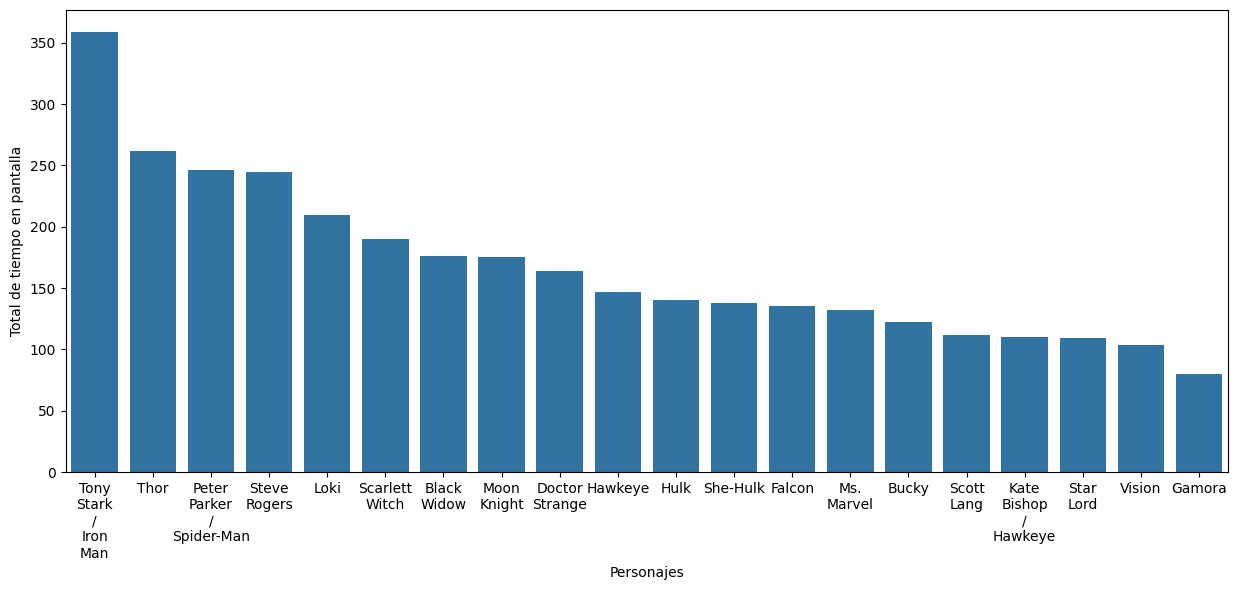

In [21]:
data = char_movie_matrix.head(20)
plt.figure(figsize=(15, 6))
data['Personajes'] = list(map(lambda x: '\n'.join(x.split(' ')),data.index))
sns.barplot(x='Personajes', y='Total de tiempo en pantalla', data=data);
apariciones_pj = OrderedDict()
for pj in char_movie_matrix.index:
    columnas_no_cero = char_movie_matrix.loc[pj, (char_movie_matrix.loc[pj] != 0) & (char_movie_matrix.loc[pj].apply(isinstance, args=(float,)))].index.tolist()
    apariciones_pj[pj]=columnas_no_cero[0:-1]


for i in apariciones_pj.keys():
    if re.match(r'.*Sara.*',i):
        print (i,apariciones_pj[i])
from itertools import islice
ordenado_por_longitud = OrderedDict(sorted(apariciones_pj.items(), key=lambda x: len(x[1]), reverse=True))

# Mostrar el resultado
for clave, valor in islice(ordenado_por_longitud.items(), 4):
    print(f'{clave}: {(valor)}')
claves = list(ordenado_por_longitud.keys())[:15]

longitudes = [len(ordenado_por_longitud[clave]) for clave in claves]
claves = list(map(lambda x: '\n'.join(x.split(' ')),claves))

# Crear el gráfico de barras
plt.figure(figsize=(15, 6))
plt.bar(claves, longitudes)

# Añadir etiquetas y título
plt.xlabel('Personajes')
plt.ylabel('nº de peliculas')
plt.title('nº total de peliculas en las que aparecen los personajes');
char_movie_matrix[char_movie_matrix['Spider-Man: Homecoming'] != 0]['Spider-Man: Homecoming'].sort_values(ascending=False)
def grafico_char_tiempo_pelicula (pelicula):
    data = pd.DataFrame(char_movie_matrix[char_movie_matrix[pelicula] != 0][pelicula].sort_values(ascending=False))
    plt.figure(figsize=(15, 6))
    data['Personajes'] = list(map(lambda x: '\n'.join(x.split(' ')),data.index))
    sns.barplot(x='Personajes', y=pelicula, data=data)

grafico_char_tiempo_pelicula ('Spider-Man: No Way Home')

def grafico_peliculas_del_char (char):
    peliculas = {}
    for peli in apariciones_pj[char]:
        peliculas[peli] = char_movie_matrix.loc[char][peli]
    plt.figure(figsize=(20, 6))
    pelis = list(map(lambda x: '\n'.join(x.split(' ')),list(peliculas.keys())))
    sns.barplot(x=pelis, y=list(peliculas.values()))
    plt.title(char)
    plt.xlabel('Peliculas')
    plt.ylabel('Tiempo en pantalla');

grafico_peliculas_del_char ('Valkyrie')

columna_tiempo_total_peliculas_char = []
for char in char_movie_matrix.index:
    tiempo_total_peliculas_char = 0
    for peli in apariciones_pj[char]:
        tiempo_total_peliculas_char += float(movie_lengths[peli])
    columna_tiempo_total_peliculas_char.append(tiempo_total_peliculas_char)

columna_porcentage_tiempo_pantalla = []
suma_tiempos = list(dict(char_movie_matrix['Total de tiempo en pantalla']).values())
for i in range(len(columna_tiempo_total_peliculas_char)):
    columna_porcentage_tiempo_pantalla.append((suma_tiempos[i]/columna_tiempo_total_peliculas_char[i])*100)
columna_porcentage_tiempo_pantalla
nueva_fila = pd.DataFrame([movie_lengths])
nueva_fila = convert_time_to_mins(nueva_fila)
nuevo_df = (char_movie_matrix.iloc[:, :-1].div(nueva_fila.iloc[0]))*100
nuevo_df
def grafico_pie_t_pantalla (pelicula):    
    df = char_movie_matrix[char_movie_matrix[pelicula] != 0]
    pie1 = df[pelicula]
    pie1_list = list(pie1.values)
    pie1_list = [round(each,2) for each in pie1_list]
    labels = df.index

    # Figure
    fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'pie'}]])

    fig.add_trace(
        go.Pie(
            labels=labels,
            values=pie1_list,
            textinfo='value',
            hoverinfo="label+value",
            hole=0.3,
        ),
        row=1, col=1
        
    )

    fig.update_layout(
        title="Tiempo en pantalla en " + pelicula + ' (' + movie_lengths[pelicula] +')',
        annotations=[
            {
                "font": {"size": 20},
                "showarrow": False,
                "text": pelicula,
                "x": 0.5,
                "y": 1.07,
            }
        ],
        height=700,  # Ajusta la altura del gráfico
        width=900,   # Ajusta el ancho del gráfico
    )

    fig.show()

grafico_pie_t_pantalla('Ojo de Halcón')

In [22]:
apariciones_pj = OrderedDict()
for pj in char_movie_matrix.index:
    columnas_no_cero = char_movie_matrix.loc[pj, (char_movie_matrix.loc[pj] != 0) & (char_movie_matrix.loc[pj].apply(isinstance, args=(float,)))].index.tolist()
    apariciones_pj[pj]=columnas_no_cero[0:-1]


for i in apariciones_pj.keys():
    if re.match(r'.*Sara.*',i):
        print (i,apariciones_pj[i])
from itertools import islice
ordenado_por_longitud = OrderedDict(sorted(apariciones_pj.items(), key=lambda x: len(x[1]), reverse=True))

# Mostrar el resultado
for clave, valor in islice(ordenado_por_longitud.items(), 4):
    print(f'{clave}: {(valor)}')
claves = list(ordenado_por_longitud.keys())[:15]

longitudes = [len(ordenado_por_longitud[clave]) for clave in claves]
claves = list(map(lambda x: '\n'.join(x.split(' ')),claves))

# Crear el gráfico de barras
plt.figure(figsize=(15, 6))
plt.bar(claves, longitudes)

# Añadir etiquetas y título
plt.xlabel('Personajes')
plt.ylabel('nº de peliculas')
plt.title('nº total de peliculas en las que aparecen los personajes');
char_movie_matrix[char_movie_matrix['Spider-Man: Homecoming'] != 0]['Spider-Man: Homecoming'].sort_values(ascending=False)
def grafico_char_tiempo_pelicula (pelicula):
    data = pd.DataFrame(char_movie_matrix[char_movie_matrix[pelicula] != 0][pelicula].sort_values(ascending=False))
    plt.figure(figsize=(15, 6))
    data['Personajes'] = list(map(lambda x: '\n'.join(x.split(' ')),data.index))
    sns.barplot(x='Personajes', y=pelicula, data=data)

grafico_char_tiempo_pelicula ('Spider-Man: No Way Home')

def grafico_peliculas_del_char (char):
    peliculas = {}
    for peli in apariciones_pj[char]:
        peliculas[peli] = char_movie_matrix.loc[char][peli]
    plt.figure(figsize=(20, 6))
    pelis = list(map(lambda x: '\n'.join(x.split(' ')),list(peliculas.keys())))
    sns.barplot(x=pelis, y=list(peliculas.values()))
    plt.title(char)
    plt.xlabel('Peliculas')
    plt.ylabel('Tiempo en pantalla');

grafico_peliculas_del_char ('Valkyrie')

columna_tiempo_total_peliculas_char = []
for char in char_movie_matrix.index:
    tiempo_total_peliculas_char = 0
    for peli in apariciones_pj[char]:
        tiempo_total_peliculas_char += float(movie_lengths[peli])
    columna_tiempo_total_peliculas_char.append(tiempo_total_peliculas_char)

columna_porcentage_tiempo_pantalla = []
suma_tiempos = list(dict(char_movie_matrix['Total de tiempo en pantalla']).values())
for i in range(len(columna_tiempo_total_peliculas_char)):
    columna_porcentage_tiempo_pantalla.append((suma_tiempos[i]/columna_tiempo_total_peliculas_char[i])*100)
columna_porcentage_tiempo_pantalla
nueva_fila = pd.DataFrame([movie_lengths])
nueva_fila = convert_time_to_mins(nueva_fila)
nuevo_df = (char_movie_matrix.iloc[:, :-1].div(nueva_fila.iloc[0]))*100
nuevo_df
def grafico_pie_t_pantalla (pelicula):    
    df = char_movie_matrix[char_movie_matrix[pelicula] != 0]
    pie1 = df[pelicula]
    pie1_list = list(pie1.values)
    pie1_list = [round(each,2) for each in pie1_list]
    labels = df.index

    # Figure
    fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'pie'}]])

    fig.add_trace(
        go.Pie(
            labels=labels,
            values=pie1_list,
            textinfo='value',
            hoverinfo="label+value",
            hole=0.3,
        ),
        row=1, col=1
        
    )

    fig.update_layout(
        title="Tiempo en pantalla en " + pelicula + ' (' + movie_lengths[pelicula] +')',
        annotations=[
            {
                "font": {"size": 20},
                "showarrow": False,
                "text": pelicula,
                "x": 0.5,
                "y": 1.07,
            }
        ],
        height=700,  # Ajusta la altura del gráfico
        width=900,   # Ajusta el ancho del gráfico
    )

    fig.show()

grafico_pie_t_pantalla('Ojo de Halcón')

In [23]:
for i in apariciones_pj.keys():
    if re.match(r'.*Sara.*',i):
        print (i,apariciones_pj[i])
from itertools import islice
ordenado_por_longitud = OrderedDict(sorted(apariciones_pj.items(), key=lambda x: len(x[1]), reverse=True))

# Mostrar el resultado
for clave, valor in islice(ordenado_por_longitud.items(), 4):
    print(f'{clave}: {(valor)}')
claves = list(ordenado_por_longitud.keys())[:15]

longitudes = [len(ordenado_por_longitud[clave]) for clave in claves]
claves = list(map(lambda x: '\n'.join(x.split(' ')),claves))

# Crear el gráfico de barras
plt.figure(figsize=(15, 6))
plt.bar(claves, longitudes)

# Añadir etiquetas y título
plt.xlabel('Personajes')
plt.ylabel('nº de peliculas')
plt.title('nº total de peliculas en las que aparecen los personajes');
char_movie_matrix[char_movie_matrix['Spider-Man: Homecoming'] != 0]['Spider-Man: Homecoming'].sort_values(ascending=False)
def grafico_char_tiempo_pelicula (pelicula):
    data = pd.DataFrame(char_movie_matrix[char_movie_matrix[pelicula] != 0][pelicula].sort_values(ascending=False))
    plt.figure(figsize=(15, 6))
    data['Personajes'] = list(map(lambda x: '\n'.join(x.split(' ')),data.index))
    sns.barplot(x='Personajes', y=pelicula, data=data)

grafico_char_tiempo_pelicula ('Spider-Man: No Way Home')

def grafico_peliculas_del_char (char):
    peliculas = {}
    for peli in apariciones_pj[char]:
        peliculas[peli] = char_movie_matrix.loc[char][peli]
    plt.figure(figsize=(20, 6))
    pelis = list(map(lambda x: '\n'.join(x.split(' ')),list(peliculas.keys())))
    sns.barplot(x=pelis, y=list(peliculas.values()))
    plt.title(char)
    plt.xlabel('Peliculas')
    plt.ylabel('Tiempo en pantalla');

grafico_peliculas_del_char ('Valkyrie')

columna_tiempo_total_peliculas_char = []
for char in char_movie_matrix.index:
    tiempo_total_peliculas_char = 0
    for peli in apariciones_pj[char]:
        tiempo_total_peliculas_char += float(movie_lengths[peli])
    columna_tiempo_total_peliculas_char.append(tiempo_total_peliculas_char)

columna_porcentage_tiempo_pantalla = []
suma_tiempos = list(dict(char_movie_matrix['Total de tiempo en pantalla']).values())
for i in range(len(columna_tiempo_total_peliculas_char)):
    columna_porcentage_tiempo_pantalla.append((suma_tiempos[i]/columna_tiempo_total_peliculas_char[i])*100)
columna_porcentage_tiempo_pantalla
nueva_fila = pd.DataFrame([movie_lengths])
nueva_fila = convert_time_to_mins(nueva_fila)
nuevo_df = (char_movie_matrix.iloc[:, :-1].div(nueva_fila.iloc[0]))*100
nuevo_df
def grafico_pie_t_pantalla (pelicula):    
    df = char_movie_matrix[char_movie_matrix[pelicula] != 0]
    pie1 = df[pelicula]
    pie1_list = list(pie1.values)
    pie1_list = [round(each,2) for each in pie1_list]
    labels = df.index

    # Figure
    fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'pie'}]])

    fig.add_trace(
        go.Pie(
            labels=labels,
            values=pie1_list,
            textinfo='value',
            hoverinfo="label+value",
            hole=0.3,
        ),
        row=1, col=1
        
    )

    fig.update_layout(
        title="Tiempo en pantalla en " + pelicula + ' (' + movie_lengths[pelicula] +')',
        annotations=[
            {
                "font": {"size": 20},
                "showarrow": False,
                "text": pelicula,
                "x": 0.5,
                "y": 1.07,
            }
        ],
        height=700,  # Ajusta la altura del gráfico
        width=900,   # Ajusta el ancho del gráfico
    )

    fig.show()

grafico_pie_t_pantalla('Ojo de Halcón')

Sarah Wilson ['Falcon y el Soldado de Invierno']
Sarah Proctor / "Dottie" ['Bruja Escarlata y Visión']
Sara ['Doctor Strange en el multiverso de la locura']


In [24]:
from itertools import islice
ordenado_por_longitud = OrderedDict(sorted(apariciones_pj.items(), key=lambda x: len(x[1]), reverse=True))

# Mostrar el resultado
for clave, valor in islice(ordenado_por_longitud.items(), 4):
    print(f'{clave}: {(valor)}')
claves = list(ordenado_por_longitud.keys())[:15]

longitudes = [len(ordenado_por_longitud[clave]) for clave in claves]
claves = list(map(lambda x: '\n'.join(x.split(' ')),claves))

# Crear el gráfico de barras
plt.figure(figsize=(15, 6))
plt.bar(claves, longitudes)

# Añadir etiquetas y título
plt.xlabel('Personajes')
plt.ylabel('nº de peliculas')
plt.title('nº total de peliculas en las que aparecen los personajes');
char_movie_matrix[char_movie_matrix['Spider-Man: Homecoming'] != 0]['Spider-Man: Homecoming'].sort_values(ascending=False)
def grafico_char_tiempo_pelicula (pelicula):
    data = pd.DataFrame(char_movie_matrix[char_movie_matrix[pelicula] != 0][pelicula].sort_values(ascending=False))
    plt.figure(figsize=(15, 6))
    data['Personajes'] = list(map(lambda x: '\n'.join(x.split(' ')),data.index))
    sns.barplot(x='Personajes', y=pelicula, data=data)

grafico_char_tiempo_pelicula ('Spider-Man: No Way Home')

def grafico_peliculas_del_char (char):
    peliculas = {}
    for peli in apariciones_pj[char]:
        peliculas[peli] = char_movie_matrix.loc[char][peli]
    plt.figure(figsize=(20, 6))
    pelis = list(map(lambda x: '\n'.join(x.split(' ')),list(peliculas.keys())))
    sns.barplot(x=pelis, y=list(peliculas.values()))
    plt.title(char)
    plt.xlabel('Peliculas')
    plt.ylabel('Tiempo en pantalla');

grafico_peliculas_del_char ('Valkyrie')

columna_tiempo_total_peliculas_char = []
for char in char_movie_matrix.index:
    tiempo_total_peliculas_char = 0
    for peli in apariciones_pj[char]:
        tiempo_total_peliculas_char += float(movie_lengths[peli])
    columna_tiempo_total_peliculas_char.append(tiempo_total_peliculas_char)

columna_porcentage_tiempo_pantalla = []
suma_tiempos = list(dict(char_movie_matrix['Total de tiempo en pantalla']).values())
for i in range(len(columna_tiempo_total_peliculas_char)):
    columna_porcentage_tiempo_pantalla.append((suma_tiempos[i]/columna_tiempo_total_peliculas_char[i])*100)
columna_porcentage_tiempo_pantalla
nueva_fila = pd.DataFrame([movie_lengths])
nueva_fila = convert_time_to_mins(nueva_fila)
nuevo_df = (char_movie_matrix.iloc[:, :-1].div(nueva_fila.iloc[0]))*100
nuevo_df
def grafico_pie_t_pantalla (pelicula):    
    df = char_movie_matrix[char_movie_matrix[pelicula] != 0]
    pie1 = df[pelicula]
    pie1_list = list(pie1.values)
    pie1_list = [round(each,2) for each in pie1_list]
    labels = df.index

    # Figure
    fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'pie'}]])

    fig.add_trace(
        go.Pie(
            labels=labels,
            values=pie1_list,
            textinfo='value',
            hoverinfo="label+value",
            hole=0.3,
        ),
        row=1, col=1
        
    )

    fig.update_layout(
        title="Tiempo en pantalla en " + pelicula + ' (' + movie_lengths[pelicula] +')',
        annotations=[
            {
                "font": {"size": 20},
                "showarrow": False,
                "text": pelicula,
                "x": 0.5,
                "y": 1.07,
            }
        ],
        height=700,  # Ajusta la altura del gráfico
        width=900,   # Ajusta el ancho del gráfico
    )

    fig.show()

grafico_pie_t_pantalla('Ojo de Halcón')

Tony Stark / Iron Man: ['Iron Man', 'El increíble Hulk', 'Iron Man 2', 'Los Vengadores', 'Iron Man 3', 'Vengadores: La era de Ultrón', 'Capitán América: Civil War', 'Spider-Man: Homecoming', 'Vengadores: Infinity War', 'Vengadores: Endgame', 'Spider-Man: Lejos de casa', 'Loki']
Steve Rogers: ['Capitán América: El primer vengador', 'Los Vengadores', 'Marvel One-Shot: Agente Carter', 'Capitán América: El Soldado de Invierno', 'Vengadores: La era de Ultrón', 'Ant-Man', 'Capitán América: Civil War', 'Spider-Man: Homecoming', 'Vengadores: Infinity War', 'Capitana Marvel', 'Vengadores: Endgame', 'Loki']
Black Widow: ['Iron Man 2', 'Los Vengadores', 'Capitán América: El Soldado de Invierno', 'Vengadores: La era de Ultrón', 'Capitán América: Civil War', 'Thor: Ragnarok', 'Vengadores: Infinity War', 'Capitana Marvel', 'Vengadores: Endgame', 'Loki', 'Viuda Negra']
Nick Fury: ['Iron Man', 'Iron Man 2', 'Thor', 'Capitán América: El primer vengador', 'Los Vengadores', 'Capitán América: El Soldado d

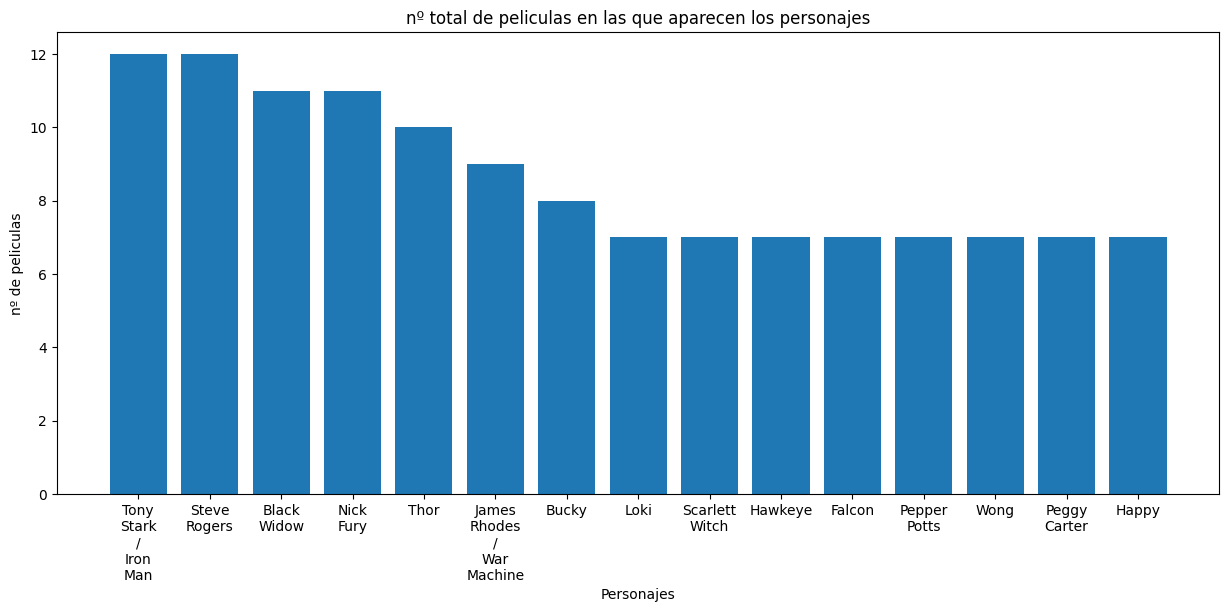

In [25]:
claves = list(ordenado_por_longitud.keys())[:15]

longitudes = [len(ordenado_por_longitud[clave]) for clave in claves]
claves = list(map(lambda x: '\n'.join(x.split(' ')),claves))

# Crear el gráfico de barras
plt.figure(figsize=(15, 6))
plt.bar(claves, longitudes)

# Añadir etiquetas y título
plt.xlabel('Personajes')
plt.ylabel('nº de peliculas')
plt.title('nº total de peliculas en las que aparecen los personajes');
char_movie_matrix[char_movie_matrix['Spider-Man: Homecoming'] != 0]['Spider-Man: Homecoming'].sort_values(ascending=False)
def grafico_char_tiempo_pelicula (pelicula):
    data = pd.DataFrame(char_movie_matrix[char_movie_matrix[pelicula] != 0][pelicula].sort_values(ascending=False))
    plt.figure(figsize=(15, 6))
    data['Personajes'] = list(map(lambda x: '\n'.join(x.split(' ')),data.index))
    sns.barplot(x='Personajes', y=pelicula, data=data)

grafico_char_tiempo_pelicula ('Spider-Man: No Way Home')

def grafico_peliculas_del_char (char):
    peliculas = {}
    for peli in apariciones_pj[char]:
        peliculas[peli] = char_movie_matrix.loc[char][peli]
    plt.figure(figsize=(20, 6))
    pelis = list(map(lambda x: '\n'.join(x.split(' ')),list(peliculas.keys())))
    sns.barplot(x=pelis, y=list(peliculas.values()))
    plt.title(char)
    plt.xlabel('Peliculas')
    plt.ylabel('Tiempo en pantalla');

grafico_peliculas_del_char ('Valkyrie')

columna_tiempo_total_peliculas_char = []
for char in char_movie_matrix.index:
    tiempo_total_peliculas_char = 0
    for peli in apariciones_pj[char]:
        tiempo_total_peliculas_char += float(movie_lengths[peli])
    columna_tiempo_total_peliculas_char.append(tiempo_total_peliculas_char)

columna_porcentage_tiempo_pantalla = []
suma_tiempos = list(dict(char_movie_matrix['Total de tiempo en pantalla']).values())
for i in range(len(columna_tiempo_total_peliculas_char)):
    columna_porcentage_tiempo_pantalla.append((suma_tiempos[i]/columna_tiempo_total_peliculas_char[i])*100)
columna_porcentage_tiempo_pantalla
nueva_fila = pd.DataFrame([movie_lengths])
nueva_fila = convert_time_to_mins(nueva_fila)
nuevo_df = (char_movie_matrix.iloc[:, :-1].div(nueva_fila.iloc[0]))*100
nuevo_df
def grafico_pie_t_pantalla (pelicula):    
    df = char_movie_matrix[char_movie_matrix[pelicula] != 0]
    pie1 = df[pelicula]
    pie1_list = list(pie1.values)
    pie1_list = [round(each,2) for each in pie1_list]
    labels = df.index

    # Figure
    fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'pie'}]])

    fig.add_trace(
        go.Pie(
            labels=labels,
            values=pie1_list,
            textinfo='value',
            hoverinfo="label+value",
            hole=0.3,
        ),
        row=1, col=1
        
    )

    fig.update_layout(
        title="Tiempo en pantalla en " + pelicula + ' (' + movie_lengths[pelicula] +')',
        annotations=[
            {
                "font": {"size": 20},
                "showarrow": False,
                "text": pelicula,
                "x": 0.5,
                "y": 1.07,
            }
        ],
        height=700,  # Ajusta la altura del gráfico
        width=900,   # Ajusta el ancho del gráfico
    )

    fig.show()

grafico_pie_t_pantalla('Ojo de Halcón')

In [26]:
char_movie_matrix[char_movie_matrix['Spider-Man: Homecoming'] != 0]['Spider-Man: Homecoming'].sort_values(ascending=False)
def grafico_char_tiempo_pelicula (pelicula):
    data = pd.DataFrame(char_movie_matrix[char_movie_matrix[pelicula] != 0][pelicula].sort_values(ascending=False))
    plt.figure(figsize=(15, 6))
    data['Personajes'] = list(map(lambda x: '\n'.join(x.split(' ')),data.index))
    sns.barplot(x='Personajes', y=pelicula, data=data)

grafico_char_tiempo_pelicula ('Spider-Man: No Way Home')

def grafico_peliculas_del_char (char):
    peliculas = {}
    for peli in apariciones_pj[char]:
        peliculas[peli] = char_movie_matrix.loc[char][peli]
    plt.figure(figsize=(20, 6))
    pelis = list(map(lambda x: '\n'.join(x.split(' ')),list(peliculas.keys())))
    sns.barplot(x=pelis, y=list(peliculas.values()))
    plt.title(char)
    plt.xlabel('Peliculas')
    plt.ylabel('Tiempo en pantalla');

grafico_peliculas_del_char ('Valkyrie')

columna_tiempo_total_peliculas_char = []
for char in char_movie_matrix.index:
    tiempo_total_peliculas_char = 0
    for peli in apariciones_pj[char]:
        tiempo_total_peliculas_char += float(movie_lengths[peli])
    columna_tiempo_total_peliculas_char.append(tiempo_total_peliculas_char)

columna_porcentage_tiempo_pantalla = []
suma_tiempos = list(dict(char_movie_matrix['Total de tiempo en pantalla']).values())
for i in range(len(columna_tiempo_total_peliculas_char)):
    columna_porcentage_tiempo_pantalla.append((suma_tiempos[i]/columna_tiempo_total_peliculas_char[i])*100)
columna_porcentage_tiempo_pantalla
nueva_fila = pd.DataFrame([movie_lengths])
nueva_fila = convert_time_to_mins(nueva_fila)
nuevo_df = (char_movie_matrix.iloc[:, :-1].div(nueva_fila.iloc[0]))*100
nuevo_df
def grafico_pie_t_pantalla (pelicula):    
    df = char_movie_matrix[char_movie_matrix[pelicula] != 0]
    pie1 = df[pelicula]
    pie1_list = list(pie1.values)
    pie1_list = [round(each,2) for each in pie1_list]
    labels = df.index

    # Figure
    fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'pie'}]])

    fig.add_trace(
        go.Pie(
            labels=labels,
            values=pie1_list,
            textinfo='value',
            hoverinfo="label+value",
            hole=0.3,
        ),
        row=1, col=1
        
    )

    fig.update_layout(
        title="Tiempo en pantalla en " + pelicula + ' (' + movie_lengths[pelicula] +')',
        annotations=[
            {
                "font": {"size": 20},
                "showarrow": False,
                "text": pelicula,
                "x": 0.5,
                "y": 1.07,
            }
        ],
        height=700,  # Ajusta la altura del gráfico
        width=900,   # Ajusta el ancho del gráfico
    )

    fig.show()

grafico_pie_t_pantalla('Ojo de Halcón')

Peter Parker / Spider-Man       76.25
Vulture                         19.00
Ned Leeds                       13.75
Liz Toomes                       9.75
Tony Stark / Iron Man            8.00
Happy                            6.00
Herman Schultz / The Shocker     4.50
Aunt May                         4.00
Phineas Mason / Tinkerer         3.75
MJ                               2.75
Aaron Davis                      2.50
Flash Thompson                   2.25
Roger Harrington                 2.00
Mac Gargan                       1.25
Betty Brant                      1.25
Jason Ionello                    1.00
Steve Rogers                     1.00
Ann Marie Hoag                   1.00
Pepper Potts                     0.75
Name: Spider-Man: Homecoming, dtype: float64

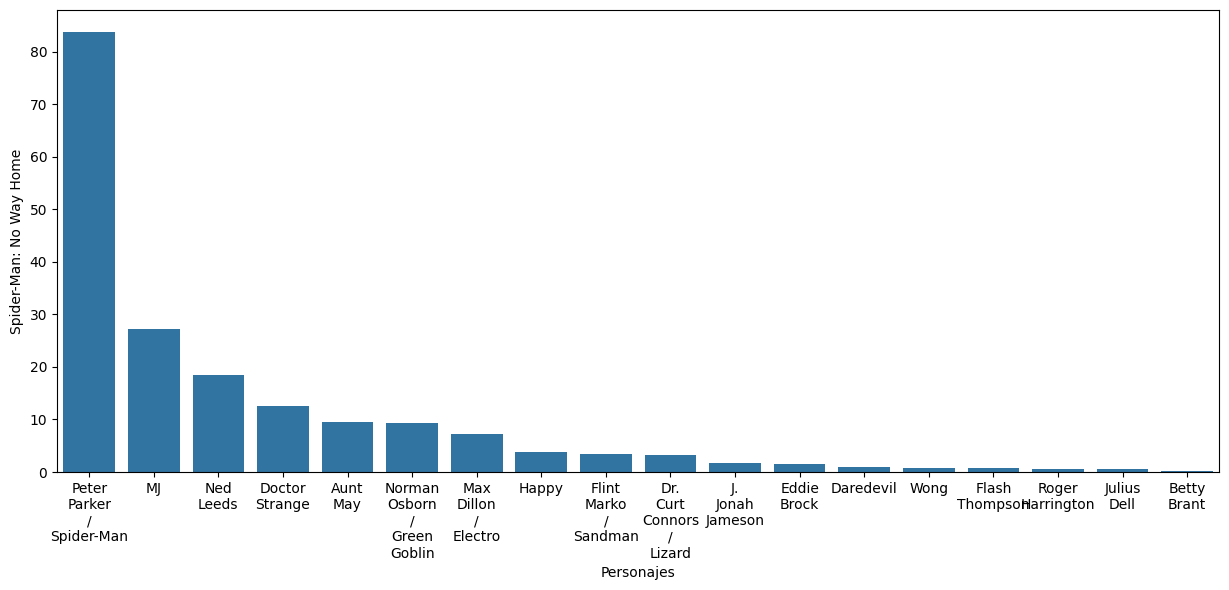

In [27]:
def grafico_char_tiempo_pelicula (pelicula):
    data = pd.DataFrame(char_movie_matrix[char_movie_matrix[pelicula] != 0][pelicula].sort_values(ascending=False))
    plt.figure(figsize=(15, 6))
    data['Personajes'] = list(map(lambda x: '\n'.join(x.split(' ')),data.index))
    sns.barplot(x='Personajes', y=pelicula, data=data)

grafico_char_tiempo_pelicula ('Spider-Man: No Way Home')

def grafico_peliculas_del_char (char):
    peliculas = {}
    for peli in apariciones_pj[char]:
        peliculas[peli] = char_movie_matrix.loc[char][peli]
    plt.figure(figsize=(20, 6))
    pelis = list(map(lambda x: '\n'.join(x.split(' ')),list(peliculas.keys())))
    sns.barplot(x=pelis, y=list(peliculas.values()))
    plt.title(char)
    plt.xlabel('Peliculas')
    plt.ylabel('Tiempo en pantalla');

grafico_peliculas_del_char ('Valkyrie')

columna_tiempo_total_peliculas_char = []
for char in char_movie_matrix.index:
    tiempo_total_peliculas_char = 0
    for peli in apariciones_pj[char]:
        tiempo_total_peliculas_char += float(movie_lengths[peli])
    columna_tiempo_total_peliculas_char.append(tiempo_total_peliculas_char)

columna_porcentage_tiempo_pantalla = []
suma_tiempos = list(dict(char_movie_matrix['Total de tiempo en pantalla']).values())
for i in range(len(columna_tiempo_total_peliculas_char)):
    columna_porcentage_tiempo_pantalla.append((suma_tiempos[i]/columna_tiempo_total_peliculas_char[i])*100)
columna_porcentage_tiempo_pantalla
nueva_fila = pd.DataFrame([movie_lengths])
nueva_fila = convert_time_to_mins(nueva_fila)
nuevo_df = (char_movie_matrix.iloc[:, :-1].div(nueva_fila.iloc[0]))*100
nuevo_df
def grafico_pie_t_pantalla (pelicula):    
    df = char_movie_matrix[char_movie_matrix[pelicula] != 0]
    pie1 = df[pelicula]
    pie1_list = list(pie1.values)
    pie1_list = [round(each,2) for each in pie1_list]
    labels = df.index

    # Figure
    fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'pie'}]])

    fig.add_trace(
        go.Pie(
            labels=labels,
            values=pie1_list,
            textinfo='value',
            hoverinfo="label+value",
            hole=0.3,
        ),
        row=1, col=1
        
    )

    fig.update_layout(
        title="Tiempo en pantalla en " + pelicula + ' (' + movie_lengths[pelicula] +')',
        annotations=[
            {
                "font": {"size": 20},
                "showarrow": False,
                "text": pelicula,
                "x": 0.5,
                "y": 1.07,
            }
        ],
        height=700,  # Ajusta la altura del gráfico
        width=900,   # Ajusta el ancho del gráfico
    )

    fig.show()

grafico_pie_t_pantalla('Ojo de Halcón')

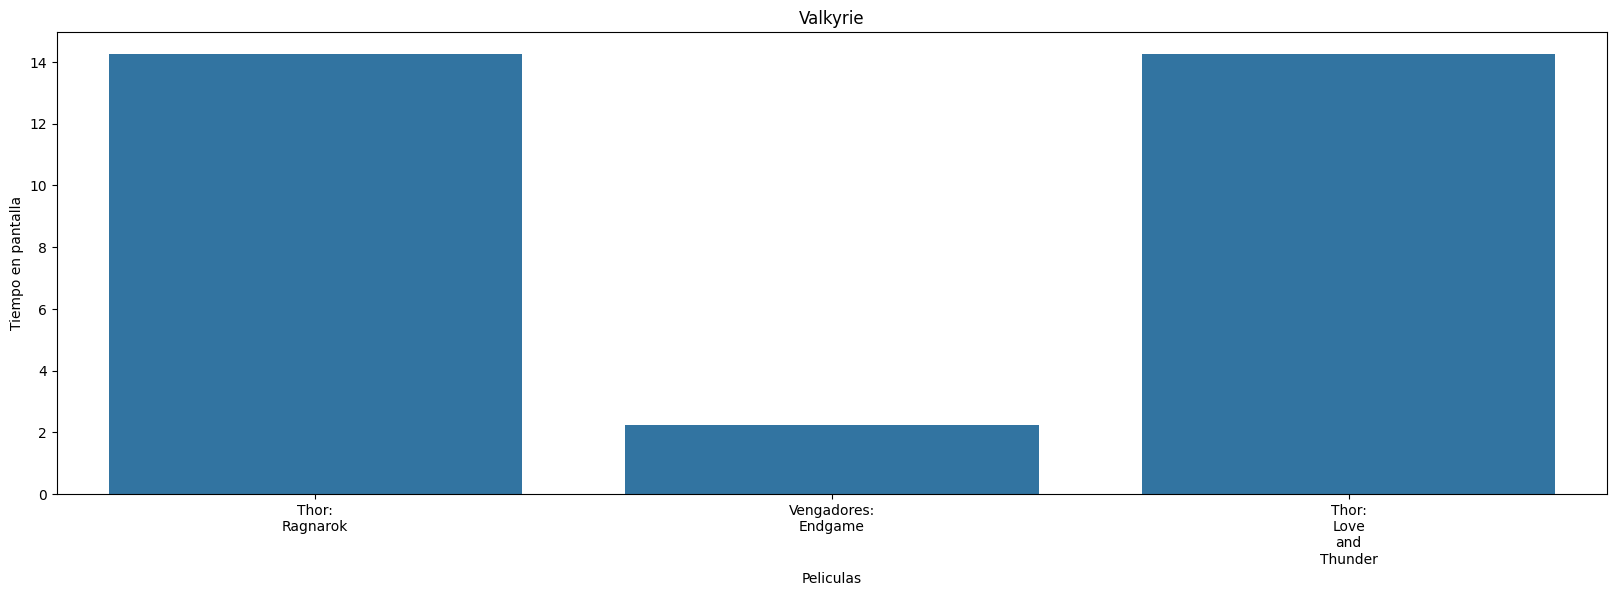

In [28]:
def grafico_peliculas_del_char (char):
    peliculas = {}
    for peli in apariciones_pj[char]:
        peliculas[peli] = char_movie_matrix.loc[char][peli]
    plt.figure(figsize=(20, 6))
    pelis = list(map(lambda x: '\n'.join(x.split(' ')),list(peliculas.keys())))
    sns.barplot(x=pelis, y=list(peliculas.values()))
    plt.title(char)
    plt.xlabel('Peliculas')
    plt.ylabel('Tiempo en pantalla');

grafico_peliculas_del_char ('Valkyrie')

columna_tiempo_total_peliculas_char = []
for char in char_movie_matrix.index:
    tiempo_total_peliculas_char = 0
    for peli in apariciones_pj[char]:
        tiempo_total_peliculas_char += float(movie_lengths[peli])
    columna_tiempo_total_peliculas_char.append(tiempo_total_peliculas_char)

columna_porcentage_tiempo_pantalla = []
suma_tiempos = list(dict(char_movie_matrix['Total de tiempo en pantalla']).values())
for i in range(len(columna_tiempo_total_peliculas_char)):
    columna_porcentage_tiempo_pantalla.append((suma_tiempos[i]/columna_tiempo_total_peliculas_char[i])*100)
columna_porcentage_tiempo_pantalla
nueva_fila = pd.DataFrame([movie_lengths])
nueva_fila = convert_time_to_mins(nueva_fila)
nuevo_df = (char_movie_matrix.iloc[:, :-1].div(nueva_fila.iloc[0]))*100
nuevo_df
def grafico_pie_t_pantalla (pelicula):    
    df = char_movie_matrix[char_movie_matrix[pelicula] != 0]
    pie1 = df[pelicula]
    pie1_list = list(pie1.values)
    pie1_list = [round(each,2) for each in pie1_list]
    labels = df.index

    # Figure
    fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'pie'}]])

    fig.add_trace(
        go.Pie(
            labels=labels,
            values=pie1_list,
            textinfo='value',
            hoverinfo="label+value",
            hole=0.3,
        ),
        row=1, col=1
        
    )

    fig.update_layout(
        title="Tiempo en pantalla en " + pelicula + ' (' + movie_lengths[pelicula] +')',
        annotations=[
            {
                "font": {"size": 20},
                "showarrow": False,
                "text": pelicula,
                "x": 0.5,
                "y": 1.07,
            }
        ],
        height=700,  # Ajusta la altura del gráfico
        width=900,   # Ajusta el ancho del gráfico
    )

    fig.show()

grafico_pie_t_pantalla('Ojo de Halcón')

In [29]:
columna_tiempo_total_peliculas_char = []
for char in char_movie_matrix.index:
    tiempo_total_peliculas_char = 0
    for peli in apariciones_pj[char]:
        tiempo_total_peliculas_char += float(movie_lengths[peli])
    columna_tiempo_total_peliculas_char.append(tiempo_total_peliculas_char)

columna_porcentage_tiempo_pantalla = []
suma_tiempos = list(dict(char_movie_matrix['Total de tiempo en pantalla']).values())
for i in range(len(columna_tiempo_total_peliculas_char)):
    columna_porcentage_tiempo_pantalla.append((suma_tiempos[i]/columna_tiempo_total_peliculas_char[i])*100)
columna_porcentage_tiempo_pantalla
nueva_fila = pd.DataFrame([movie_lengths])
nueva_fila = convert_time_to_mins(nueva_fila)
nuevo_df = (char_movie_matrix.iloc[:, :-1].div(nueva_fila.iloc[0]))*100
nuevo_df
def grafico_pie_t_pantalla (pelicula):    
    df = char_movie_matrix[char_movie_matrix[pelicula] != 0]
    pie1 = df[pelicula]
    pie1_list = list(pie1.values)
    pie1_list = [round(each,2) for each in pie1_list]
    labels = df.index

    # Figure
    fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'pie'}]])

    fig.add_trace(
        go.Pie(
            labels=labels,
            values=pie1_list,
            textinfo='value',
            hoverinfo="label+value",
            hole=0.3,
        ),
        row=1, col=1
        
    )

    fig.update_layout(
        title="Tiempo en pantalla en " + pelicula + ' (' + movie_lengths[pelicula] +')',
        annotations=[
            {
                "font": {"size": 20},
                "showarrow": False,
                "text": pelicula,
                "x": 0.5,
                "y": 1.07,
            }
        ],
        height=700,  # Ajusta la altura del gráfico
        width=900,   # Ajusta el ancho del gráfico
    )

    fig.show()

grafico_pie_t_pantalla('Ojo de Halcón')

In [30]:

columna_porcentage_tiempo_pantalla = []
suma_tiempos = list(dict(char_movie_matrix['Total de tiempo en pantalla']).values())
for i in range(len(columna_tiempo_total_peliculas_char)):
    columna_porcentage_tiempo_pantalla.append((suma_tiempos[i]/columna_tiempo_total_peliculas_char[i])*100)
columna_porcentage_tiempo_pantalla
nueva_fila = pd.DataFrame([movie_lengths])
nueva_fila = convert_time_to_mins(nueva_fila)
nuevo_df = (char_movie_matrix.iloc[:, :-1].div(nueva_fila.iloc[0]))*100
nuevo_df
def grafico_pie_t_pantalla (pelicula):    
    df = char_movie_matrix[char_movie_matrix[pelicula] != 0]
    pie1 = df[pelicula]
    pie1_list = list(pie1.values)
    pie1_list = [round(each,2) for each in pie1_list]
    labels = df.index

    # Figure
    fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'pie'}]])

    fig.add_trace(
        go.Pie(
            labels=labels,
            values=pie1_list,
            textinfo='value',
            hoverinfo="label+value",
            hole=0.3,
        ),
        row=1, col=1
        
    )

    fig.update_layout(
        title="Tiempo en pantalla en " + pelicula + ' (' + movie_lengths[pelicula] +')',
        annotations=[
            {
                "font": {"size": 20},
                "showarrow": False,
                "text": pelicula,
                "x": 0.5,
                "y": 1.07,
            }
        ],
        height=700,  # Ajusta la altura del gráfico
        width=900,   # Ajusta el ancho del gráfico
    )

    fig.show()

grafico_pie_t_pantalla('Ojo de Halcón')

[17.075202284626368,
 14.63687150837989,
 27.762119503945886,
 12.268170426065163,
 14.812853107344633,
 15.447154471544716,
 8.83901705115346,
 61.14982578397212,
 19.287396937573618,
 8.88317191283293,
 16.384345794392523,
 47.66435986159169,
 11.52860802732707,
 48.61623616236162,
 9.510869565217392,
 19.849023090586147,
 32.52212389380531,
 14.65863453815261,
 13.15120711562897,
 13.58603066439523,
 14.353612167300382,
 12.5,
 10.113154172560112,
 7.074036511156187,
 4.560697518443997,
 10.84,
 47.72727272727273,
 4.257565095003519,
 12.684989429175475,
 9.726962457337883,
 7.49665327978581,
 7.295850066934404,
 8.559999999999999,
 18.554006968641115,
 12.5,
 12.073170731707316,
 11.778846153846153,
 6.385135135135135,
 29.647435897435898,
 3.4065102195306585,
 8.985200845665963,
 13.588850174216027,
 5.053547523427041,
 13.745387453874539,
 12.333333333333334,
 10.285714285714285,
 3.1140350877192984,
 5.5910543130990416,
 22.115384615384613,
 5.319999999999999,
 8.042394014962593

In [31]:
nueva_fila = pd.DataFrame([movie_lengths])
nueva_fila = convert_time_to_mins(nueva_fila)
nuevo_df = (char_movie_matrix.iloc[:, :-1].div(nueva_fila.iloc[0]))*100
nuevo_df
def grafico_pie_t_pantalla (pelicula):    
    df = char_movie_matrix[char_movie_matrix[pelicula] != 0]
    pie1 = df[pelicula]
    pie1_list = list(pie1.values)
    pie1_list = [round(each,2) for each in pie1_list]
    labels = df.index

    # Figure
    fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'pie'}]])

    fig.add_trace(
        go.Pie(
            labels=labels,
            values=pie1_list,
            textinfo='value',
            hoverinfo="label+value",
            hole=0.3,
        ),
        row=1, col=1
        
    )

    fig.update_layout(
        title="Tiempo en pantalla en " + pelicula + ' (' + movie_lengths[pelicula] +')',
        annotations=[
            {
                "font": {"size": 20},
                "showarrow": False,
                "text": pelicula,
                "x": 0.5,
                "y": 1.07,
            }
        ],
        height=700,  # Ajusta la altura del gráfico
        width=900,   # Ajusta el ancho del gráfico
    )

    fig.show()

grafico_pie_t_pantalla('Ojo de Halcón')

In [32]:
nuevo_df
def grafico_pie_t_pantalla (pelicula):    
    df = char_movie_matrix[char_movie_matrix[pelicula] != 0]
    pie1 = df[pelicula]
    pie1_list = list(pie1.values)
    pie1_list = [round(each,2) for each in pie1_list]
    labels = df.index

    # Figure
    fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'pie'}]])

    fig.add_trace(
        go.Pie(
            labels=labels,
            values=pie1_list,
            textinfo='value',
            hoverinfo="label+value",
            hole=0.3,
        ),
        row=1, col=1
        
    )

    fig.update_layout(
        title="Tiempo en pantalla en " + pelicula + ' (' + movie_lengths[pelicula] +')',
        annotations=[
            {
                "font": {"size": 20},
                "showarrow": False,
                "text": pelicula,
                "x": 0.5,
                "y": 1.07,
            }
        ],
        height=700,  # Ajusta la altura del gráfico
        width=900,   # Ajusta el ancho del gráfico
    )

    fig.show()

grafico_pie_t_pantalla('Ojo de Halcón')

Iron Man El increíble Hulk Iron Man 2       Thor  \
Tony Stark / Iron Man      61.309524          0.446429  49.395161        0.0   
Thor                             0.0               0.0        0.0  37.608696   
Peter Parker / Spider-Man        0.0               0.0        0.0        0.0   
Steve Rogers                     0.0               0.0        0.0        0.0   
Loki                             0.0               0.0        0.0  18.478261   
...                              ...               ...        ...        ...   
Ulysses Bloodstone               0.0               0.0        0.0        0.0   
Daniel Drumm                     0.0               0.0        0.0        0.0   
Edwin Jarvis                     0.0               0.0        0.0        0.0   
Aleta Ogord                      0.0               0.0        0.0        0.0   
Darryl                           0.0               0.0        0.0        0.0   

                          Capitán América: El primer vengador Los Vengadores  \
Tony Stark / Iron Man                                     0.0      22.202797   
Thor                                                      0.0      12.587413   
Peter Parker / Spider-Man                                 0.0            0.0   
Steve Rogers                                        45.564516      19.755245   
Loki                                                      0.0      15.034965   
...                                                       ...            ...   
Ulysses Bloodstone                                        0.0            0.0   
Daniel Drumm                                              0.0            0.0   
Edwin Jarvis                                              0.0            0.0   
Aleta Ogord                                               0.0            0.0   
Darryl                                                    0.0            0.0   

                          Iron Man 3 Marvel One-Shot: Agente Carter  \
Tony Stark / Iron Man      47.884615                            0.0   
Thor                             0.0                            0.0   
Peter Parker / Spider-Man        0.0                            0.0   
Steve Rogers                     0.0                       1.666667   
Loki                             0.0                            0.0   
...                              ...                            ...   
Ulysses Bloodstone               0.0                            0.0   
Daniel Drumm                     0.0                            0.0   
Edwin Jarvis                     0.0                            0.0   
Aleta Ogord                      0.0                            0.0   
Darryl                           0.0                            0.0   

                          Thor: El mundo oscuro  \
Tony Stark / Iron Man                       0.0   
Thor                                      31.25   
Peter Parker / Spider-Man                   0.0   
Steve Rogers                                0.0   
Loki                                     15.625   
...                                         ...   
Ulysses Bloodstone                          0.0   
Daniel Drumm                                0.0   
Edwin Jarvis                                0.0   
Aleta Ogord                                 0.0   
Darryl                                      0.0   

                          Capitán América: El Soldado de Invierno  ...  \
Tony Stark / Iron Man                                         0.0  ...   
Thor                                                          0.0  ...   
Peter Parker / Spider-Man                                     0.0  ...   
Steve Rogers                                            43.382353  ...   
Loki                                                          0.0  ...   
...                                                           ...  ...   
Ulysses Bloodstone                                            0.0  ...   
Daniel Drumm                                    

In [39]:
def grafico_pie_t_pantalla (pelicula):    
    df = char_movie_matrix[char_movie_matrix[pelicula] != 0]
    pie1 = df[pelicula]
    pie1_list = list(pie1.values)
    pie1_list = [round(each,2) for each in pie1_list]
    labels = df.index

    # Figure
    fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'pie'}]])

    fig.add_trace(
        go.Pie(
            labels=labels,
            values=pie1_list,
            textinfo='value',
            hoverinfo="label+value",
            hole=0.3,
        ),
        row=1, col=1
        
    )

    fig.update_layout(
        title="Tiempo en pantalla en " + pelicula + ' (' + movie_lengths[pelicula] +')',
        annotations=[
            {
                "font": {"size": 20},
                "showarrow": False,
                "text": pelicula,
                "x": 0.5,
                "y": 1.07,
            }
        ],
        height=700,  # Ajusta la altura del gráfico
        width=900,   # Ajusta el ancho del gráfico
    )

    fig.show()

grafico_pie_t_pantalla('Ojo de Halcón')

In [41]:
list(char_movie_matrix.columns)

['Iron Man',
 'El increíble Hulk',
 'Iron Man 2',
 'Thor',
 'Capitán América: El primer vengador',
 'Los Vengadores',
 'Iron Man 3',
 'Marvel One-Shot: Agente Carter',
 'Thor: El mundo oscuro',
 'Capitán América: El Soldado de Invierno',
 'Guardianes de la Galaxia',
 'Vengadores: La era de Ultrón',
 'Ant-Man',
 'Capitán América: Civil War',
 'Doctor Strange. Doctor Extraño',
 'Guardianes de la Galaxia Vol. 2',
 'Spider-Man: Homecoming',
 'Thor: Ragnarok',
 'Black Panther',
 'Vengadores: Infinity War',
 'Ant-Man y la Avispa',
 'Capitana Marvel',
 'Vengadores: Endgame',
 'Spider-Man: Lejos de casa',
 'Bruja Escarlata y Visión',
 'Falcon y el Soldado de Invierno',
 'Loki',
 'Viuda Negra',
 'Shang-Chi y la leyenda de los diez anillos',
 'Eternals',
 'Ojo de Halcón',
 'Spider-Man: No Way Home',
 'Caballero Luna',
 'Doctor Strange en el multiverso de la locura',
 'Ms. Marvel',
 'Thor: Love and Thunder',
 'She-Hulk: Abogada Hulka',
 'La maldición del hombre lobo',
 'Black Panther: Wakanda For

In [53]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Data preparation
df = nuevo_df[nuevo_df['Iron Man'] != 0]
df['Iron Man'] = pd.to_numeric(df['Iron Man'], errors='coerce')
pie1 = df['Iron Man']
labels = df.index

# Identificar las 3 mayores porciones
top3_indices = df['Iron Man'].nlargest(3).index

# Crear la lista de etiquetas personalizadas
custom_labels = [name if name in top3_indices else '' for name in labels]


# Figure
fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'pie'}]])

fig.add_trace(
    go.Pie(
        labels=labels,
        values=pie1,
        textinfo='text+value',  # Muestra solo etiquetas y porcentajes
        hoverinfo='label+value+percent',
        customdata=labels,  # Utiliza customdata para almacenar los nombres
        hole=0.3,
        text=custom_labels,  # Utiliza la lista personalizada para el texto
    ),
    row=1, col=1
)

fig.update_layout(
    title="Tiempo en pantalla en Iron Man",
    annotations=[
        {
            "font": {"size": 20},
            "showarrow": False,
            "text": "Iron Man",
            "x": 0.5,
            "y": 0.5,
        }
    ],
    height=700,  # Ajusta la altura del gráfico
    width=900,   # Ajusta el ancho del gráfico
)

fig.show()


C:\Users\lache\AppData\Local\Temp\ipykernel_17740\1571590603.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



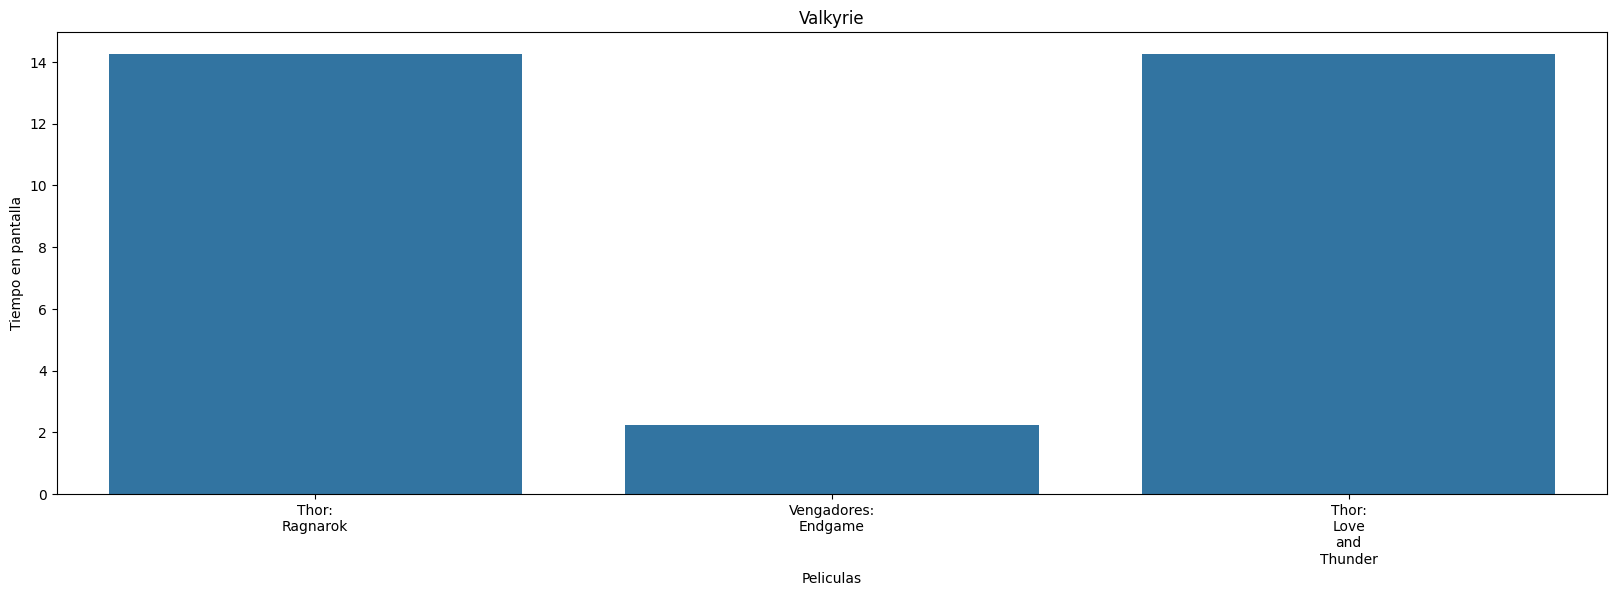

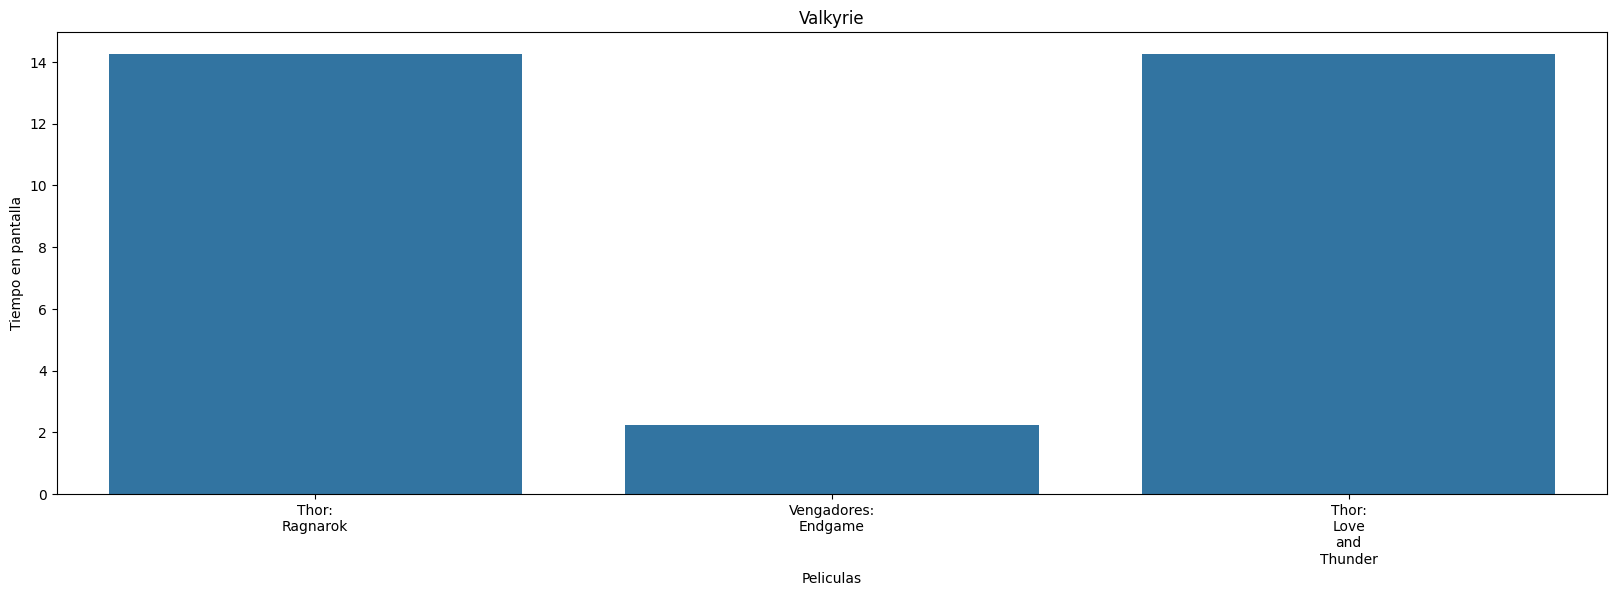

In [55]:
def grafico_peliculas_del_char (char):
    peliculas = {}
    for peli in apariciones_pj[char]:
        peliculas[peli] = char_movie_matrix.loc[char][peli]
    plt.figure(figsize=(20, 6))
    pelis = list(map(lambda x: '\n'.join(x.split(' ')),list(peliculas.keys())))
    sns.barplot(x=pelis, y=list(peliculas.values()))
    plt.title(char)
    plt.xlabel('Peliculas')
    plt.ylabel('Tiempo en pantalla');
    return plt.gcf()

grafico_peliculas_del_char ('Valkyrie')

In [83]:
import plotly.express as px

def generar_grafico_plotly_peliculas_del_char(char):
    # Datos de ejemplo (sustituir con tus datos reales)
    peliculas = {}
    for peli in apariciones_pj[char]:
        peliculas[peli] = char_movie_matrix.loc[char][peli]
    # Crear un DataFrame con los datos
    df = pd.DataFrame(list(peliculas.items()), columns=['Pelicula', 'Tiempo en pantalla'])

    # Convertir nombres de películas para el eje x
    df['Pelicula'] = df['Pelicula'].apply(lambda x: '\n'.join(x.split(' ')))

    # Crear el gráfico de barras con Plotly Express
    fig = px.bar(df,
                 x='Pelicula',
                 y='Tiempo en pantalla',
                 title=char,
                 color_discrete_sequence=['rgb(179, 39, 14)'],
                 labels={'Peliculas': 'Pelicula', 'Tiempo en pantalla': 'Tiempo en pantalla'},
				 hover_data={'Pelicula': True, 'Tiempo en pantalla': True}  # Incluye datos adicionales para mostrar en el hover
    )
    fig.update_traces(
        hovertemplate='Pelicula: %{x}<br>Tiempo en pantalla: %{y} mins'
    )
    # Ajustar diseño del gráfico
    fig.update_layout(height=400, width=800)
    fig.show()
    # Devolver el objeto de figura (Figure) en lugar de mostrarlo
    return fig
generar_grafico_plotly_peliculas_del_char('Loki')

Tony Stark / Iron Man: ['Iron Man', 'El increíble Hulk', 'Iron Man 2', 'Los Vengadores', 'Iron Man 3', 'Vengadores: La era de Ultrón', 'Capitán América: Civil War', 'Spider-Man: Homecoming', 'Vengadores: Infinity War', 'Vengadores: Endgame', 'Spider-Man: Lejos de casa', 'Loki']
Steve Rogers: ['Capitán América: El primer vengador', 'Los Vengadores', 'Marvel One-Shot: Agente Carter', 'Capitán América: El Soldado de Invierno', 'Vengadores: La era de Ultrón', 'Ant-Man', 'Capitán América: Civil War', 'Spider-Man: Homecoming', 'Vengadores: Infinity War', 'Capitana Marvel', 'Vengadores: Endgame', 'Loki']
Black Widow: ['Iron Man 2', 'Los Vengadores', 'Capitán América: El Soldado de Invierno', 'Vengadores: La era de Ultrón', 'Capitán América: Civil War', 'Thor: Ragnarok', 'Vengadores: Infinity War', 'Capitana Marvel', 'Vengadores: Endgame', 'Loki', 'Viuda Negra']
Nick Fury: ['Iron Man', 'Iron Man 2', 'Thor', 'Capitán América: El primer vengador', 'Los Vengadores', 'Capitán América: El Soldado d

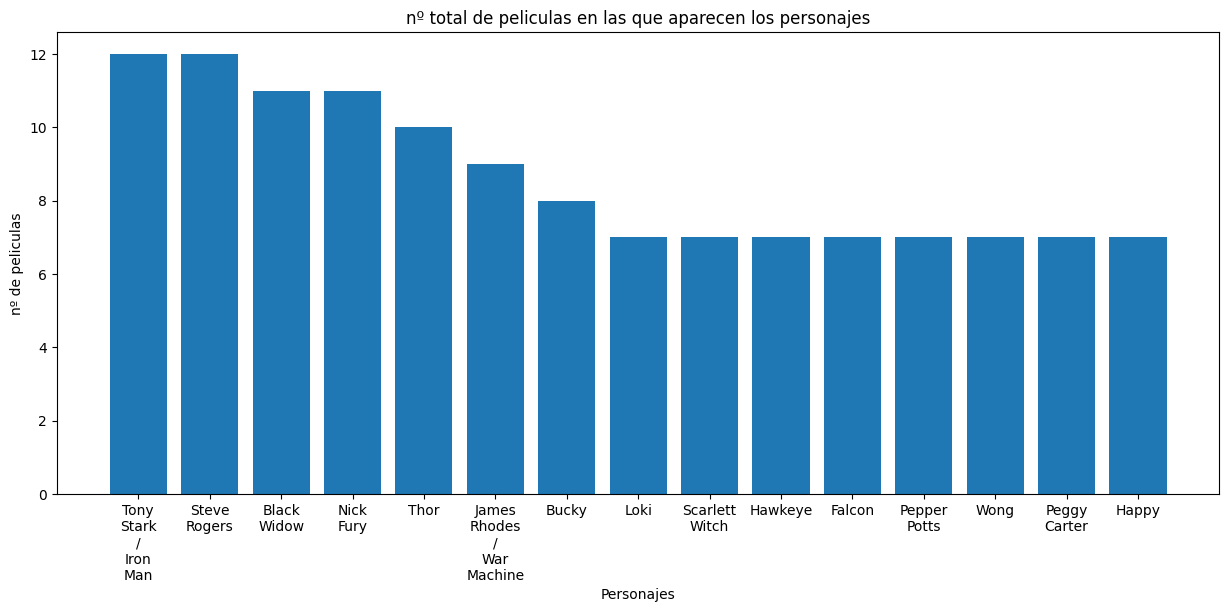

In [85]:
ordenado_por_longitud = OrderedDict(sorted(apariciones_pj.items(), key=lambda x: len(x[1]), reverse=True))

# Mostrar el resultado
for clave, valor in islice(ordenado_por_longitud.items(), 4):
    print(f'{clave}: {(valor)}')
claves = list(ordenado_por_longitud.keys())[:15]

longitudes = [len(ordenado_por_longitud[clave]) for clave in claves]
claves = list(map(lambda x: '\n'.join(x.split(' ')),claves))

# Crear el gráfico de barras
plt.figure(figsize=(15, 6))
plt.bar(claves, longitudes)

# Añadir etiquetas y título
plt.xlabel('Personajes')
plt.ylabel('nº de peliculas')
plt.title('nº total de peliculas en las que aparecen los personajes');

In [91]:
def generar_grafico_barras(claves, longitudes, color_barras='blue'):
    # Crear un DataFrame con los datos
    df = pd.DataFrame({'Claves': claves, 'Longitudes': longitudes})

    # Crear el gráfico de barras con Plotly Express
    fig = px.bar(
        df,
        x='Claves',
        y='Longitudes',
        title='nº total de apariciones de los personajes',
        labels={'Claves': 'Claves', 'Longitudes': 'Longitudes'},
        color_discrete_sequence=['rgb(179, 39, 14)'],  # Especifica el color de las barras
        hover_data={'Claves': True, 'Longitudes': True},  # Incluye datos adicionales para mostrar en el hover
    )

    # Personalizar el formato del hovertemplate
    fig.update_traces(
        hovertemplate='Personaje: %{x}<br>nº de apariciones: %{y}'
    )

    # Ajustar diseño del gráfico
    fig.update_layout(height=500, width=900)

    # Devolver el objeto de figura (Figure) en lugar de mostrarlo
    return fig

generar_grafico_barras(claves, longitudes)

In [95]:
# Función que genera un gráfico de barras en Plotly y lo devuelve
def generar_grafico_barras_df(cantidad):
    # Obtener las etiquetas de las filas (índice) y valores de la última columna
    data = char_movie_matrix.head(cantidad)
    nombres_filas = data.index
    valores_ultima_columna = data.iloc[:, -1]

    # Crear un DataFrame con los datos
    df = pd.DataFrame({'Personaje': nombres_filas, 'Tiempo total en pantalla': valores_ultima_columna})

    # Crear el gráfico de barras con Plotly Express
    fig = px.bar(
        df,
        x='Personaje',
        y='Tiempo total en pantalla',
        labels={'Personaje': 'Personaje', 'Tiempo total en pantalla': 'Tiempo total en pantalla'},
        color_discrete_sequence=['rgb(179, 39, 14)'],  # Especifica el color de las barras
        hover_data={'Personaje': True, 'Tiempo total en pantalla': True},  # Incluye datos adicionales para mostrar en el hover
    )

    # Personalizar el formato del hovertemplate
    fig.update_traces(
        hovertemplate='Personaje: %{x}<br>Tiempo total en pantalla: %{y}'
    )

    # Ajustar diseño del gráfico
    fig.update_layout(height=500, width=900)

    # Devolver el objeto de figura (Figure) en lugar de mostrarlo
    return fig
generar_grafico_barras_df(10)

In [152]:
nueva_fila = pd.Series([0] * len(char_movie_matrix.columns), index=char_movie_matrix.columns, name='Fase')
char_movie_matrix = char_movie_matrix.append(nueva_fila, ignore_index=False)

char_movie_matrix

C:\Users\lache\AppData\Local\Temp\ipykernel_17740\228785087.py:2: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Iron Man El increíble Hulk Iron Man 2   Thor  \
Tony Stark / Iron Man        77.25               0.5      61.25    0.0   
Thor                           0.0               0.0        0.0  43.25   
Peter Parker / Spider-Man      0.0               0.0        0.0    0.0   
Steve Rogers                   0.0               0.0        0.0    0.0   
Loki                           0.0               0.0        0.0  21.25   
...                            ...               ...        ...    ...   
Edwin Jarvis                   0.0               0.0        0.0    0.0   
Aleta Ogord                    0.0               0.0        0.0    0.0   
Darryl                         0.0               0.0        0.0    0.0   
Serie                        False             False      False  False   
Fase                             0                 0          0      0   

                          Capitán América: El primer vengador Los Vengadores  \
Tony Stark / Iron Man                                     0.0          31.75   
Thor                                                      0.0           18.0   
Peter Parker / Spider-Man                                 0.0            0.0   
Steve Rogers                                             56.5          28.25   
Loki                                                      0.0           21.5   
...                                                       ...            ...   
Edwin Jarvis                                              0.0            0.0   
Aleta Ogord                                               0.0            0.0   
Darryl                                                    0.0            0.0   
Serie                                                   False          False   
Fase                                                        0              0   

                          Iron Man 3 Marvel One-Shot: Agente Carter  \
Tony Stark / Iron Man          62.25                            0.0   
Thor                             0.0                            0.0   
Peter Parker / Spider-Man        0.0                            0.0   
Steve Rogers                     0.0                           0.25   
Loki                             0.0                            0.0   
...                              ...                            ...   
Edwin Jarvis                     0.0                            0.0   
Aleta Ogord                      0.0                            0.0   
Darryl                           0.0                            0.0   
Serie                          False                          False   
Fase                               0                              0   

                          Thor: El mundo oscuro  \
Tony Stark / Iron Man                       0.0   
Thor                                       35.0   
Peter Parker / Spider-Man                   0.0   
Steve Rogers                                0.0   
Loki                                       17.5   
...                                         ...   
Edwin Jarvis                                0.0   
Aleta Ogord                                 0.0   
Darryl                                      0.0   
Serie                                     False   
Fase                                          0   

                          Capitán América: El Soldado de Invierno  ...  \
Tony Stark / Iron Man                                         0.0  ...   
Thor                                                          0.0  ...   
Peter Parker / Spider-Man                                     0.0  ...   
Steve Rogers                                                 59.0  ...   
Loki                                                          0.0  ...   
...                                                           ...  ...   
Edwin Jarvis                                                  0.0  ...   
Aleta Ogord                                                   0.0  ...   
Darryl                                      

In [167]:
for i in char_movie_matrix.columns:
    if i in char_movie_matrix.loc[:,'Iron Man':'Los Vengadores'].columns:
        char_movie_matrix.loc['Fase', i] = 1
    if i in char_movie_matrix.loc[:,'Los Vengadores':'Ant-Man'].columns:
        char_movie_matrix.loc['Fase', i] = 2
    if i in char_movie_matrix.loc[:,'Capitán América: Civil War':'Spider-Man: Lejos de casa'].columns:
        char_movie_matrix.loc['Fase', i] = 3
    if i in char_movie_matrix.loc[:,'Bruja Escarlata y Visión' : 'Guardianes de la Galaxia: Especial felices fiestas'].columns:
        char_movie_matrix.loc['Fase', i] = 4


char_movie_matrix



Iron Man El increíble Hulk Iron Man 2   Thor  \
Tony Stark / Iron Man        77.25               0.5      61.25    0.0   
Thor                           0.0               0.0        0.0  43.25   
Peter Parker / Spider-Man      0.0               0.0        0.0    0.0   
Steve Rogers                   0.0               0.0        0.0    0.0   
Loki                           0.0               0.0        0.0  21.25   
...                            ...               ...        ...    ...   
Edwin Jarvis                   0.0               0.0        0.0    0.0   
Aleta Ogord                    0.0               0.0        0.0    0.0   
Darryl                         0.0               0.0        0.0    0.0   
Serie                        False             False      False  False   
Fase                             1                 1          1      1   

                          Capitán América: El primer vengador Los Vengadores  \
Tony Stark / Iron Man                                     0.0          31.75   
Thor                                                      0.0           18.0   
Peter Parker / Spider-Man                                 0.0            0.0   
Steve Rogers                                             56.5          28.25   
Loki                                                      0.0           21.5   
...                                                       ...            ...   
Edwin Jarvis                                              0.0            0.0   
Aleta Ogord                                               0.0            0.0   
Darryl                                                    0.0            0.0   
Serie                                                   False          False   
Fase                                                        1              2   

                          Iron Man 3 Marvel One-Shot: Agente Carter  \
Tony Stark / Iron Man          62.25                            0.0   
Thor                             0.0                            0.0   
Peter Parker / Spider-Man        0.0                            0.0   
Steve Rogers                     0.0                           0.25   
Loki                             0.0                            0.0   
...                              ...                            ...   
Edwin Jarvis                     0.0                            0.0   
Aleta Ogord                      0.0                            0.0   
Darryl                           0.0                            0.0   
Serie                          False                          False   
Fase                               2                              2   

                          Thor: El mundo oscuro  \
Tony Stark / Iron Man                       0.0   
Thor                                       35.0   
Peter Parker / Spider-Man                   0.0   
Steve Rogers                                0.0   
Loki                                       17.5   
...                                         ...   
Edwin Jarvis                                0.0   
Aleta Ogord                                 0.0   
Darryl                                      0.0   
Serie                                     False   
Fase                                          2   

                          Capitán América: El Soldado de Invierno  ...  \
Tony Stark / Iron Man                                         0.0  ...   
Thor                                                          0.0  ...   
Peter Parker / Spider-Man                                     0.0  ...   
Steve Rogers                                                 59.0  ...   
Loki                                                          0.0  ...   
...                                                           ...  ...   
Edwin Jarvis                                                  0.0  ...   
Aleta Ogord                                                   0.0  ...   
Darryl                                      

In [161]:
char_movie_matrix.loc[:,'Iron Man':'Thor'].columns

Index(['Iron Man', 'El increíble Hulk', 'Iron Man 2', 'Thor'], dtype='object')

In [146]:
columnas_a_excluir = char_movie_matrix.columns[char_movie_matrix.loc['Serie']==False]

# Crear un nuevo DataFrame con las columnas seleccionadas
char_movie_matrix[columnas_a_excluir]

Iron Man El increíble Hulk Iron Man 2   Thor  \
Tony Stark / Iron Man        77.25               0.5      61.25    0.0   
Thor                           0.0               0.0        0.0  43.25   
Peter Parker / Spider-Man      0.0               0.0        0.0    0.0   
Steve Rogers                   0.0               0.0        0.0    0.0   
Loki                           0.0               0.0        0.0  21.25   
...                            ...               ...        ...    ...   
Daniel Drumm                   0.0               0.0        0.0    0.0   
Edwin Jarvis                   0.0               0.0        0.0    0.0   
Aleta Ogord                    0.0               0.0        0.0    0.0   
Darryl                         0.0               0.0        0.0    0.0   
Serie                        False             False      False  False   

                          Capitán América: El primer vengador Los Vengadores  \
Tony Stark / Iron Man                                     0.0          31.75   
Thor                                                      0.0           18.0   
Peter Parker / Spider-Man                                 0.0            0.0   
Steve Rogers                                             56.5          28.25   
Loki                                                      0.0           21.5   
...                                                       ...            ...   
Daniel Drumm                                              0.0            0.0   
Edwin Jarvis                                              0.0            0.0   
Aleta Ogord                                               0.0            0.0   
Darryl                                                    0.0            0.0   
Serie                                                   False          False   

                          Iron Man 3 Marvel One-Shot: Agente Carter  \
Tony Stark / Iron Man          62.25                            0.0   
Thor                             0.0                            0.0   
Peter Parker / Spider-Man        0.0                            0.0   
Steve Rogers                     0.0                           0.25   
Loki                             0.0                            0.0   
...                              ...                            ...   
Daniel Drumm                     0.0                            0.0   
Edwin Jarvis                     0.0                            0.0   
Aleta Ogord                      0.0                            0.0   
Darryl                           0.0                            0.0   
Serie                          False                          False   

                          Thor: El mundo oscuro  \
Tony Stark / Iron Man                       0.0   
Thor                                       35.0   
Peter Parker / Spider-Man                   0.0   
Steve Rogers                                0.0   
Loki                                       17.5   
...                                         ...   
Daniel Drumm                                0.0   
Edwin Jarvis                                0.0   
Aleta Ogord                                 0.0   
Darryl                                      0.0   
Serie                                     False   

                          Capitán América: El Soldado de Invierno  ...  \
Tony Stark / Iron Man                                         0.0  ...   
Thor                                                          0.0  ...   
Peter Parker / Spider-Man                                     0.0  ...   
Steve Rogers                                                 59.0  ...   
Loki                                                          0.0  ...   
...                                                           ...  ...   
Daniel Drumm                                                  0.0  ...   
Edwin Jarvis                                                  0.0  ...   
Aleta Ogord                                 

In [149]:
def apariciones_pj(no_serie=False):
    if no_serie:
        # Filtrar las columnas excluyendo las que tienen False en la fila 'Serie'
        columnas_a_excluir = char_movie_matrix.columns[char_movie_matrix.loc['Serie'] == False]
        # Crear un nuevo DataFrame sin las columnas seleccionadas
        data = char_movie_matrix[columnas_a_excluir]
    else:
        data = char_movie_matrix

    apariciones_pj = OrderedDict()

    for pj in data.index:
        # Filtrar las columnas que no son cero ni son de tipo string
        columnas_no_cero = char_movie_matrix.loc[pj, (char_movie_matrix.loc[pj] != 0) & (char_movie_matrix.loc[pj].apply(isinstance, args=(float,)))].index.tolist()
        # Excluir la última columna ('Serie') si existe
        apariciones_pj[pj] = columnas_no_cero[:-1]

    return apariciones_pj

In [174]:
def generar_grafico_barras_num_apariciones(cantidad, fases, no_serie=False):
	
    ordenado_por_longitud = OrderedDict(sorted(apariciones_pj(no_serie,fases).items(), key=lambda x: len(x[1]), reverse=True))
    claves = list(ordenado_por_longitud.keys())[:cantidad]
    longitudes = [len(ordenado_por_longitud[clave]) for clave in claves]
	
    claves = list(map(lambda x: '\n'.join(x.split(' ')),claves))
    df = pd.DataFrame({'Claves': claves, 'Longitudes': longitudes})

    # Crear el gráfico de barras con Plotly Express
    fig = px.bar(
        df,
        x='Claves',
        y='Longitudes',
		title='Nº total de apariciones de los personajes',
        labels={'Claves': 'Claves', 'Longitudes': 'Longitudes'},
        color_discrete_sequence=['rgb(179, 39, 14)'],  # Especifica el color de las barras
        hover_data={'Claves': True, 'Longitudes': True},  # Incluye datos adicionales para mostrar en el hover
    )

    # Personalizar el formato del hovertemplate
    fig.update_traces(
        hovertemplate='Personaje: %{x}<br>Nº de apariciones: %{y}'
    )

    # Ajustar diseño del gráfico
    fig.update_layout(height=500, width=900)

    # Devolver el objeto de figura (Figure) en lugar de mostrarlo
    return fig

In [172]:
# Lista de valores para el rango
fases = [0,1,2,3,4]

columnas_seleccionadas = char_movie_matrix.columns[char_movie_matrix.loc['Fase'] .isin(fases)]
char_movie_matrix[columnas_seleccionadas]

Iron Man El increíble Hulk Iron Man 2   Thor  \
Tony Stark / Iron Man        77.25               0.5      61.25    0.0   
Thor                           0.0               0.0        0.0  43.25   
Peter Parker / Spider-Man      0.0               0.0        0.0    0.0   
Steve Rogers                   0.0               0.0        0.0    0.0   
Loki                           0.0               0.0        0.0  21.25   
...                            ...               ...        ...    ...   
Edwin Jarvis                   0.0               0.0        0.0    0.0   
Aleta Ogord                    0.0               0.0        0.0    0.0   
Darryl                         0.0               0.0        0.0    0.0   
Serie                        False             False      False  False   
Fase                             1                 1          1      1   

                          Capitán América: El primer vengador Los Vengadores  \
Tony Stark / Iron Man                                     0.0          31.75   
Thor                                                      0.0           18.0   
Peter Parker / Spider-Man                                 0.0            0.0   
Steve Rogers                                             56.5          28.25   
Loki                                                      0.0           21.5   
...                                                       ...            ...   
Edwin Jarvis                                              0.0            0.0   
Aleta Ogord                                               0.0            0.0   
Darryl                                                    0.0            0.0   
Serie                                                   False          False   
Fase                                                        1              2   

                          Iron Man 3 Marvel One-Shot: Agente Carter  \
Tony Stark / Iron Man          62.25                            0.0   
Thor                             0.0                            0.0   
Peter Parker / Spider-Man        0.0                            0.0   
Steve Rogers                     0.0                           0.25   
Loki                             0.0                            0.0   
...                              ...                            ...   
Edwin Jarvis                     0.0                            0.0   
Aleta Ogord                      0.0                            0.0   
Darryl                           0.0                            0.0   
Serie                          False                          False   
Fase                               2                              2   

                          Thor: El mundo oscuro  \
Tony Stark / Iron Man                       0.0   
Thor                                       35.0   
Peter Parker / Spider-Man                   0.0   
Steve Rogers                                0.0   
Loki                                       17.5   
...                                         ...   
Edwin Jarvis                                0.0   
Aleta Ogord                                 0.0   
Darryl                                      0.0   
Serie                                     False   
Fase                                          2   

                          Capitán América: El Soldado de Invierno  ...  \
Tony Stark / Iron Man                                         0.0  ...   
Thor                                                          0.0  ...   
Peter Parker / Spider-Man                                     0.0  ...   
Steve Rogers                                                 59.0  ...   
Loki                                                          0.0  ...   
...                                                           ...  ...   
Edwin Jarvis                                                  0.0  ...   
Aleta Ogord                                                   0.0  ...   
Darryl                                      

In [191]:
def apariciones_pj(no_serie,fases):
    columnas_seleccionadas = char_movie_matrix.columns[char_movie_matrix.loc['Fase'] .isin(fases)]
    data_f = char_movie_matrix[columnas_seleccionadas]
    if no_serie:
        # Filtrar las columnas excluyendo las que tienen False en la fila 'Serie'
        columnas_a_excluir = data_f.columns[data_f.loc['Serie'] == False]
        # Crear un nuevo DataFrame sin las columnas seleccionadas
        data = data_f[columnas_a_excluir]
    else:
        data = data_f

    apariciones_pj = OrderedDict()

    for pj in data.index:
        # Filtrar las columnas que no son cero ni son de tipo string
        columnas_no_cero = data.loc[pj, (data.loc[pj] != 0) & (data.loc[pj].apply(isinstance, args=(float,)))].index.tolist()
        # Excluir la última columna ('Serie') si existe
        apariciones_pj[pj] = columnas_no_cero[:-1]

    return apariciones_pj

In [186]:
def generar_grafico_peliculas_del_char(char,fases, no_serie=False):
    columnas_seleccionadas = char_movie_matrix.columns[char_movie_matrix.loc['Fase'] .isin(fases)]
    data_f = char_movie_matrix[columnas_seleccionadas]
		
    peliculas = {}
    for peli in apariciones_pj(no_serie,fases)[char]:
        peliculas[peli] = data_f.loc[char][peli]

    # Crear un DataFrame con los datos
    df = pd.DataFrame(list(peliculas.items()), columns=['Pelicula', 'Tiempo en pantalla'])

    # Convertir nombres de películas para el eje x
    df['Pelicula'] = df['Pelicula'].apply(lambda x: '\n'.join(x.split(' ')))

    # Crear el gráfico de barras con Plotly Express
    fig = px.bar(df,
                 x='Pelicula',
                 y='Tiempo en pantalla',
                 title=char,
                 color_discrete_sequence=['rgb(179, 39, 14)'],
                 labels={'Pelicula': 'Peliculas', 'Tiempo en pantalla': 'Tiempo en pantalla'},
				 hover_data={'Pelicula': True, 'Tiempo en pantalla': True},  # Incluye datos adicionales para mostrar en el hover
    )
    fig.update_traces(
        hovertemplate='Pelicula: %{x}<br>Tiempo en pantalla: %{y} mins'
    )
    # Ajustar diseño del gráfico
    fig.update_layout(height=400, width=800)
    # Devolver el objeto de figura (Figure) en lugar de mostrarlo
    return fig

In [194]:
generar_grafico_peliculas_del_char('Scarlett Witch',[0,4],False)